### Use Machine Learning to predict the probability of needing Post-Mastectom Radiotherapy
Author: Yifu (Charles) Chen

A notebook in Python Language

In [1]:
### Import modules ###
import os
import glob
import pandas as pd
import numpy as np
from typing import Dict, List
# Machine Learning Modules for Random Forest, Logistic Regression, and XGBoost
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from xgboost import XGBClassifier
# Metrics
from sklearn import metrics

### Utils

In [2]:
# Setup no print limits and etc.
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('expand_frame_repr', False)

class bcolors:
    # Helper class to print in terminal with colors
    HEADER = '\033[95m'
    OKBLUE = '\033[94m'
    OKCYAN = '\033[96m'
    OKGREEN = '\033[92m'
    WARNING = '\033[93m'
    FAIL = '\033[91m'
    ENDC = '\033[0m'
    BOLD = '\033[1m'
    UNDERLINE = '\033[4m'
    NORMAL = '\033[0m'

In [25]:
from collections import OrderedDict

# Directory of DataFrames
dir_to_df = "/Users/yifu/PycharmProjects/Radiotherapy-Prediction/data/experiments/May19 Datasets for Experiments Table (includes Alan's Heuritsic)"

# Path to log file
log_path = os.path.join(dir_to_df, "log.txt")

# Create a new log file from scratch, regardless if one exists
with open(log_path, "w") as log_file:
    log_file.write("")

def print_and_log(*args, **kwargs):
    # Helper function to print and log
    # Can write DataFrame to log file too
    print(*args, **kwargs)
    with open(log_path, "a") as log_file:
        if type(args[0]) == pd.DataFrame:
            log_file.write(args[0].to_string() + "\n")
        else:
            log_file.write("|| ".join([str(a) for a in args]) + "\n")

    
# Assume all files in directory are CSV DataFrame files
paths_to_df = glob.glob(os.path.join(dir_to_df, "*.csv"))

# Read each DataFrame file
dfs = OrderedDict()
for path in paths_to_df:
    df_name = path.replace(dir_to_df, "")
    df = pd.read_csv(path)
    # Drop "PRE_record_id" column, if it exists
    if "PRE_record_id" in df.columns:
        df = df.drop(columns=["PRE_record_id"], axis=1)
    dfs[df_name] = df
# Sorted the dict by path name
dfs = OrderedDict(sorted(dfs.items()))

for k in dfs.keys():
    print_and_log(k)
    



/0_PRE-alan-heuristic7cols.csv
/1_PRE-expert-imputed24cols.csv
/2_PRE-0.05spars-expert-imputed65cols.csv
/3_PRE-0.2spars-expert-imputed67cols.csv
/4_PRE-0.5spars-expert-imputed68cols.csv
/5_PRE-0.8spars-expert-imputed72cols.csv
/6_PRE-1.0spars-expert-imputed86cols.csv
/7_POS-0.05spars-expert-imputed83cols.csv
/8_POS-0.2spars-expert-imputed93cols.csv
/9_POS-0.5spars-expert-imputed101cols.csv
/A_POS-0.8spars-expert-imputed110cols.csv
/B_POS-1.0spars-expert-imputed128cols.csv


### Pre-Process Datasets

In [8]:
# Standardize the data by removing the mean and scaling to unit variance
# The target variable is named "POS_did_the_patient_receive_pm"

dfs_std = OrderedDict()

for df_name, df in dfs.items():
    # Standardize all columns except the target column "POS_did_the_patient_receive_pm"
    df_std = df.copy()
    df_std.drop(["POS_did_the_patient_receive_pm"], axis=1, inplace=True)
    df_std = (df_std - df_std.mean()) / df_std.std()
    df_std = df_std.copy()
    # Concatenate the target column back
    df_std["POS_did_the_patient_receive_pm"] = df["POS_did_the_patient_receive_pm"]
    # Convert the target column to binary
    df_std["POS_did_the_patient_receive_pm"] = df_std["POS_did_the_patient_receive_pm"] > 0
    dfs_std[df_name] = df_std


### Build Machine Learning Classifiers

In [9]:
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

In [27]:


# Initialize a dictionary for holding the models for each DataFrame
# Schema: {"DataFrame Name": {"Model Name": Model Object, ...}, ...}
from collections import defaultdict
from sklearn.model_selection import KFold
from sklearn.metrics import f1_score

all_models = defaultdict(dict)

# The print_df contains the dataframe, model, and the average CV accuracy, AUC, and the top 6 features and their scores
print_df_columns = ["Dataset", "Model", "Avg CV Accuracy", "Avg CV AUC", "Avg CV F1", "Feature_1", "Score_1", "Feature_2", "Score_2", 
                    "Feature_3", "Score_3", "Feature_4", "Score_4", "Feature_5", "Score_5", "Feature_6", "Score_6"]
def build_classifiers(df: pd.DataFrame, df_name: str) -> Dict[str, object]:
    """
    For each DataFrame, build the following classifiers:
        Logistic Regression
        Random Forest
        XGBoost
    Args:
        df (pd.DataFrame): the DataFrame to build the classifiers for
        df_name (str): the name of the DataFrame
    Returns:
        None
    """
    # Impute missing values with KNN
    from sklearn.impute import KNNImputer
    imputer = KNNImputer(n_neighbors=5)
    df = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
    
    # Drop any columns with all NaN values
    df.dropna(axis=1, how="all", inplace=True)
    assert df.isnull().sum().sum() == 0
    # Initialize a dictionary for holding the models for each DataFrame
    # Schema: {"Fold 1": {"Model Name": Model Object, ...}, ...}
    models = defaultdict(dict)
    performance = defaultdict(dict)
    # Train each model using 5-fold cross-validation
    kf = KFold(n_splits=5, shuffle=True, random_state=0)
    for fold, (train_index, test_index) in enumerate(kf.split(df)):
        # Split the DataFrame into training and validation sets
        df_train, df_val = df.iloc[train_index], df.iloc[test_index]
        # Build the classifiers
        models[fold] = {"Logistic Regression": LogisticRegression(),
                        "Random Forest": RandomForestClassifier(),
                        "XGBoost": XGBClassifier()
                        }
        for model_name, model in models[fold].items():
            # Train each model using the training set
            model.fit(
                df_train.drop(["POS_did_the_patient_receive_pm"], axis=1),
                df_train["POS_did_the_patient_receive_pm"]
                )
            # Predict the validation set
            y_pred = model.predict(
                df_val.drop(["POS_did_the_patient_receive_pm"], axis=1)
            )
            # Calculate the accuracy of the model
            accuracy = np.mean(y_pred == df_val["POS_did_the_patient_receive_pm"])
            # Calcuilate the F1
            F1 = f1_score(y_true=df_val["POS_did_the_patient_receive_pm"], y_pred=y_pred)
            # Predict the probability of the validation set
            y_pred_proba = model.predict_proba(df_val.drop(["POS_did_the_patient_receive_pm"], axis=1))[:, 1]
            # Calculate the AUC of the model
            auc = metrics.roc_auc_score(df_val["POS_did_the_patient_receive_pm"], y_pred_proba)
            if model_name != "Logistic Regression":
                # Get the features for the model
                feature_importances = pd.Series(model.feature_importances_, index=df_train.drop(["POS_did_the_patient_receive_pm"], axis=1).columns)
                # Store the accuracy, AUC, and features for the model
                performance[model_name][fold] = {"accuracy": accuracy, "auc": auc, "F1": F1, "top_features": feature_importances}
            else:
                # Store the accuracy and AUC for the model
                performance[model_name][fold] = {"accuracy": accuracy, "auc": auc, "F1": F1, "top_features": pd.Series([0]*6)}
    
    # Consolidate the top features for each model
    # Schema: {"Model Name": {"Feature_1": Score_1, ...}, ...}
    feature_scores = defaultdict(lambda: defaultdict(float))
    for model_name, fold in performance.items():
        for fold_num, fold_performance in fold.items():
            # Extract feature name and importance score
            for feature_name, score in fold_performance["top_features"].items():
                feature_scores[model_name][feature_name] += score
        # Divide the feature importance scores by the number of folds
        for feature_name, score in feature_scores[model_name].items():
            feature_scores[model_name][feature_name] /= len(fold)
            # Round to 2 decimal places
            feature_scores[model_name][feature_name] = round(feature_scores[model_name][feature_name], 2)
    
    # Print the performance of each model, including averaged across folds
    # DataFrame for printing results in a nice format
    # Format: Dataset | Model | Avg CV Accuracy | Avg CV AUC | Feature_1 | Score_1 | Feature_2 | Score_2 | Feature_3 | Score_3 | Feature_4 | Score_4 | Feature_5 | Score_5 | Feature_6 | Score_6
    print_df = pd.DataFrame(columns=print_df_columns)
    for model_name, fold in performance.items():
        accuracy = round(np.mean([fold[fold_num]["accuracy"] for fold_num in fold.keys()]), 2)
        auc = round(np.mean([fold[fold_num]["auc"] for fold_num in fold.keys()]), 2)
        F1 = round(np.mean([fold[fold_num]["F1"] for fold_num in fold.keys()]), 2)
        # Sorted list of top-6 features for the model
        top_features = sorted(feature_scores[model_name].items(), key=lambda x: x[1], reverse=True)[:6]
        feat_1, score_1 = top_features[0]
        feat_2, score_2 = top_features[1]
        feat_3, score_3 = top_features[2]
        feat_4, score_4 = top_features[3]
        feat_5, score_5 = top_features[4]
        feat_6, score_6 = top_features[5]
        curr_df = pd.DataFrame(
                    [
                        [df_name, model_name, accuracy, auc, F1] +
                        [feat_1, score_1, feat_2, score_2, feat_3, score_3, feat_4, score_4, feat_5, score_5, feat_6, score_6]
                    ],
                    columns=print_df_columns
                )
        print_df = pd.concat(
            [
                print_df,
                curr_df
            ],
            axis=0
        )
    # Print the DataFrame with nice formatting
    # print_and_log(print_df)

    # print_and_log("="*150)
    return print_df

# Build the classifiers for each DataFrame
print_df = pd.DataFrame(columns=print_df_columns)
# Create a dictionary for holding the DataFrames for plotting
plot_dict = OrderedDict()
for df_name, df in dfs_std.items():
    print_and_log(f"Processing {df_name}...")
    print_df = build_classifiers(df, df_name)
    # Transpose the DataFrame before printing it
    print_and_log(print_df.T)
    print_and_log("="*150)
    # Add the DataFrame to the dictionary for plotting later
    plot_dict[df_name] = print_df


Processing /0_PRE-alan-heuristic7cols.csv...
                                              0                               0                               0
Dataset          /0_PRE-alan-heuristic7cols.csv  /0_PRE-alan-heuristic7cols.csv  /0_PRE-alan-heuristic7cols.csv
Model                       Logistic Regression                   Random Forest                         XGBoost
Avg CV Accuracy                            0.64                            0.66                            0.66
Avg CV AUC                                 0.58                             0.7                             0.7
Avg CV F1                                  0.35                            0.48                            0.48
Feature_1                                     0              PRE_abnormal_lymph              PRE_abnormal_lymph
Score_1                                     0.0                            0.49                            0.37
Feature_2                                     1    PRE_prom

### Plotting

In [28]:
print_df

,Dataset,Model,Avg CV Accuracy,Avg CV AUC,Avg CV F1,Feature_1,Score_1,Feature_2,Score_2,Feature_3,Score_3,Feature_4,Score_4,Feature_5,Score_5,Feature_6,Score_6
0,/B_POS-1.0spars-expert-imputed128cols.csv,Logistic Regression,0.75,0.82,0.7,0,0.0,1,0.0,2,0.0,3,0.0,4,0.0,5,0.0
0,/B_POS-1.0spars-expert-imputed128cols.csv,Random Forest,0.82,0.89,0.76,POS_metastasis,0.07,POS_ax_nodes,0.05,POS_tumor_size,0.04,PRE_height_cm,0.03,PRE_lymph_node_max_size_mm,0.03,PRE_tumor_size_mm,0.03
0,/B_POS-1.0spars-expert-imputed128cols.csv,XGBoost,0.79,0.88,0.73,POS_metastasis,0.16,PRE_systhe___1,0.05,PRE_his_subtype___3,0.05,PRE_systhe___5,0.03,PRE_axillary_lymph_node_core_b,0.03,POS_mar_status,0.03


In [29]:
# Import plotting libraries for machine learning experiments
import matplotlib.pyplot as plt
import seaborn as sns

plot_dir = os.path.join(dir_to_df, "plots")
# Create the directory if it doesn't exist
if not os.path.exists(plot_dir):
    os.makedirs(plot_dir)

# Retrive the saved DataFrames, and plot the results
# Plot the results for each DataFrame on a single plot
# Reset plot parameters
plt.rcParams.update(plt.rcParamsDefault)
for metric_name in ["Avg CV Accuracy", "Avg CV AUC", "Avg CV F1"]:
    y_data = []
    x_data = []
    # Retrieve the performance for each model
    for df_name, print_df in plot_dict.items():
        # Iterate through the models of the DataFrame
        for i, row in print_df.iterrows():
            # If the model is the metric, add it to the list
            model_name = row["Model"]
            metric = row[metric_name]
            df_name = row["Dataset"]
            df_name = df_name.replace("/", "").replace(".csv", "")
            x_data.append(metric)
            y_data.append(df_name + " - " + model_name)
    # Create the plot
    # The plot has spaces between the bars
    plt.figure(figsize=(30, 16))
    # Plot the gridlines
    sns.set_style("whitegrid")
    # The color of the bar should alternate between 3 colors
    plt.barh(y_data, x_data, color=["#1f77b4", "#ff7f0e", "#2ca02c"])
    # plt.barh(y_data, x_data, align="center", alpha=0.8)
    plt.yticks(fontsize=18)
    plt.xticks(fontsize=18)
    plt.xlabel(metric_name, fontsize=20)
    plt.ylabel("Model")
    plt.title(f"{metric_name} by Model", fontsize=20)
    plt.tight_layout()
    # Save the plot
    plt.savefig(os.path.join(plot_dir, f"{metric_name}.png"))
    plt.close()



In [30]:
# Print the Feature Importance
# Format:
# DataFrame | Model | Feature_1 | Score_1 | Feature_2 | Score_2 | Feature_3 | Score_3 | Feature_4 | Score_4 | Feature_5 | Score_5 | Feature_6 | Score_6
for df_name, print_df in plot_dict.items():
    df_name = df_name.replace("/", "").replace(".csv", "")
    print_and_log(df_name)
    print()
    for i, row in print_df.iterrows():
        model_name = row["Model"]
        if model_name == "Logistic Regression":
            continue
        print_and_log("Model:", model_name)
        top_features = [row["Feature_1"], row["Feature_2"], row["Feature_3"], row["Feature_4"], row["Feature_5"], row["Feature_6"]]
        feature_scores = [row["Score_1"], row["Score_2"], row["Score_3"], row["Score_4"], row["Score_5"], row["Score_6"]]
        print_and_log(f"Top Features: {top_features}")
        print_and_log(f"Feature Scores: {feature_scores}")
        print()
    print_and_log("-"* 100)

0_PRE-alan-heuristic7cols

Model: Random Forest
Top Features: ['PRE_abnormal_lymph', 'PRE_prominent_axillary_lymph', 'PRE_axillary_lymphadenopathy', 'PRE_axillary_lymphadenopathy_p', 'PRE_int_mammary_lymphade_pet', 'PRE_internal_mammary_lymphaden']
Feature Scores: [0.49, 0.15, 0.11, 0.09, 0.08, 0.07]

Model: XGBoost
Top Features: ['PRE_abnormal_lymph', 'PRE_int_mammary_lymphade_pet', 'PRE_axillary_lymphadenopathy_p', 'PRE_axillary_lymphadenopathy', 'PRE_internal_mammary_lymphaden', 'PRE_prominent_axillary_lymph']
Feature Scores: [0.37, 0.24, 0.15, 0.1, 0.08, 0.06]

----------------------------------------------------------------------------------------------------
1_PRE-expert-imputed24cols

Model: Random Forest
Top Features: ['PRE_img_size', 'PRE_tumor_size_mm', 'PRE_tumor_grade', 'PRE_men_status', 'PRE_abnormal_lymph', 'PRE_tumor_location']
Feature Scores: [0.26, 0.16, 0.07, 0.06, 0.06, 0.05]

Model: XGBoost
Top Features: ['PRE_abnormal_ln_present', 'PRE_metastatic_carcinoma_on_ax', 

/var/folders/w0/qnylxtkj0jb_t_zph8h7dg840000gn/T/ipykernel_60648/3429959939.py:13: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  plt.figure(figsize=(30, 16))


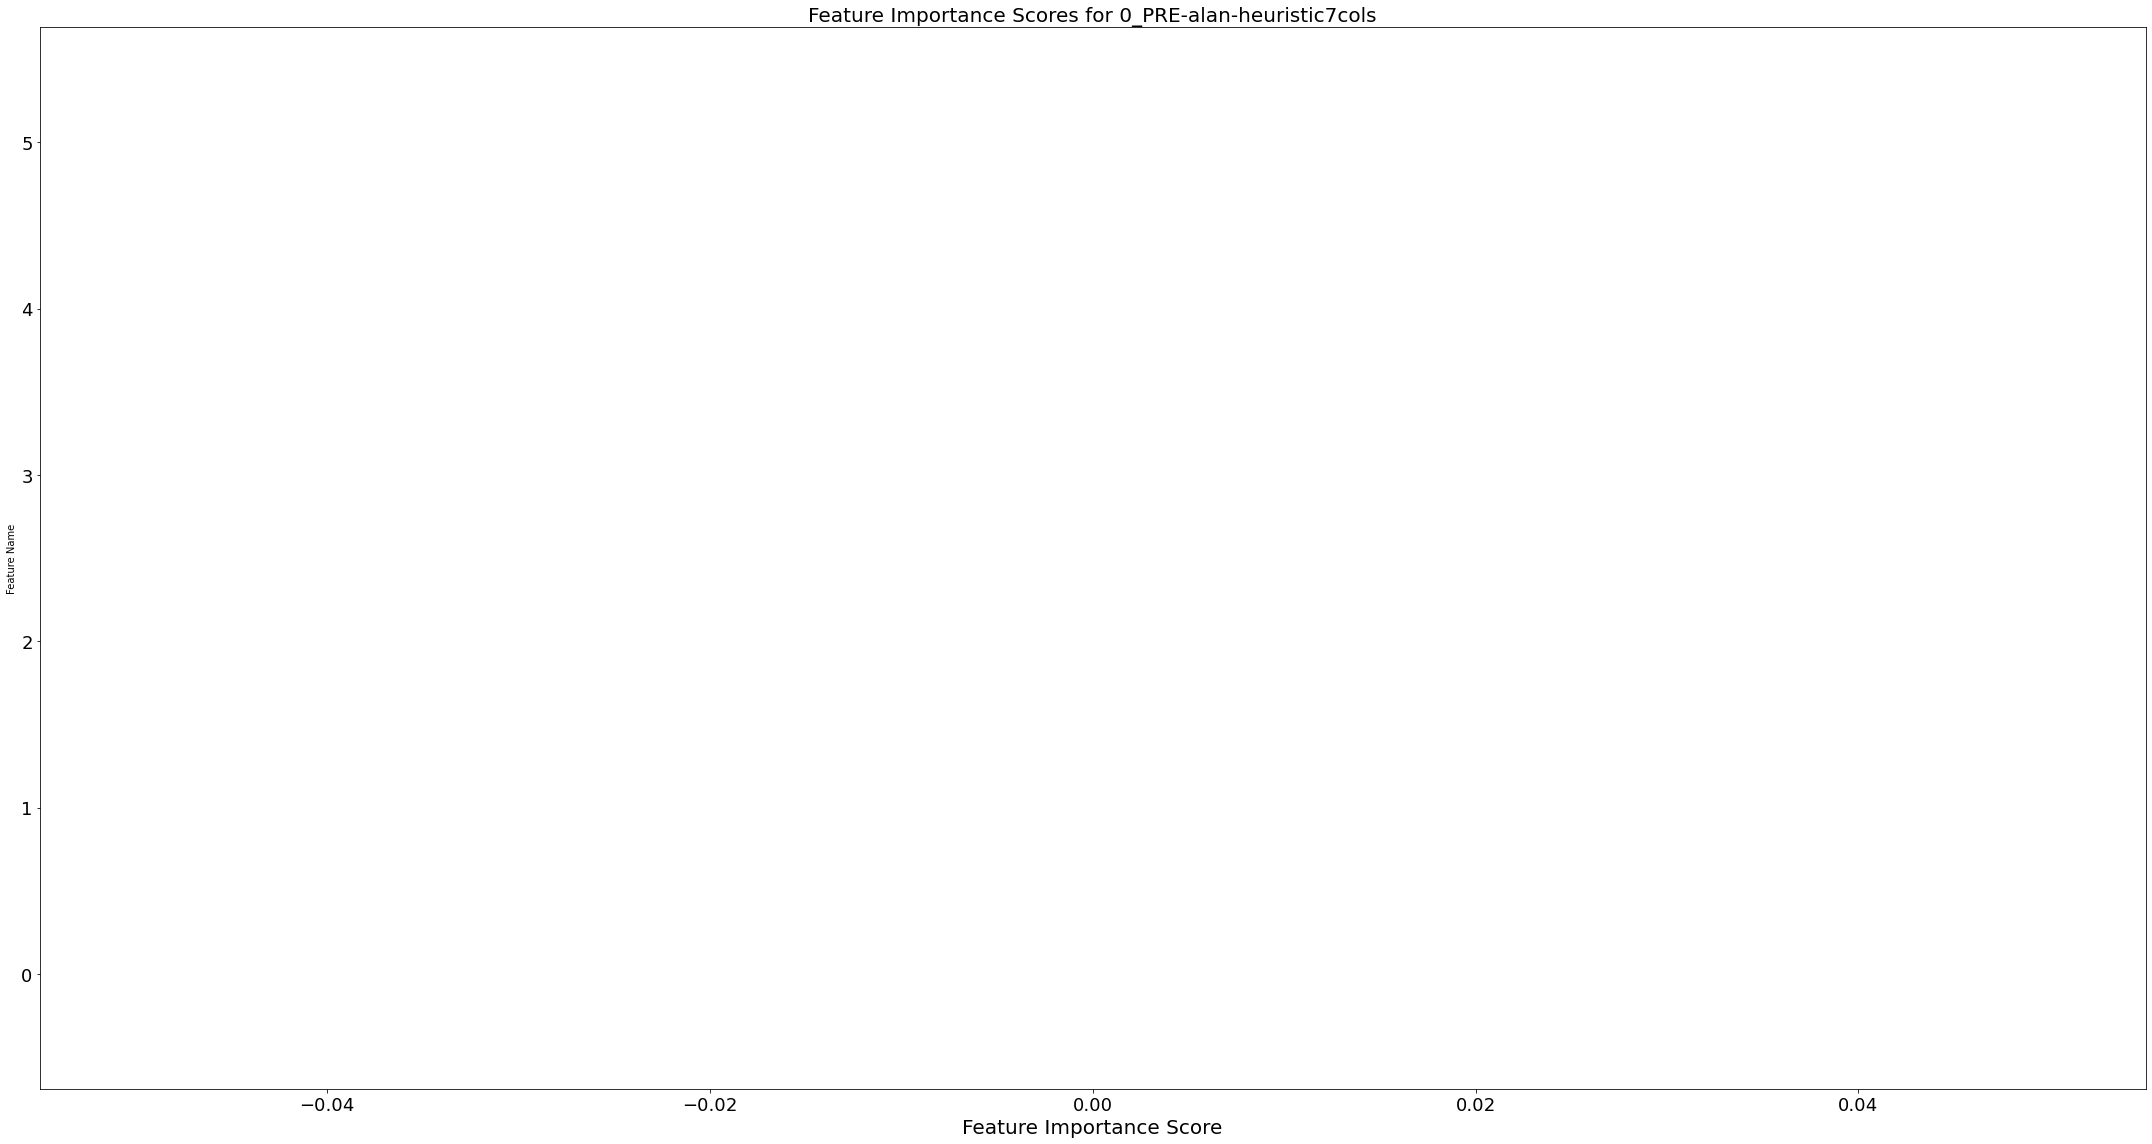

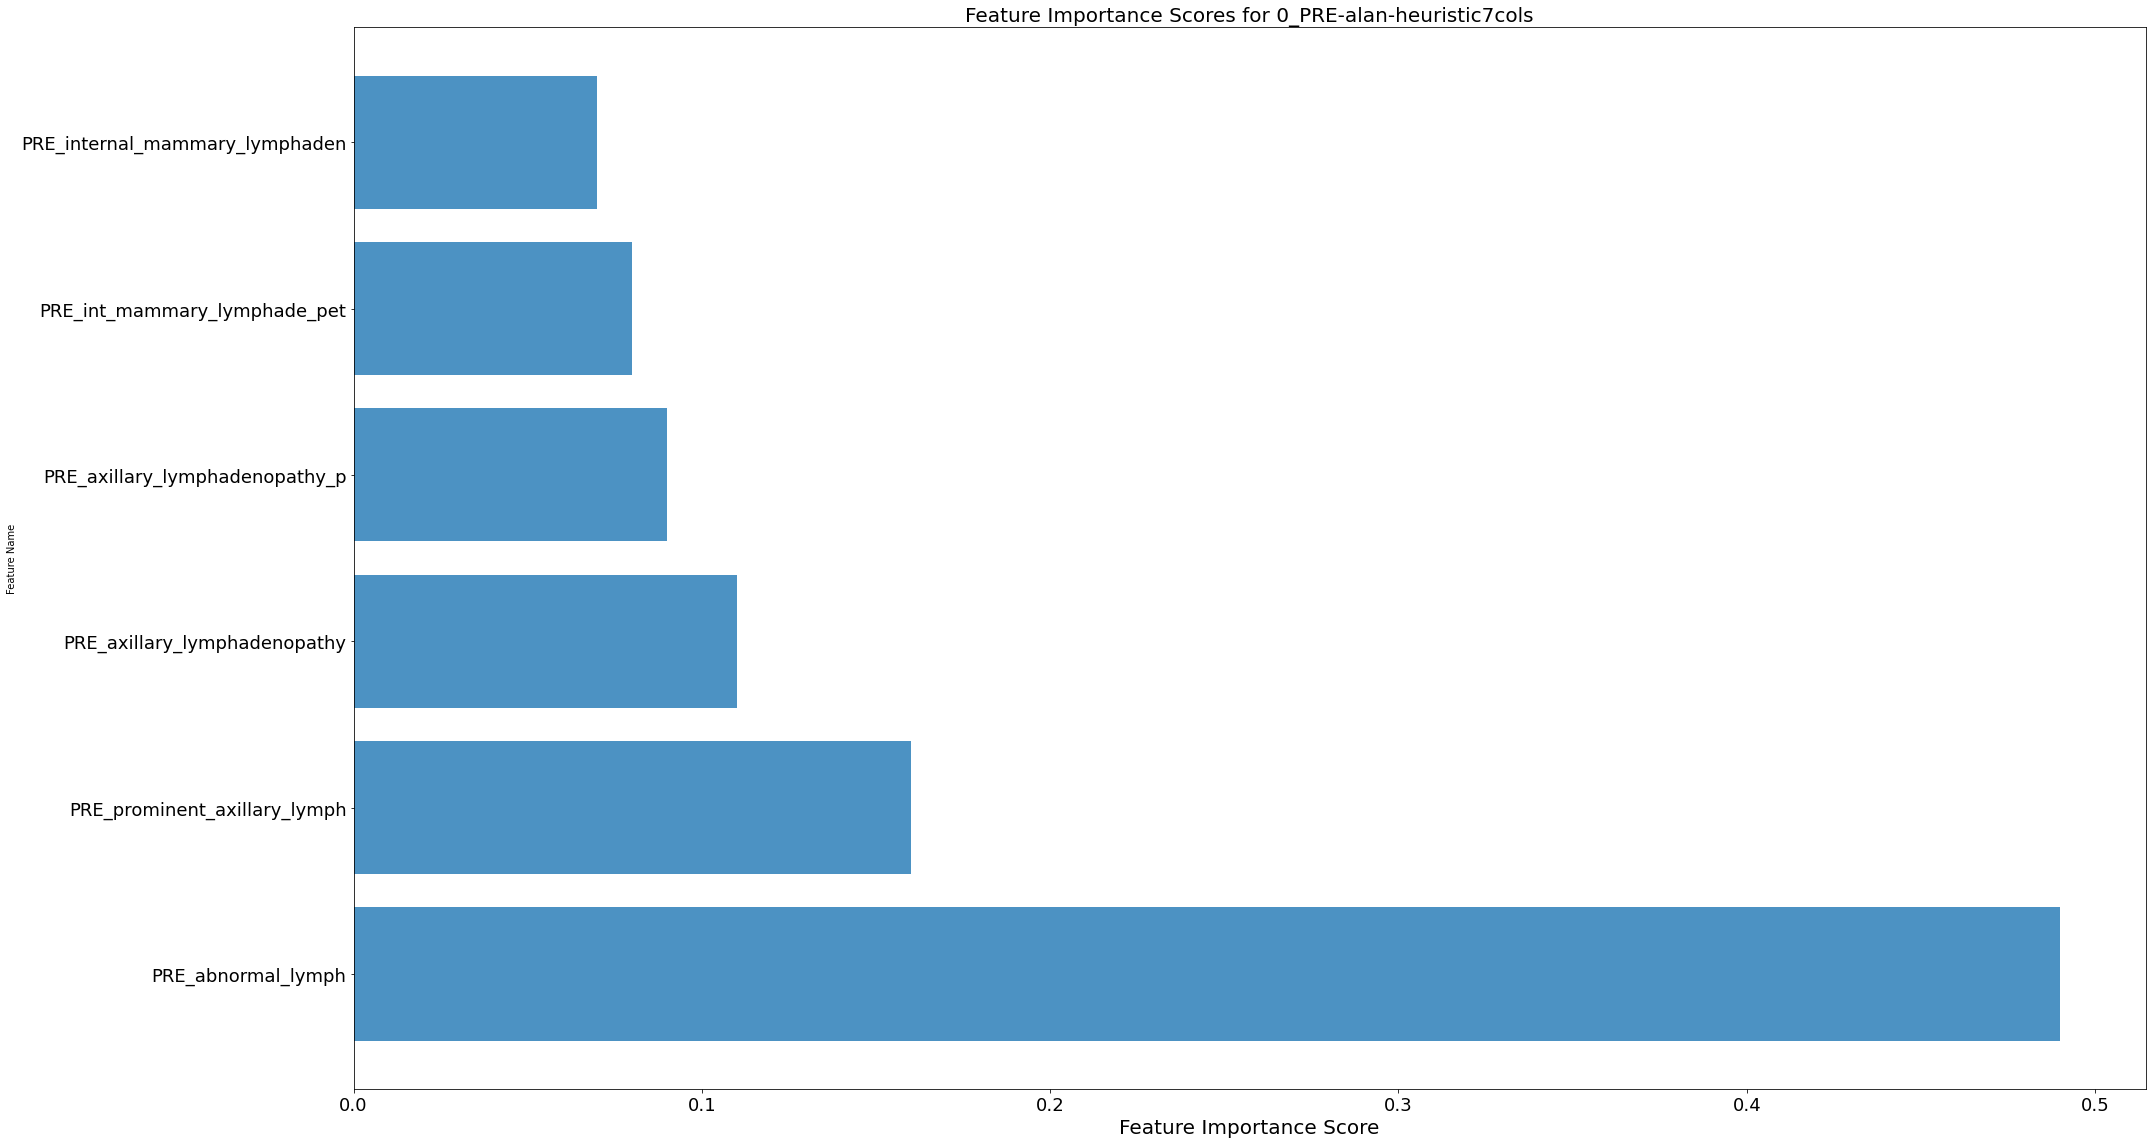

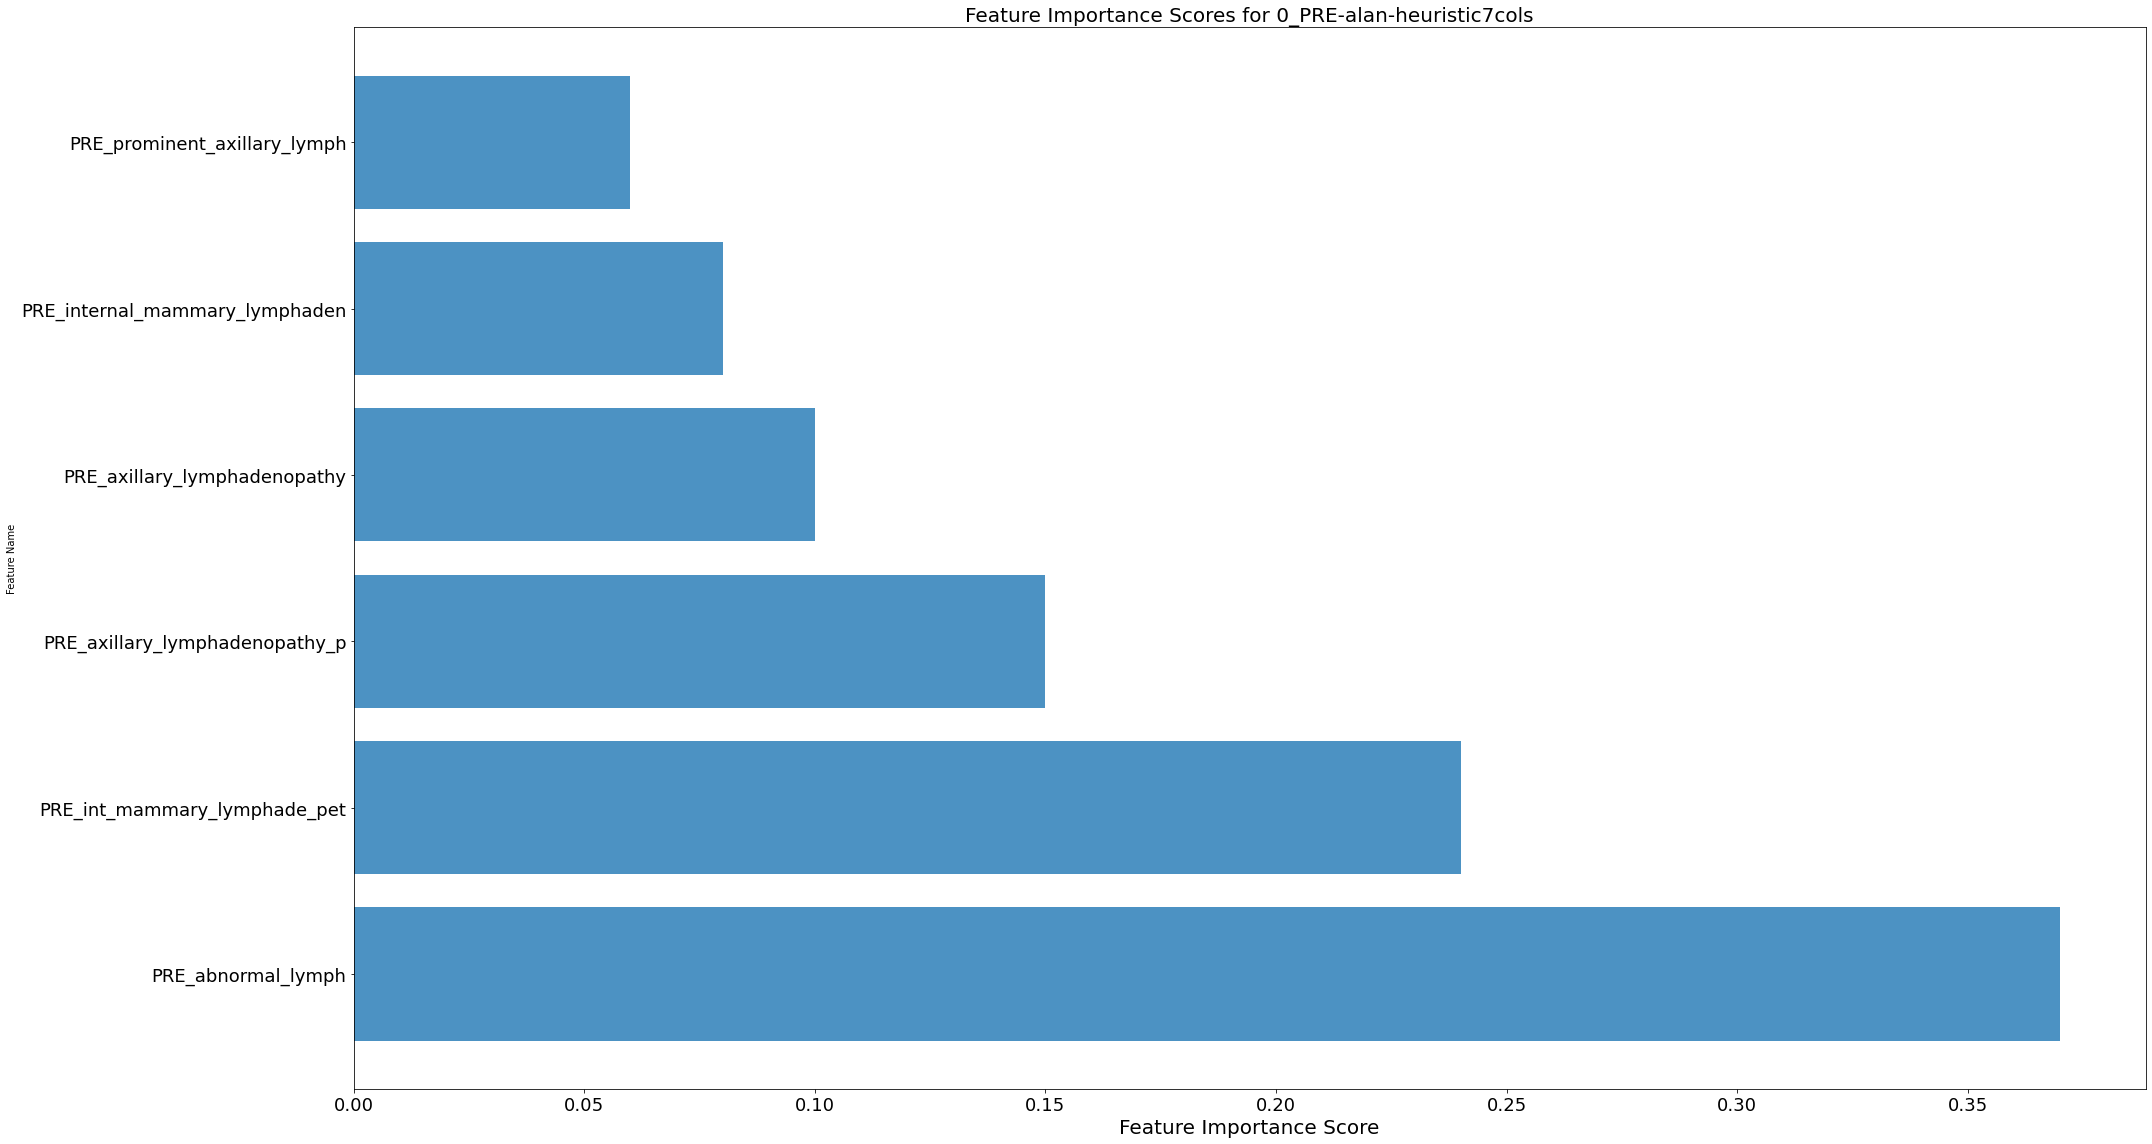

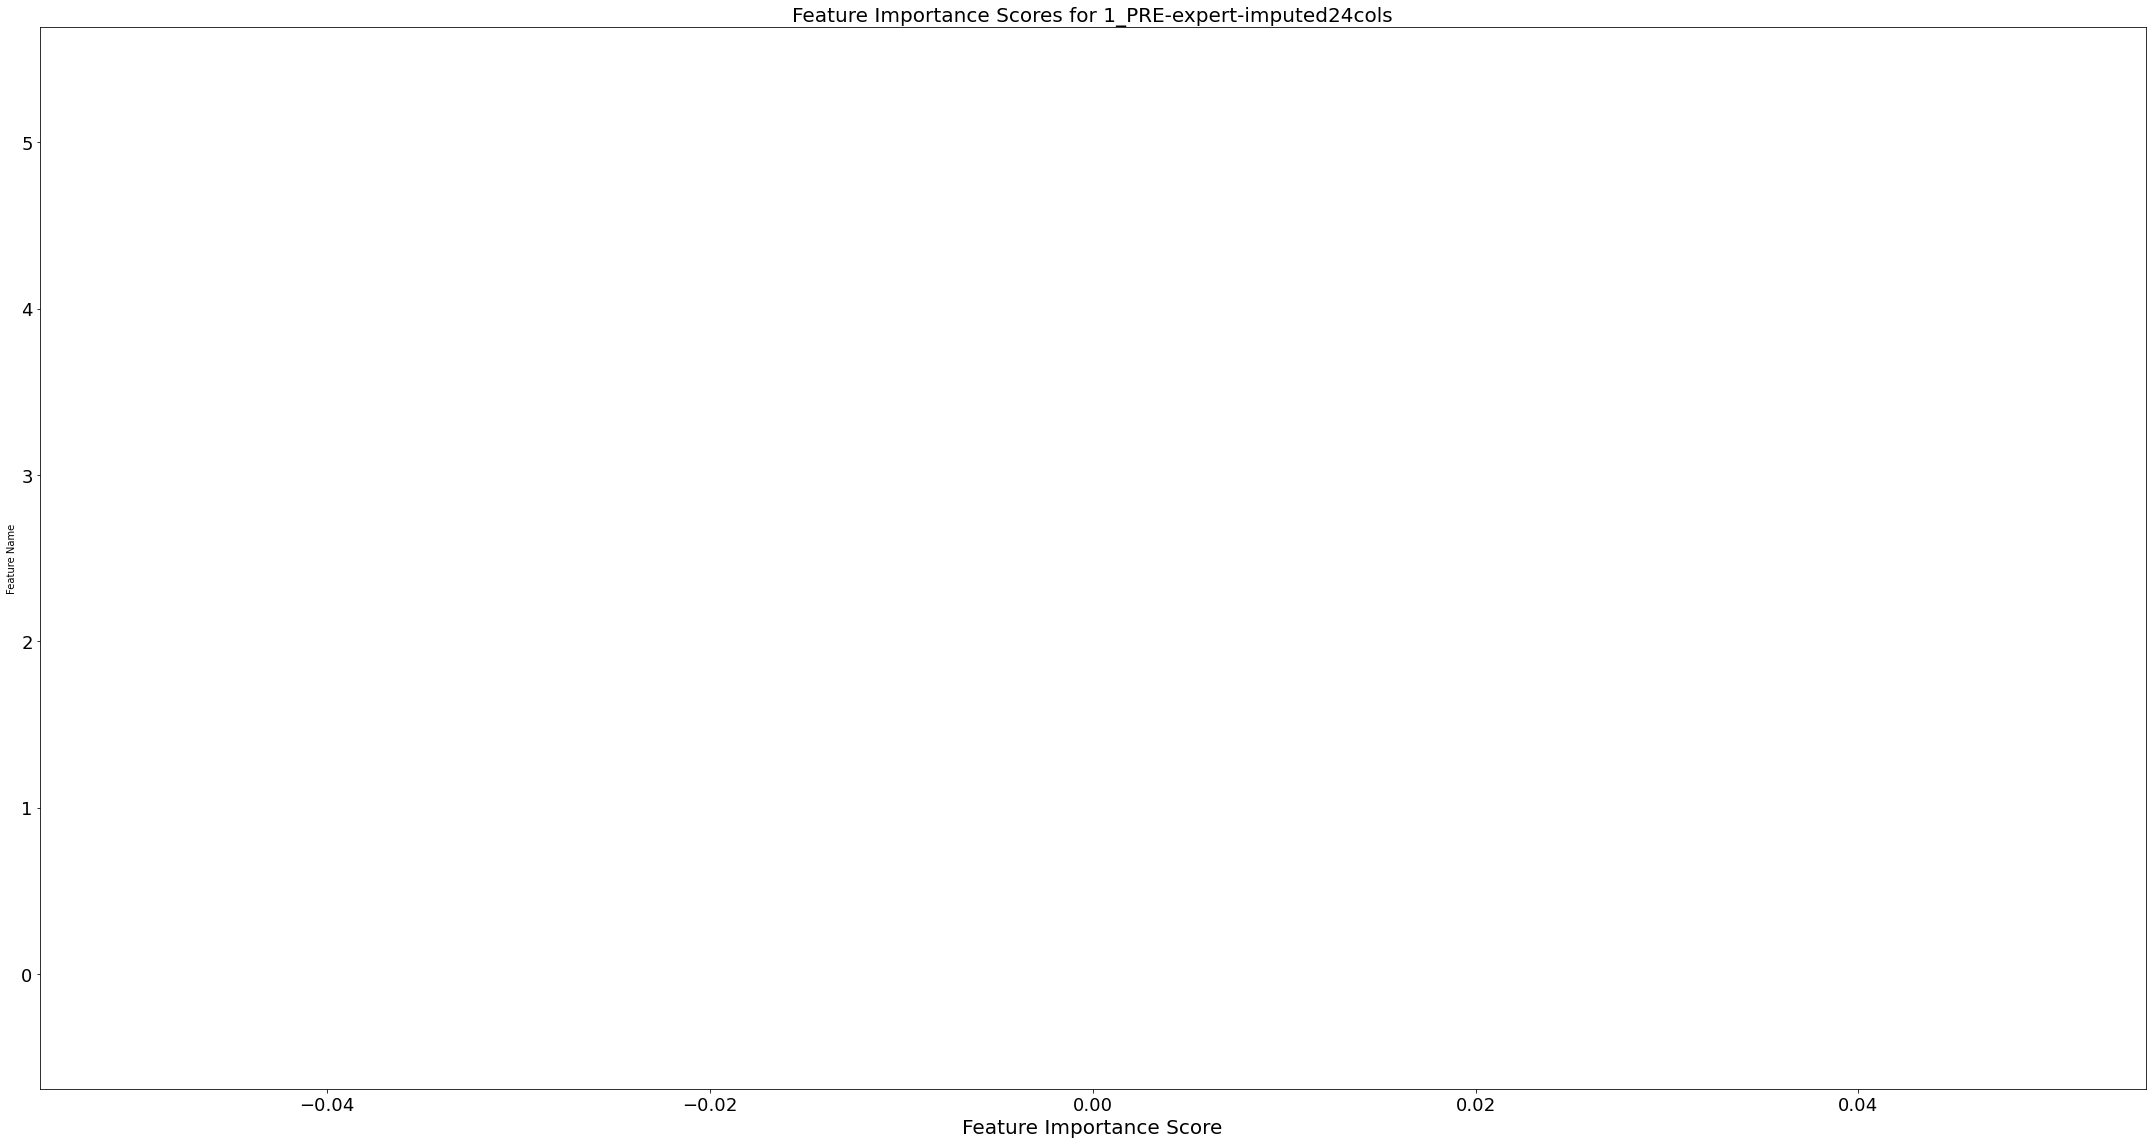

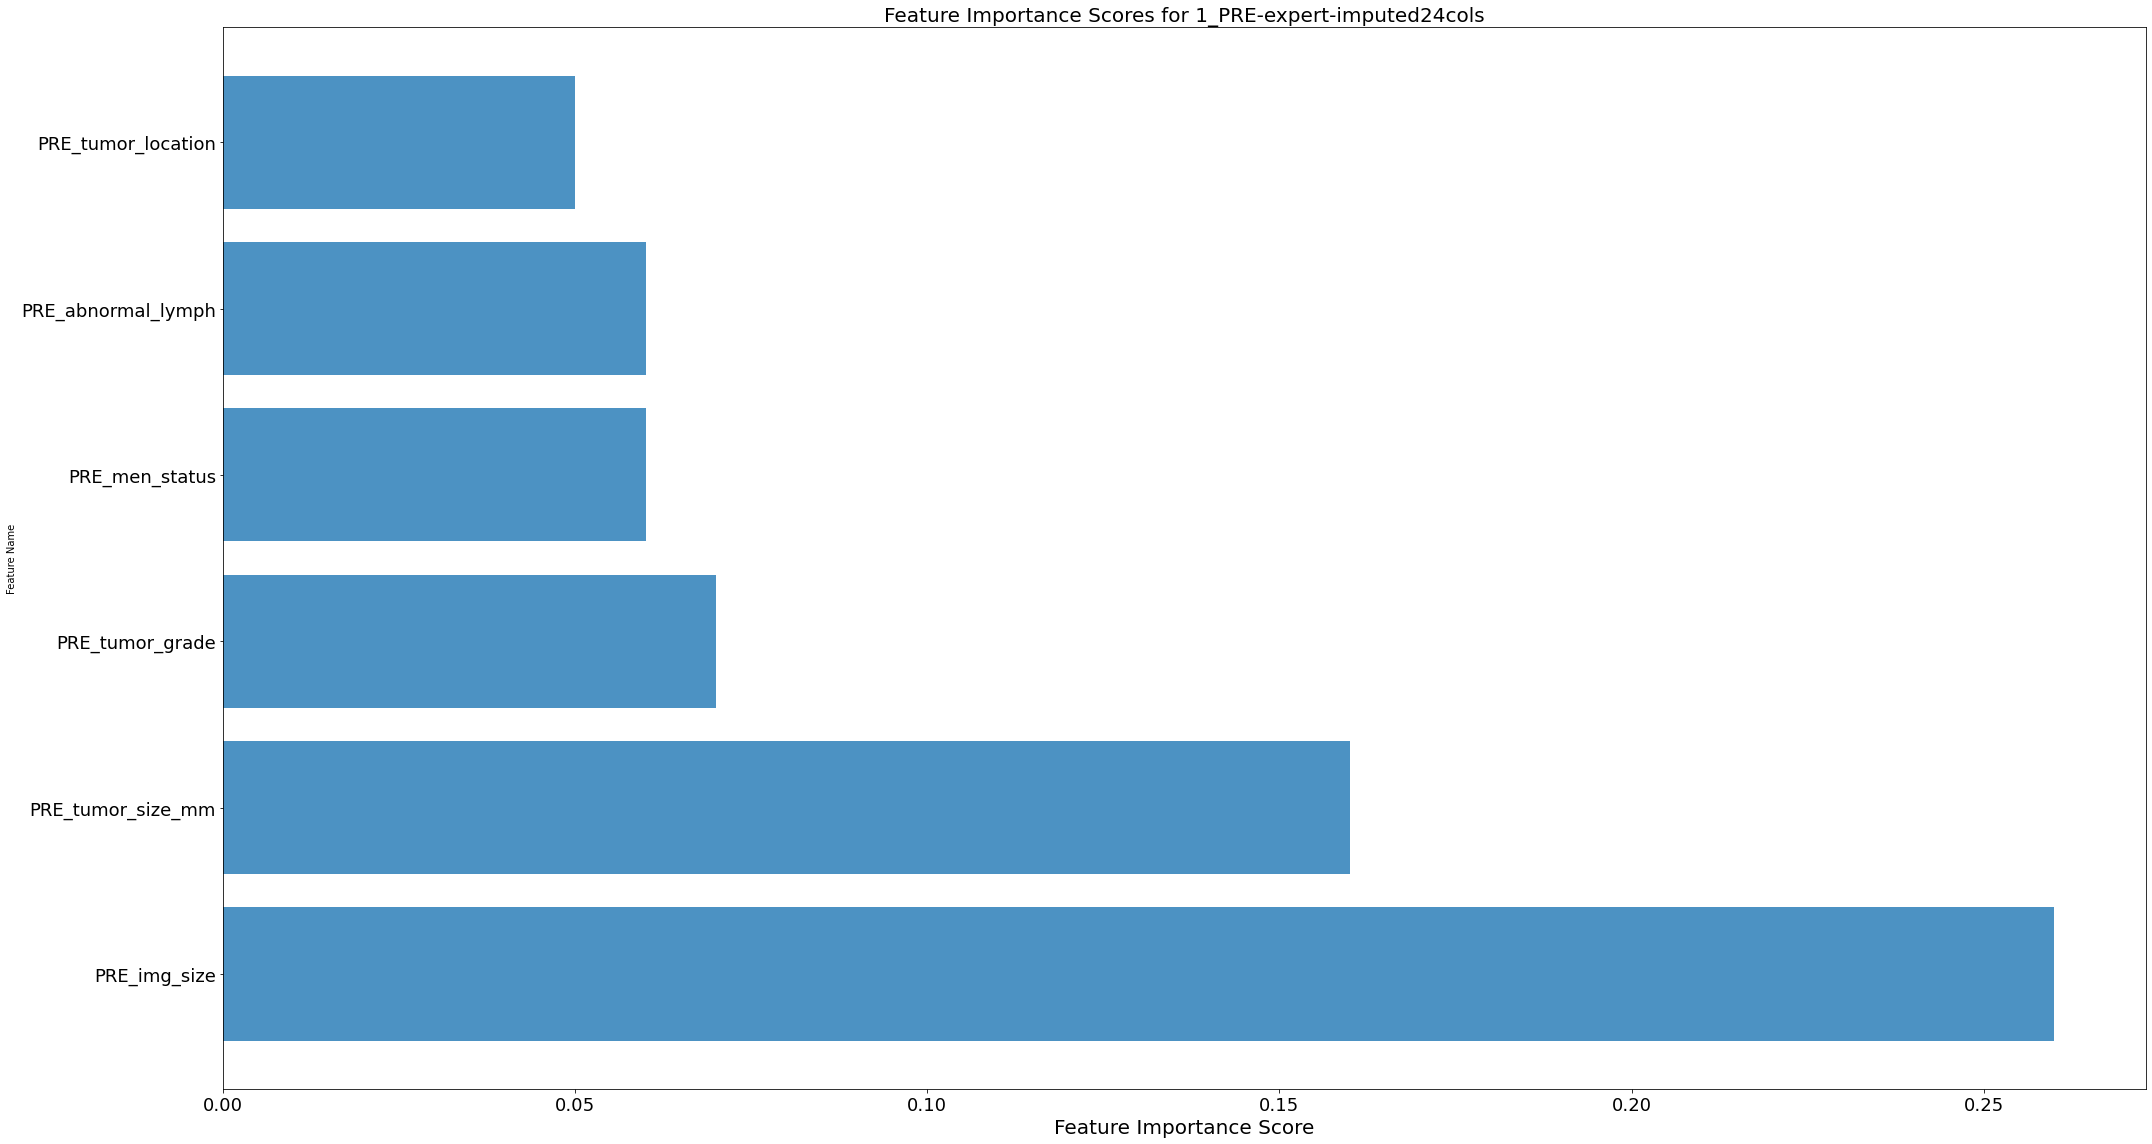

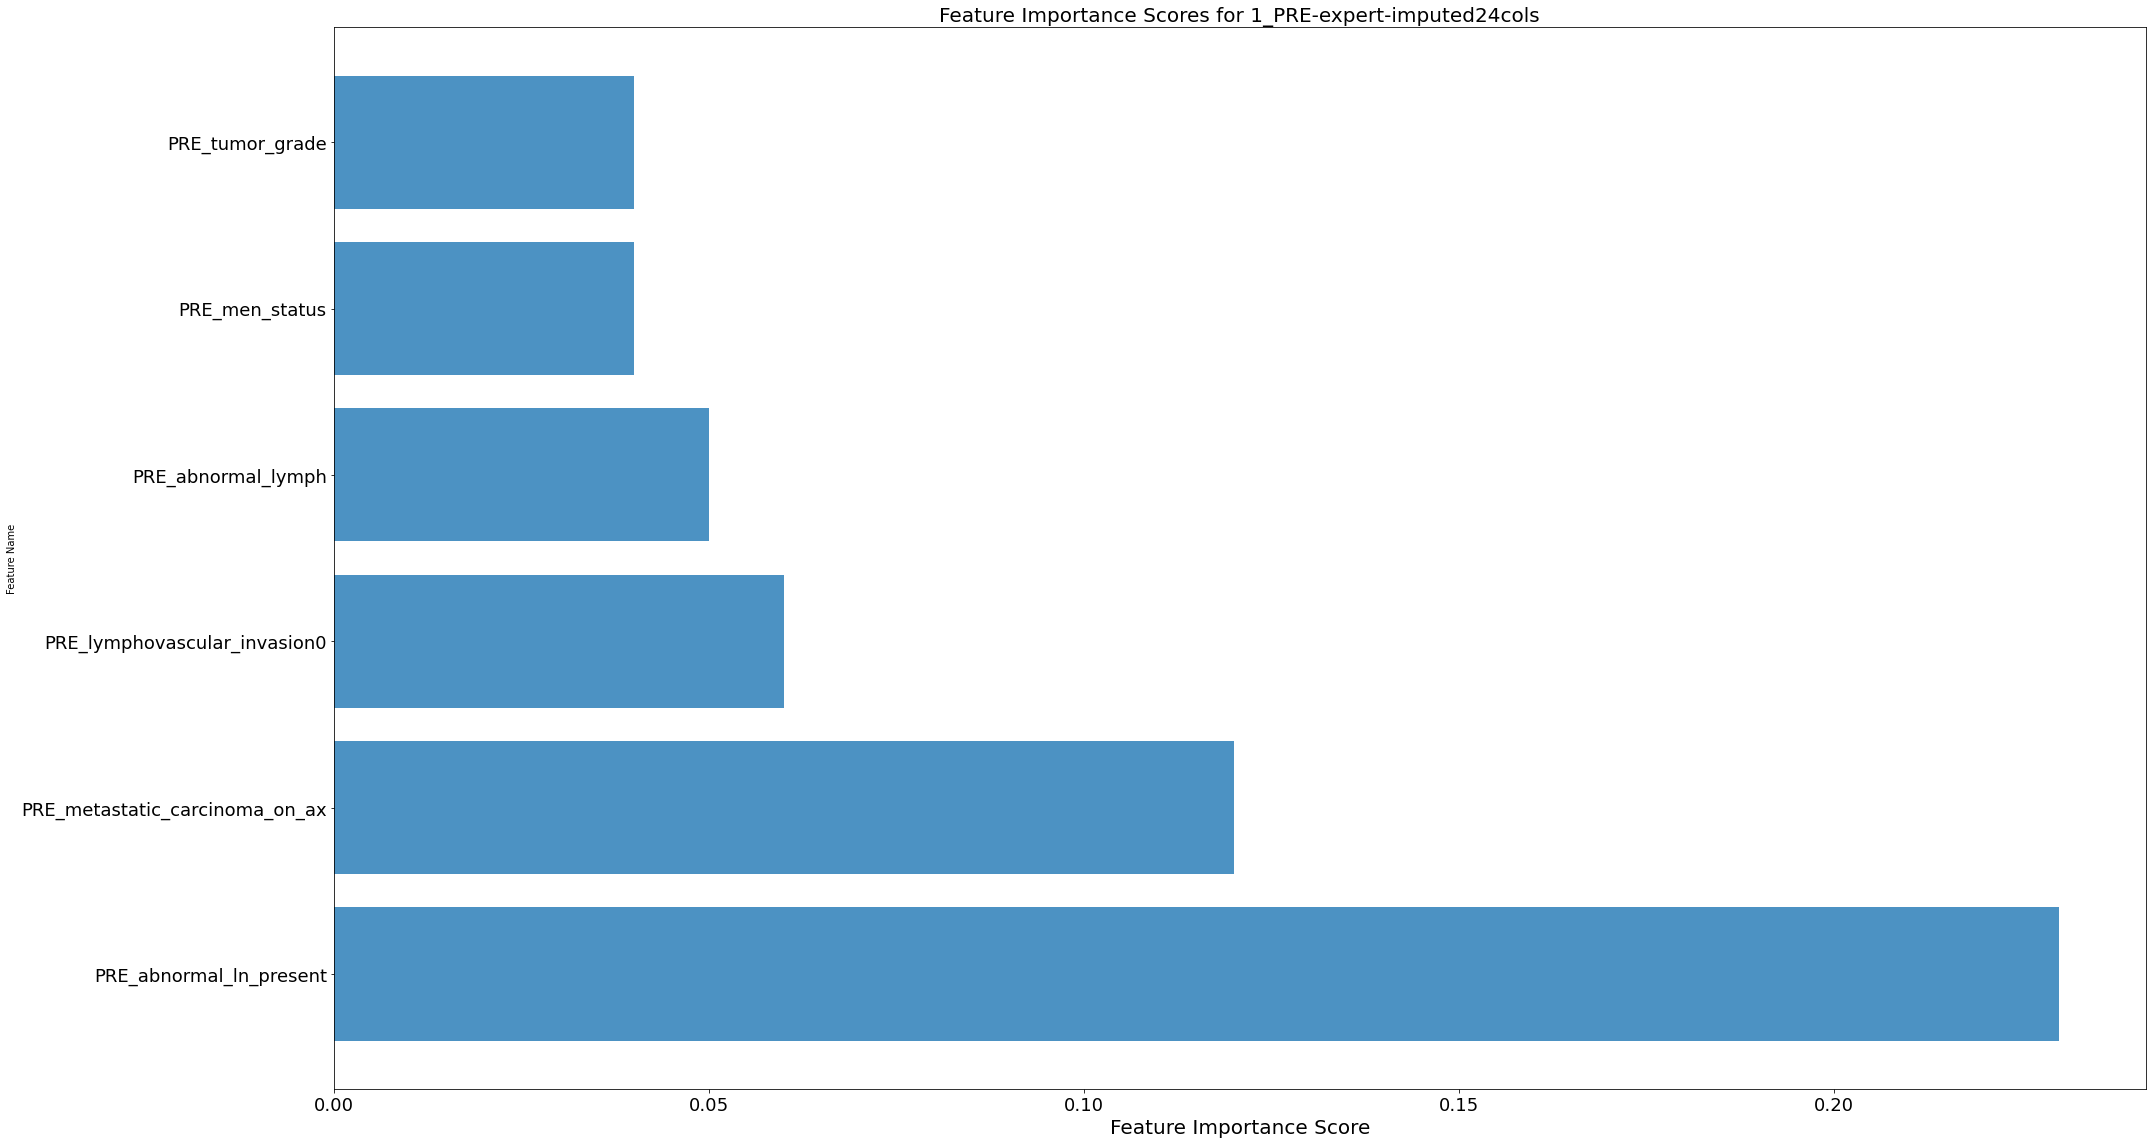

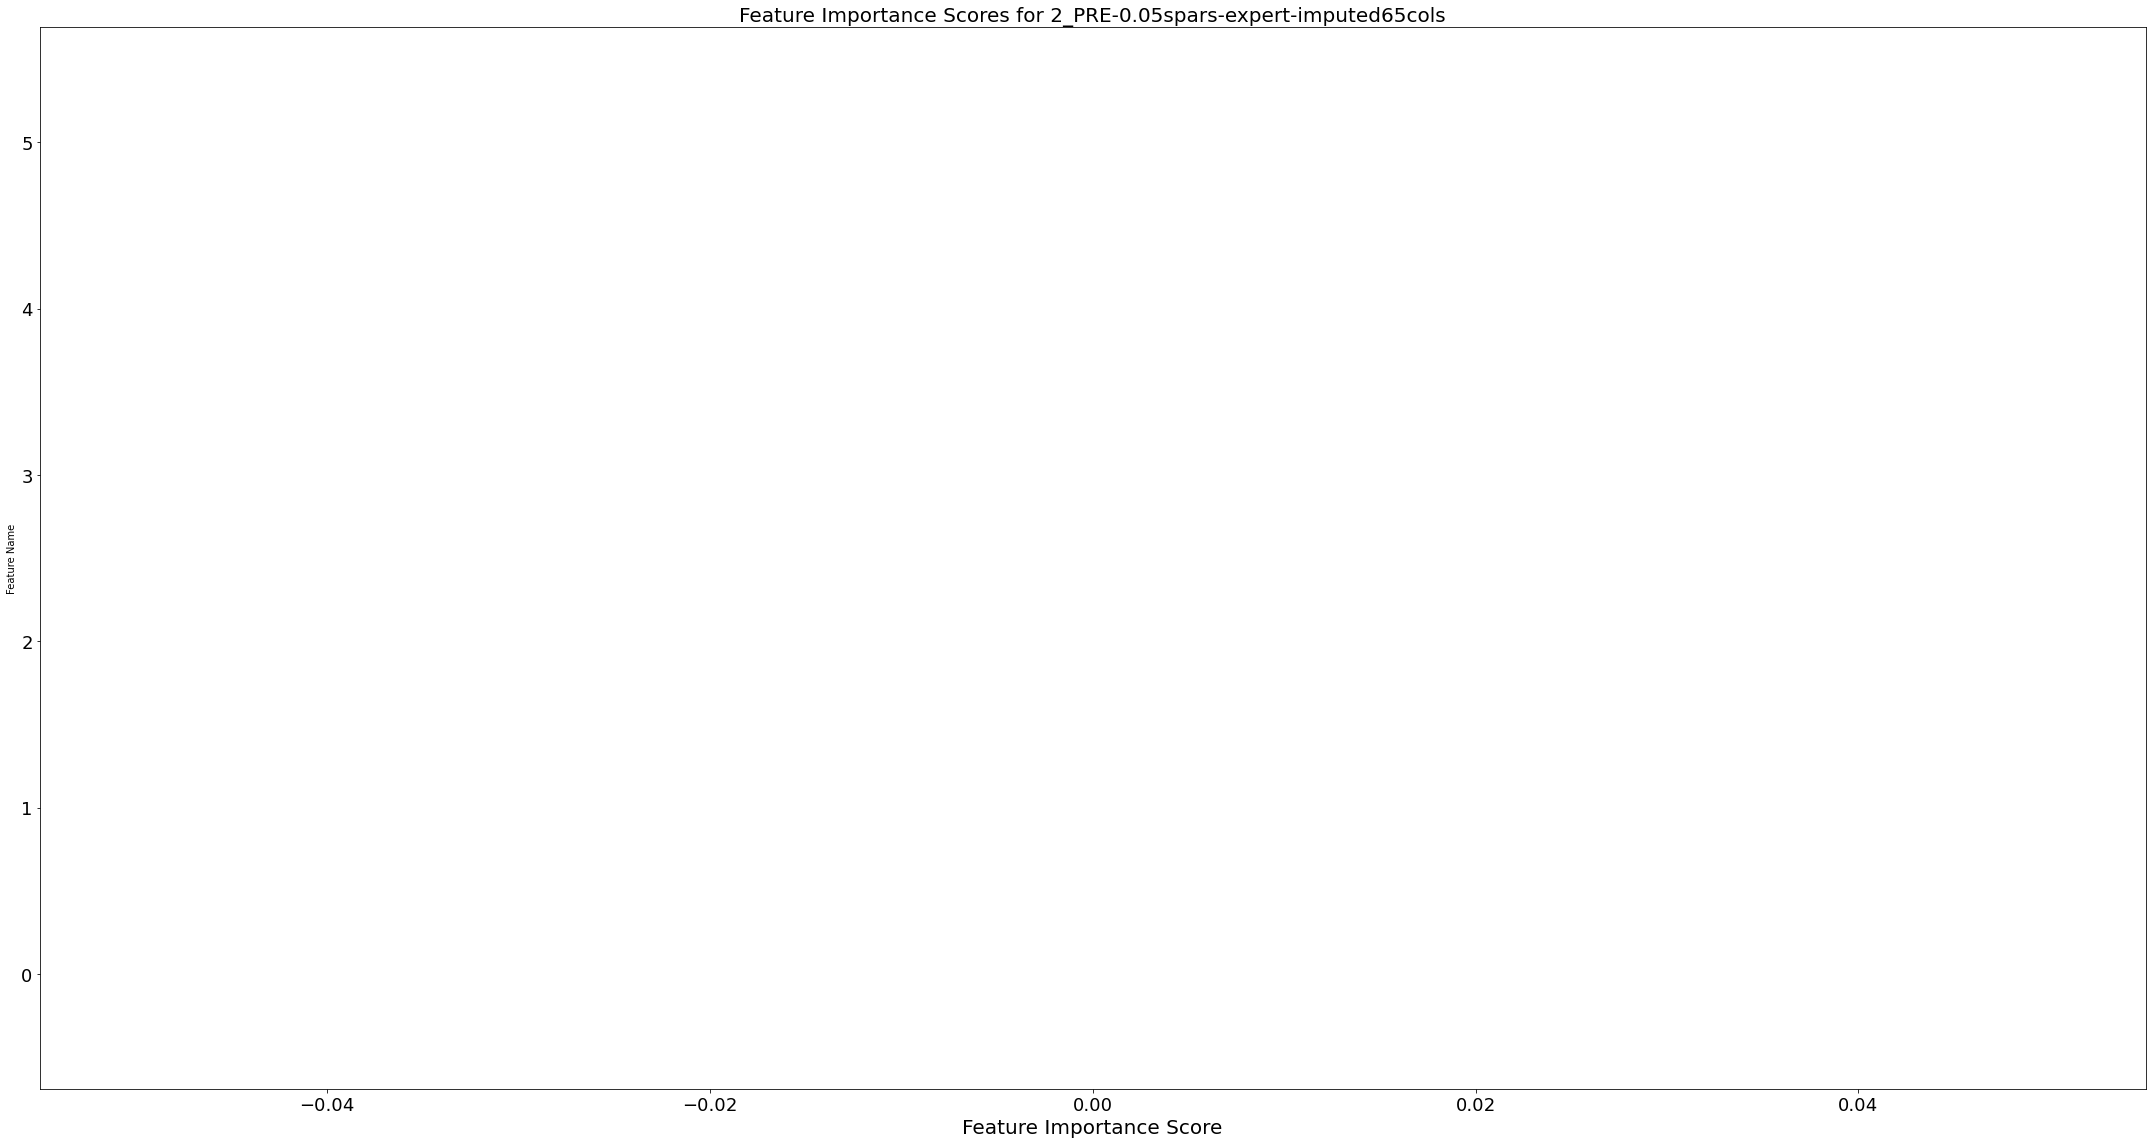

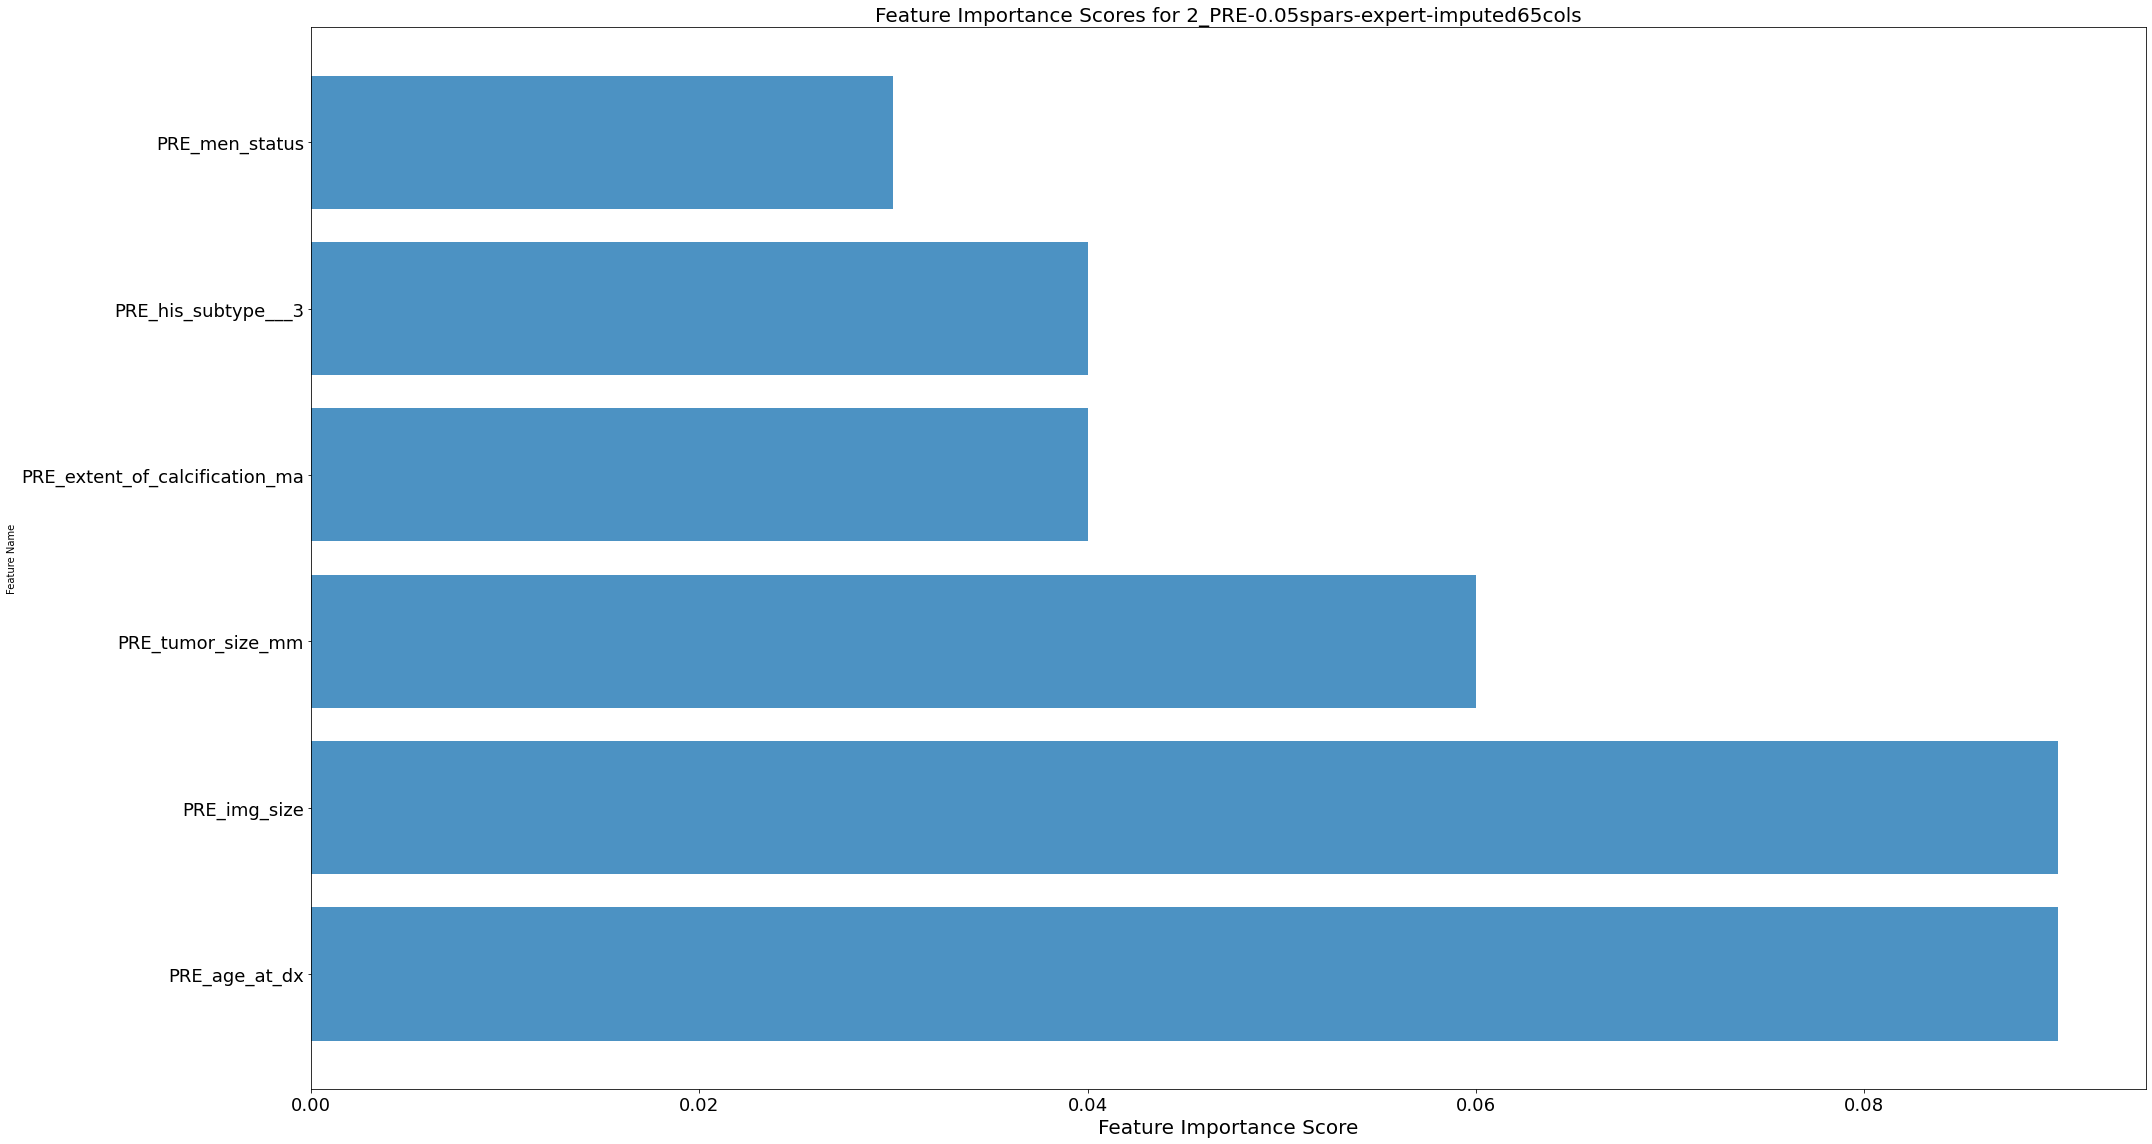

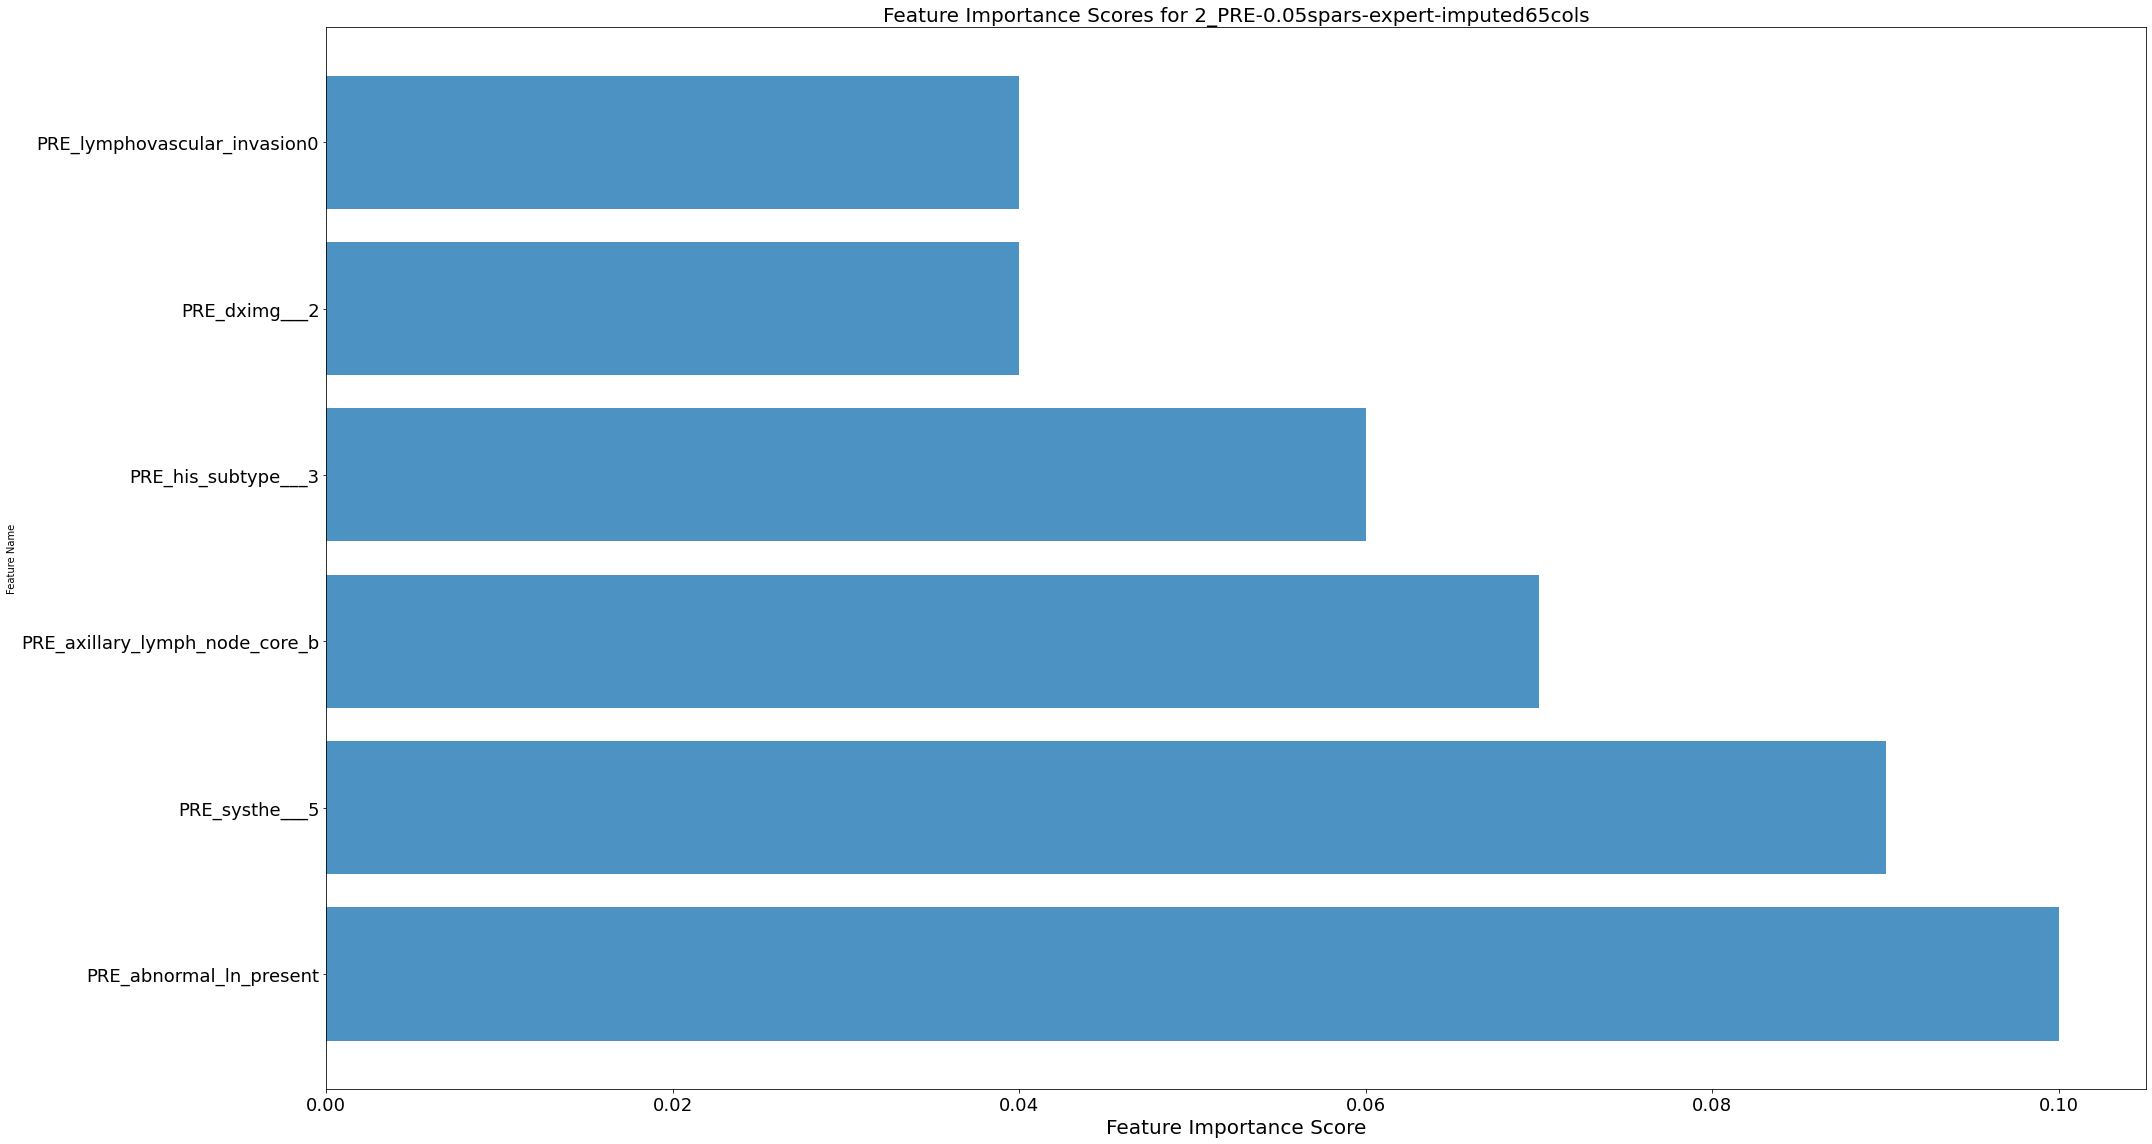

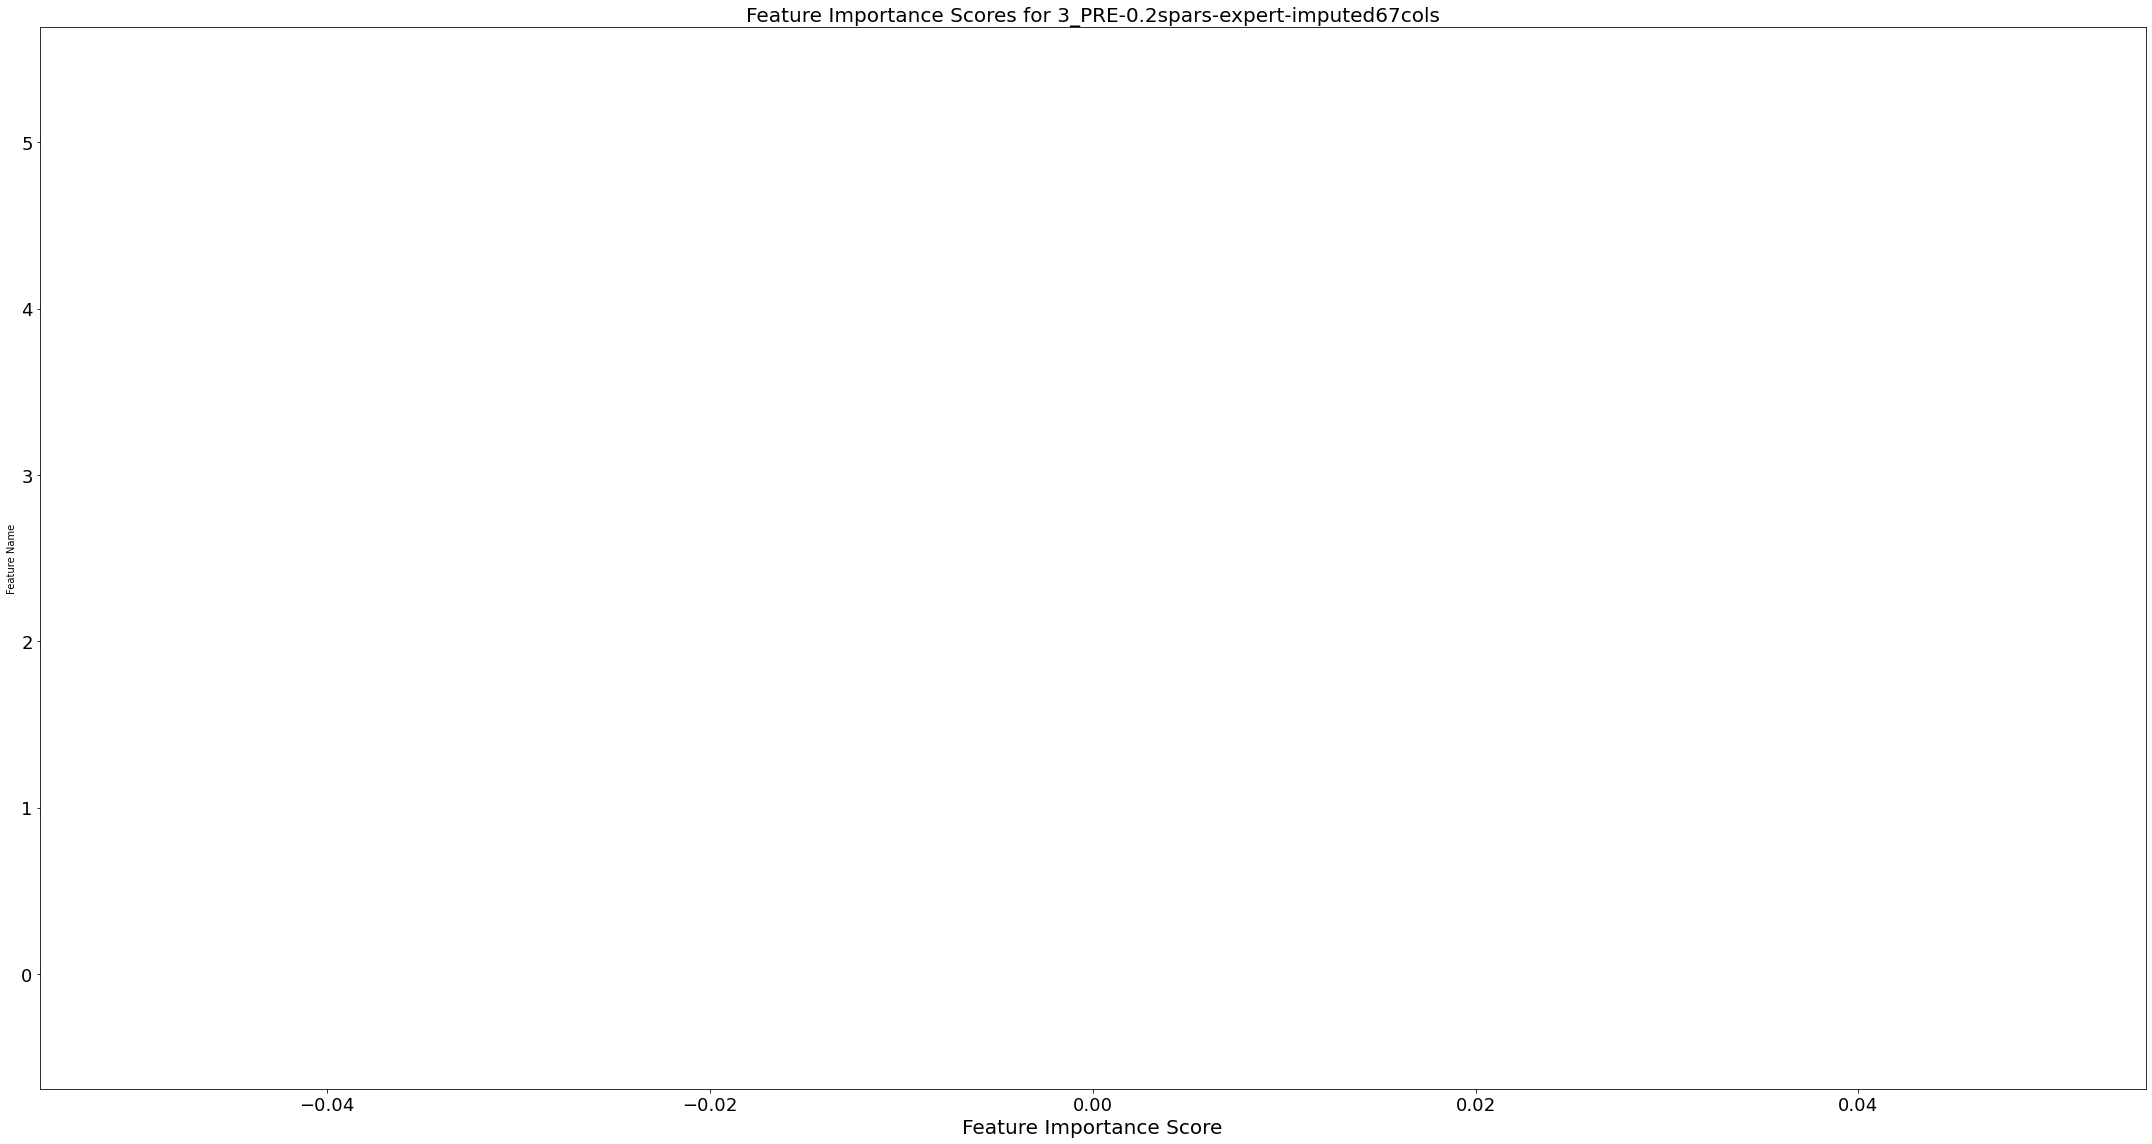

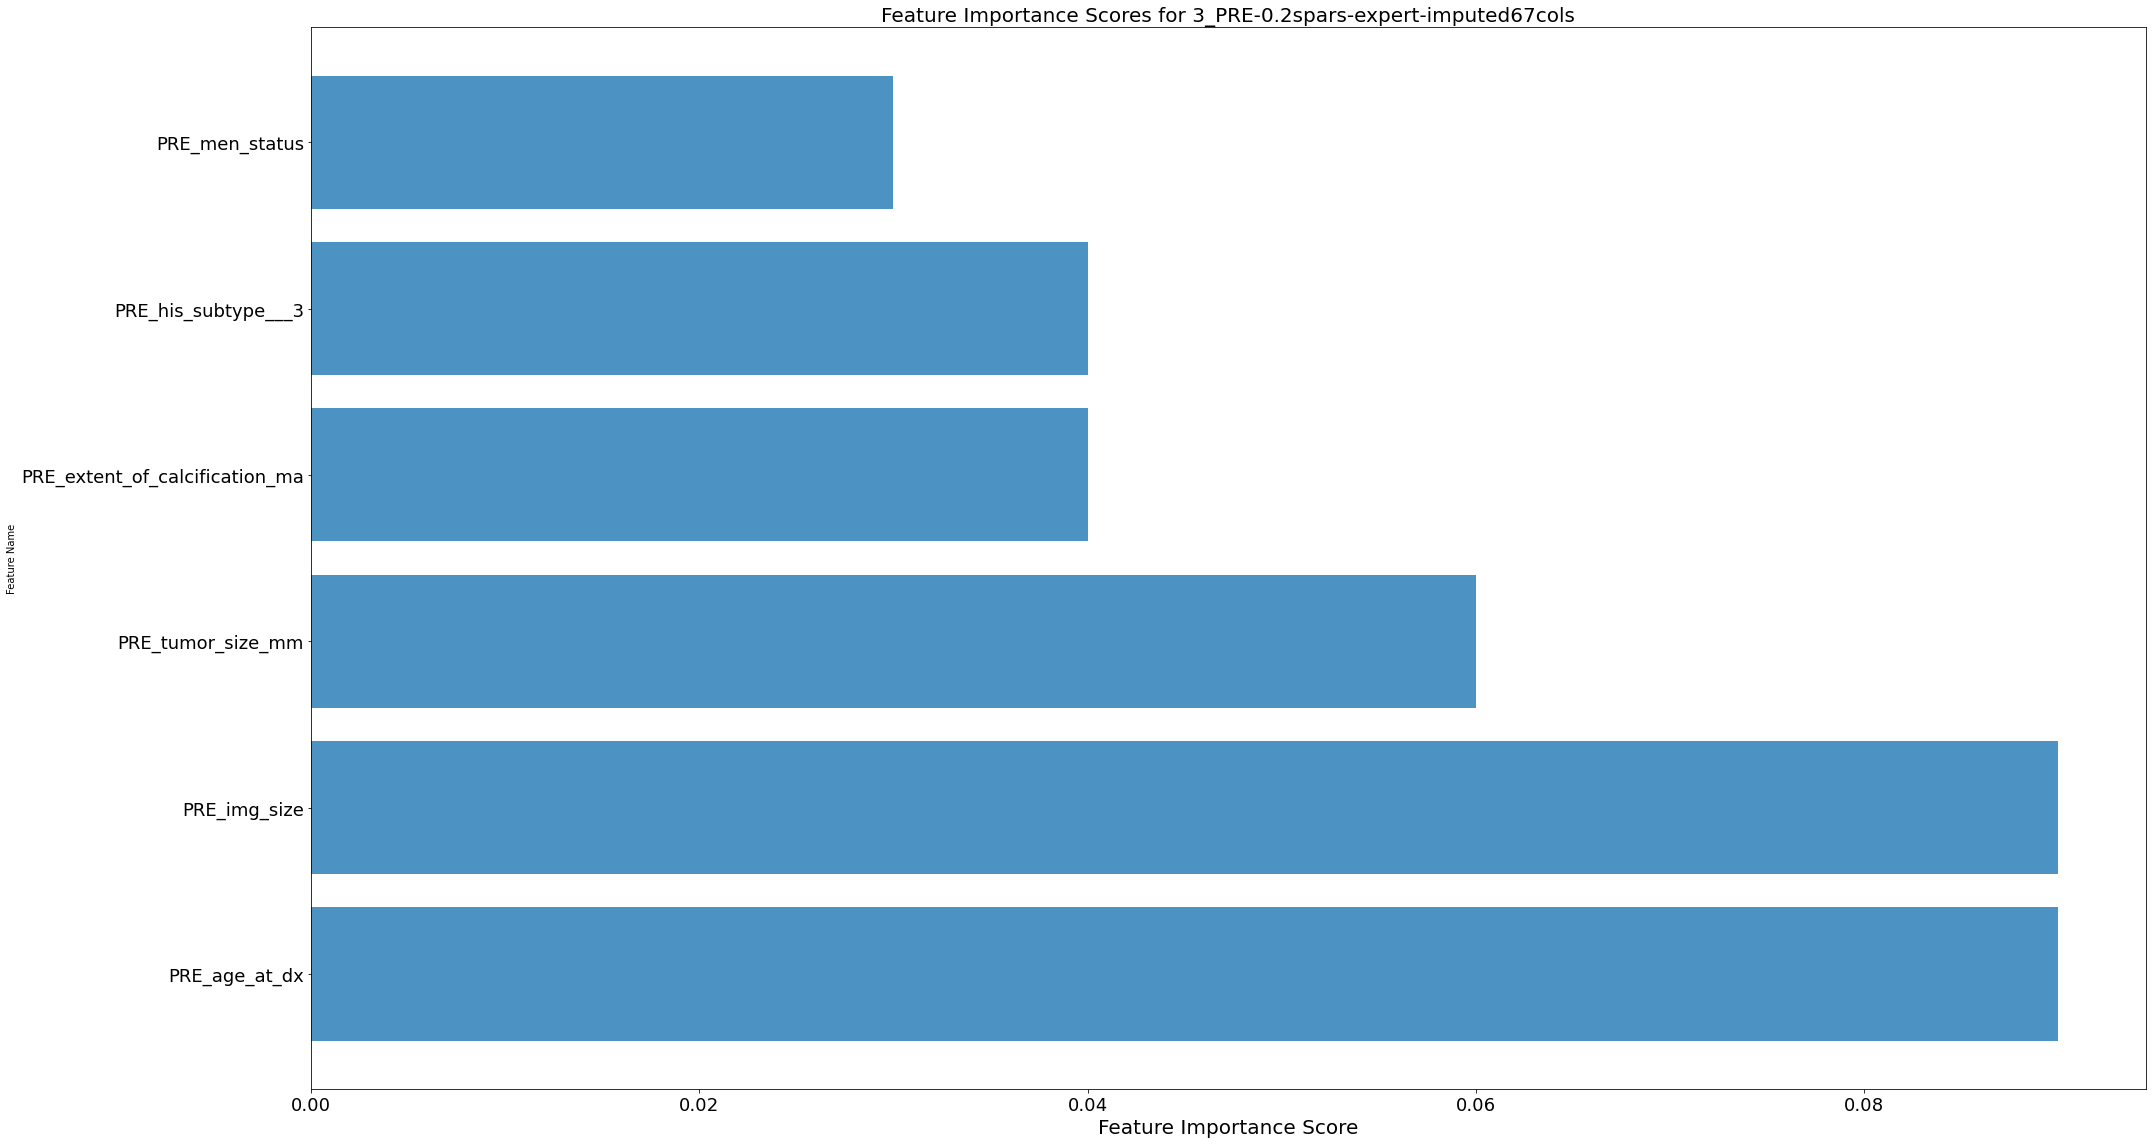

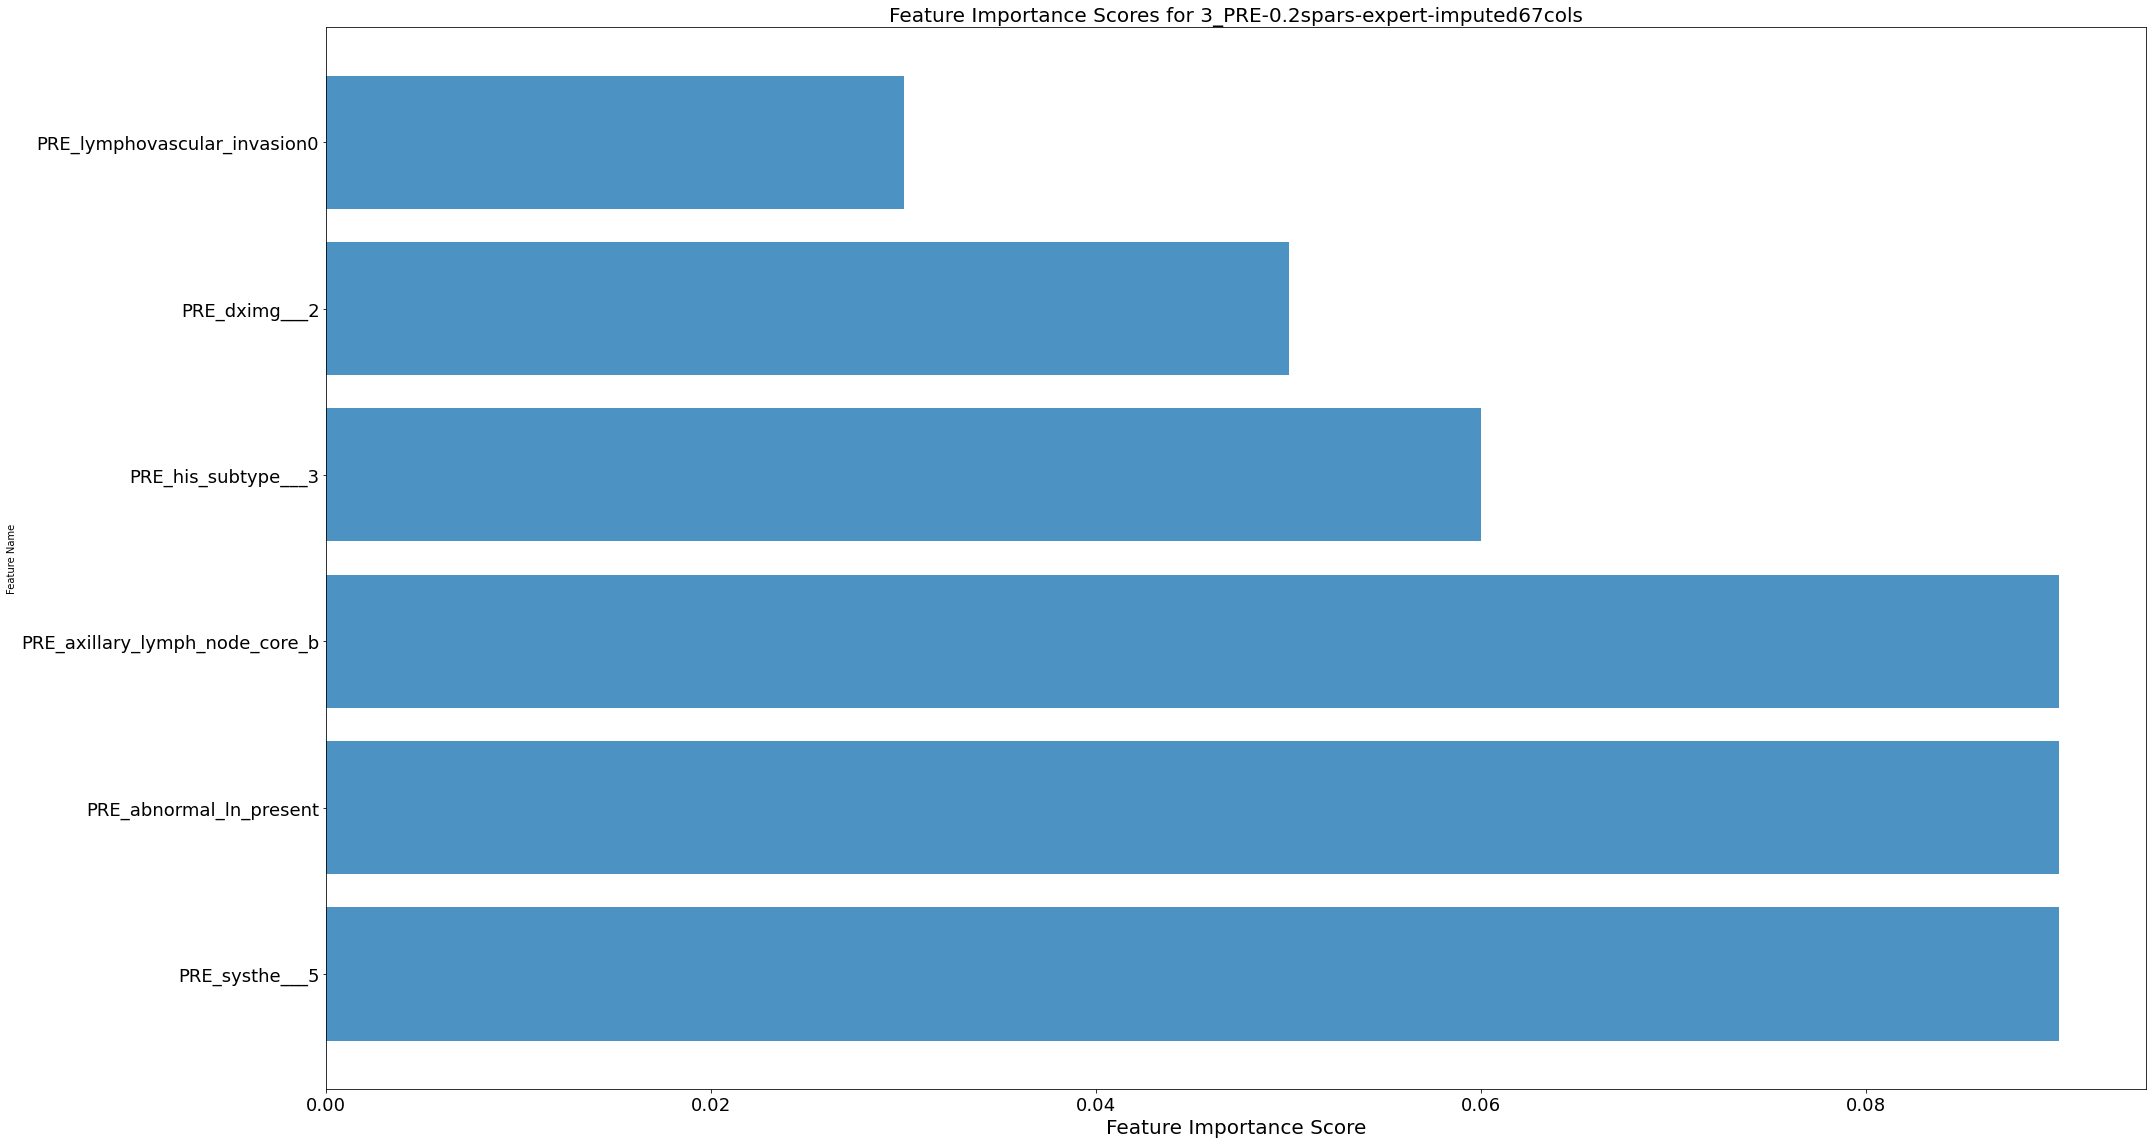

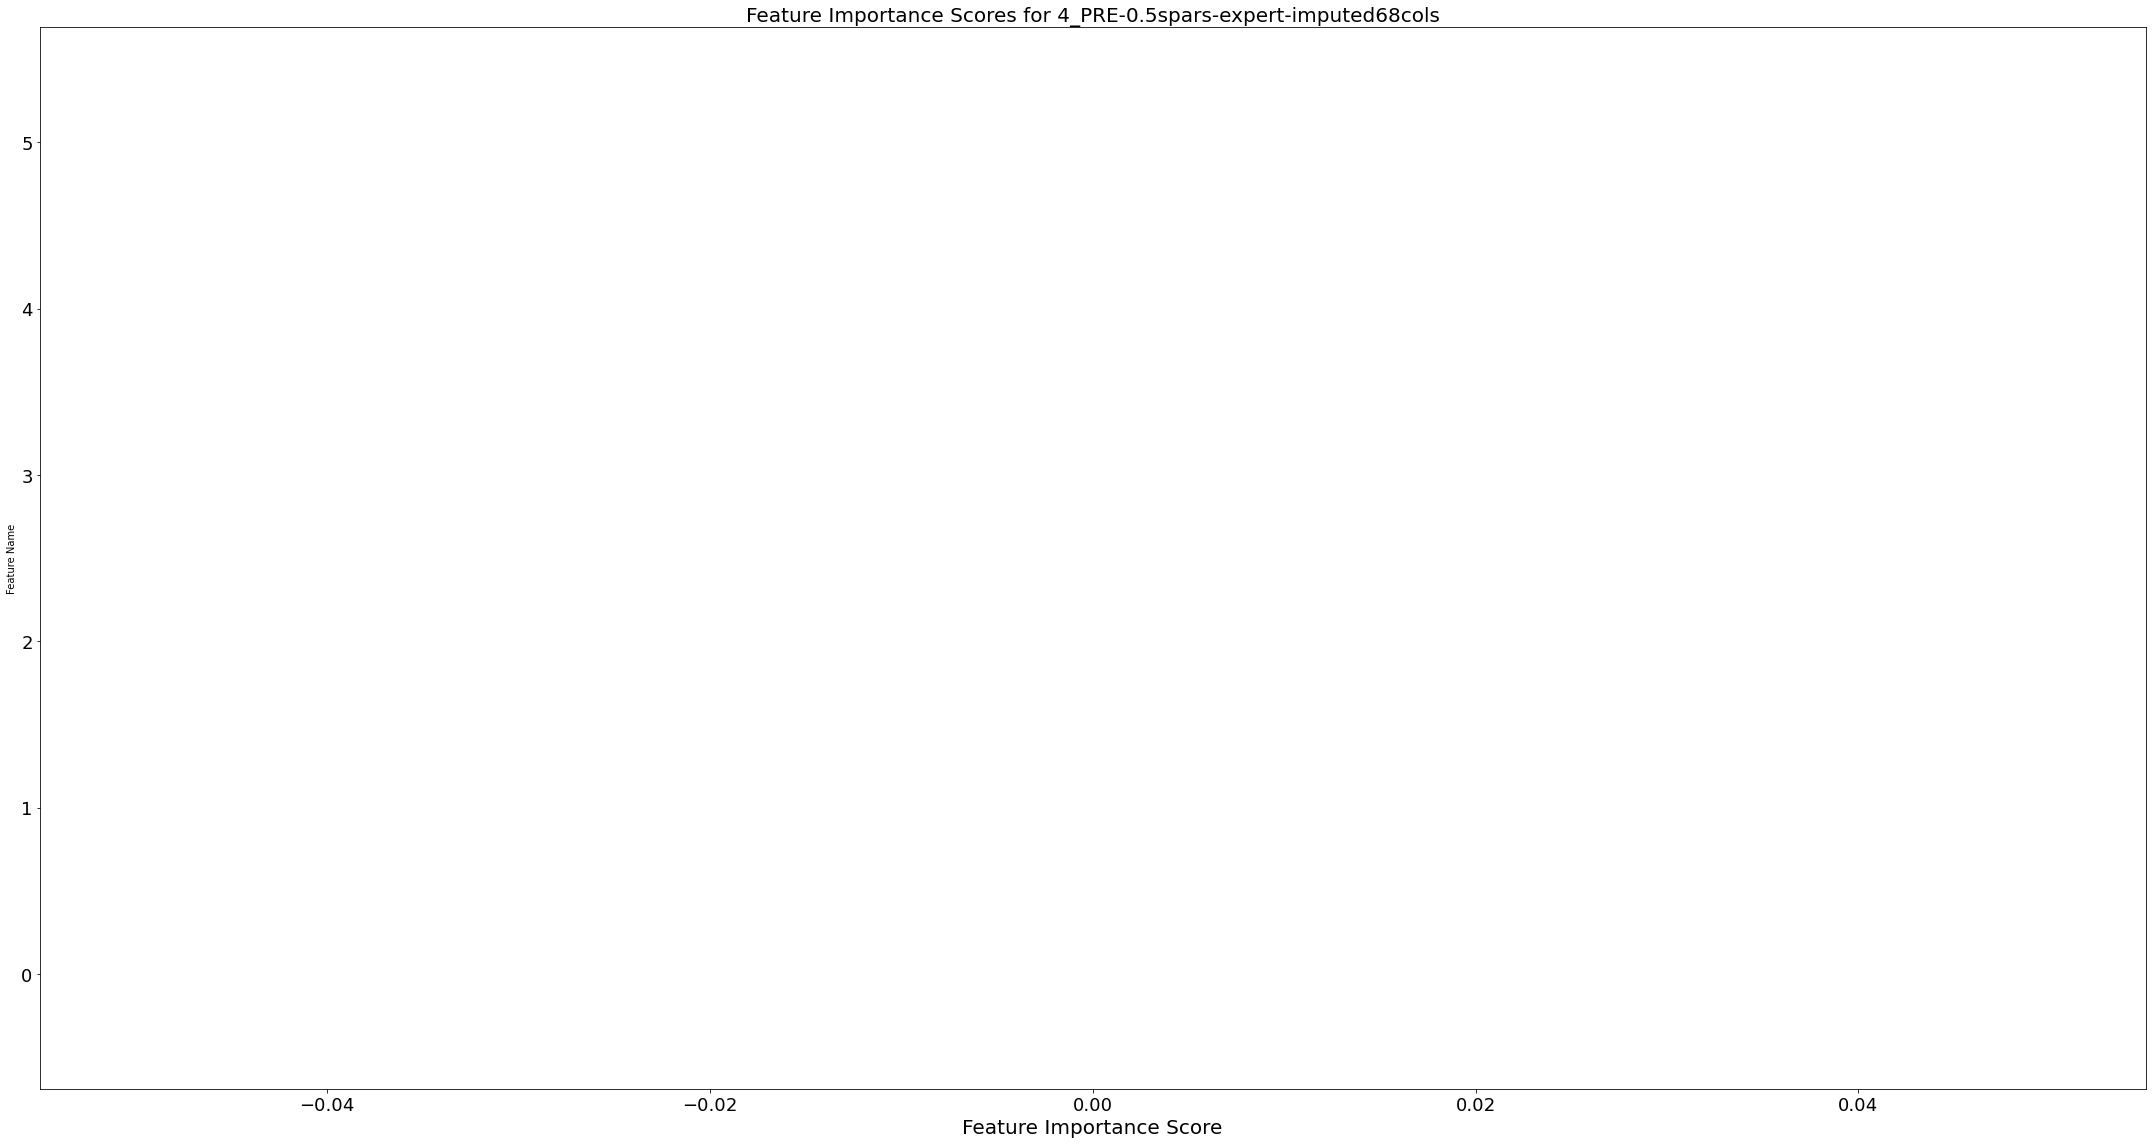

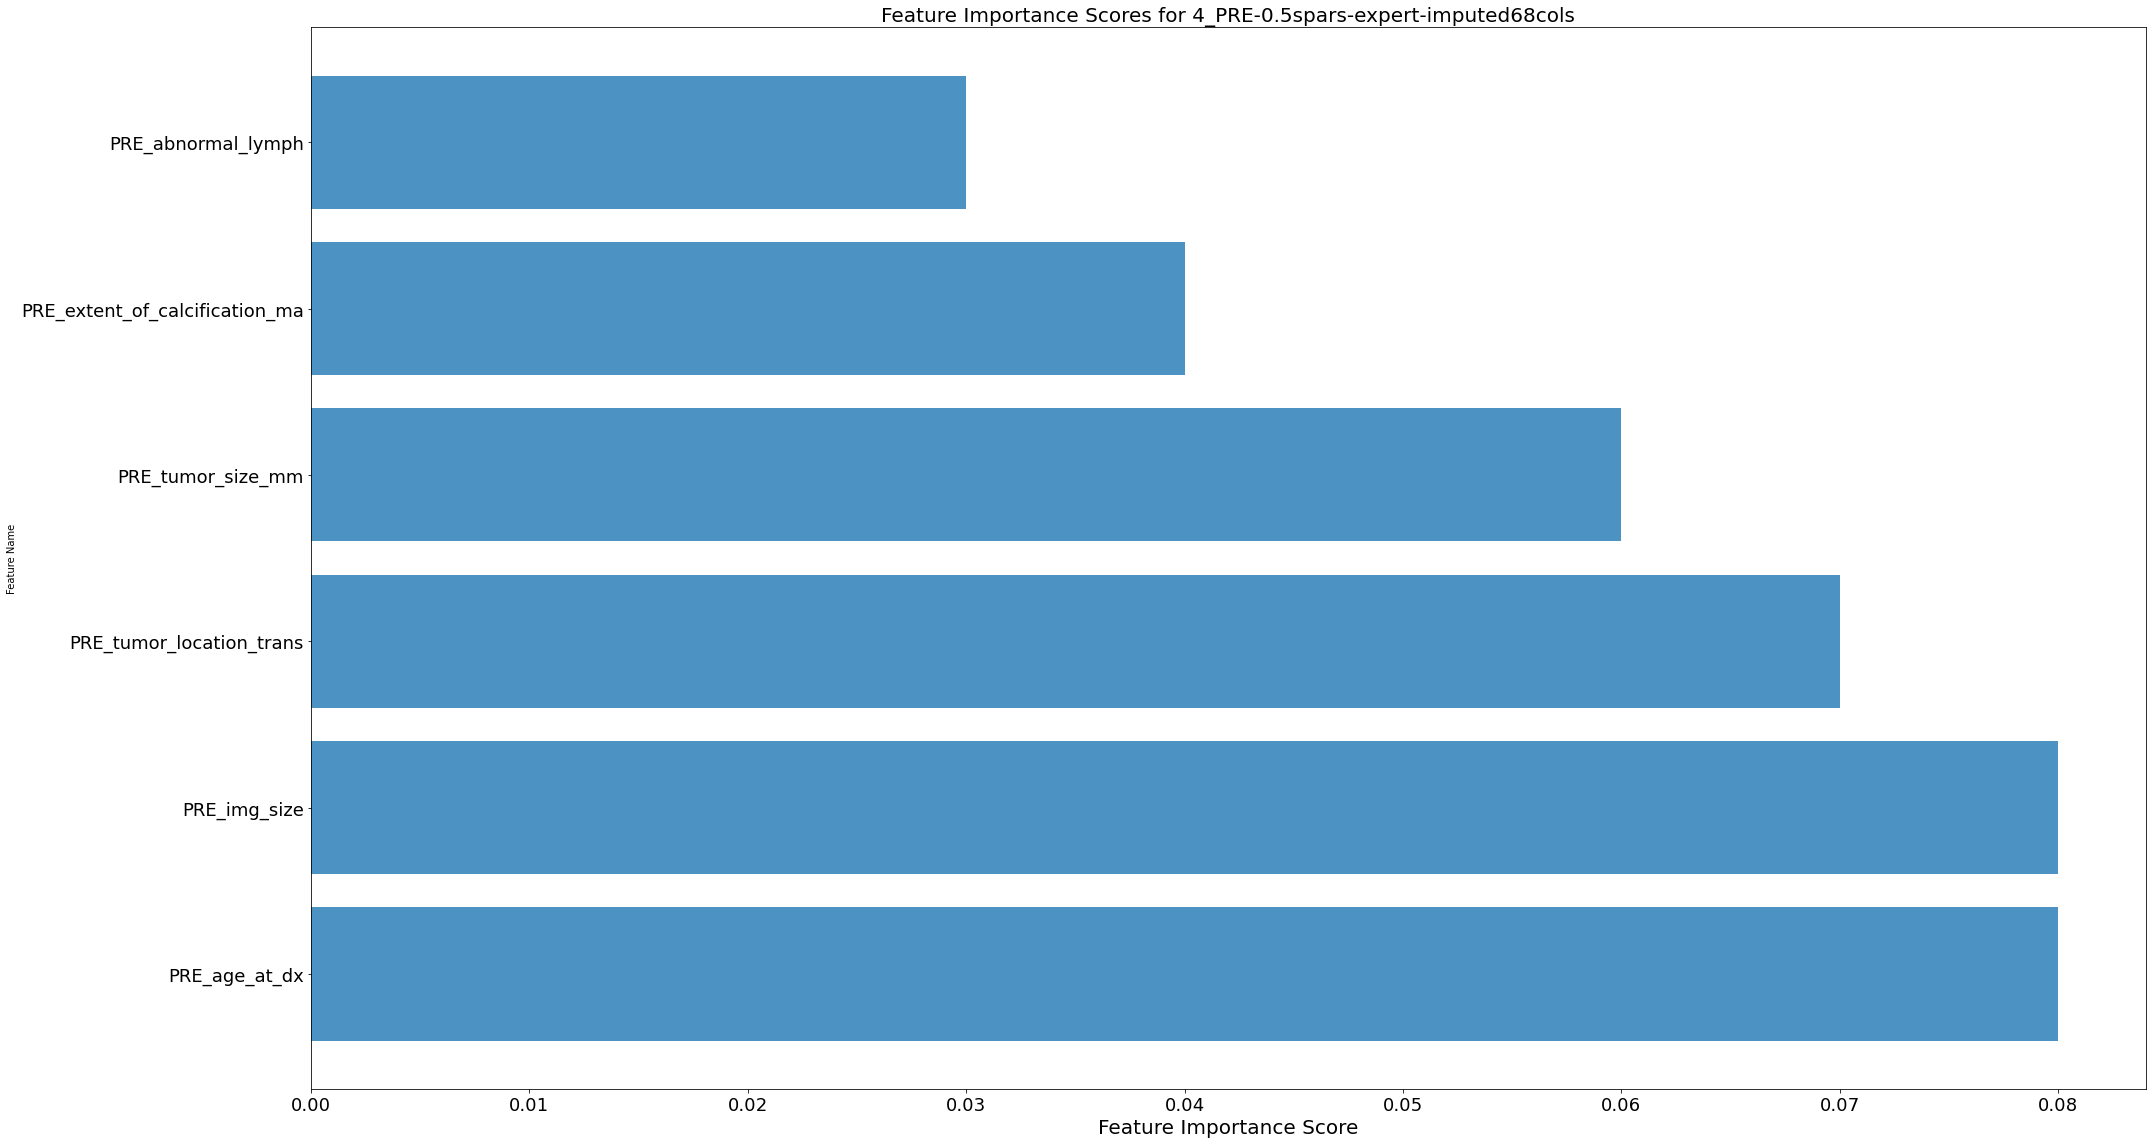

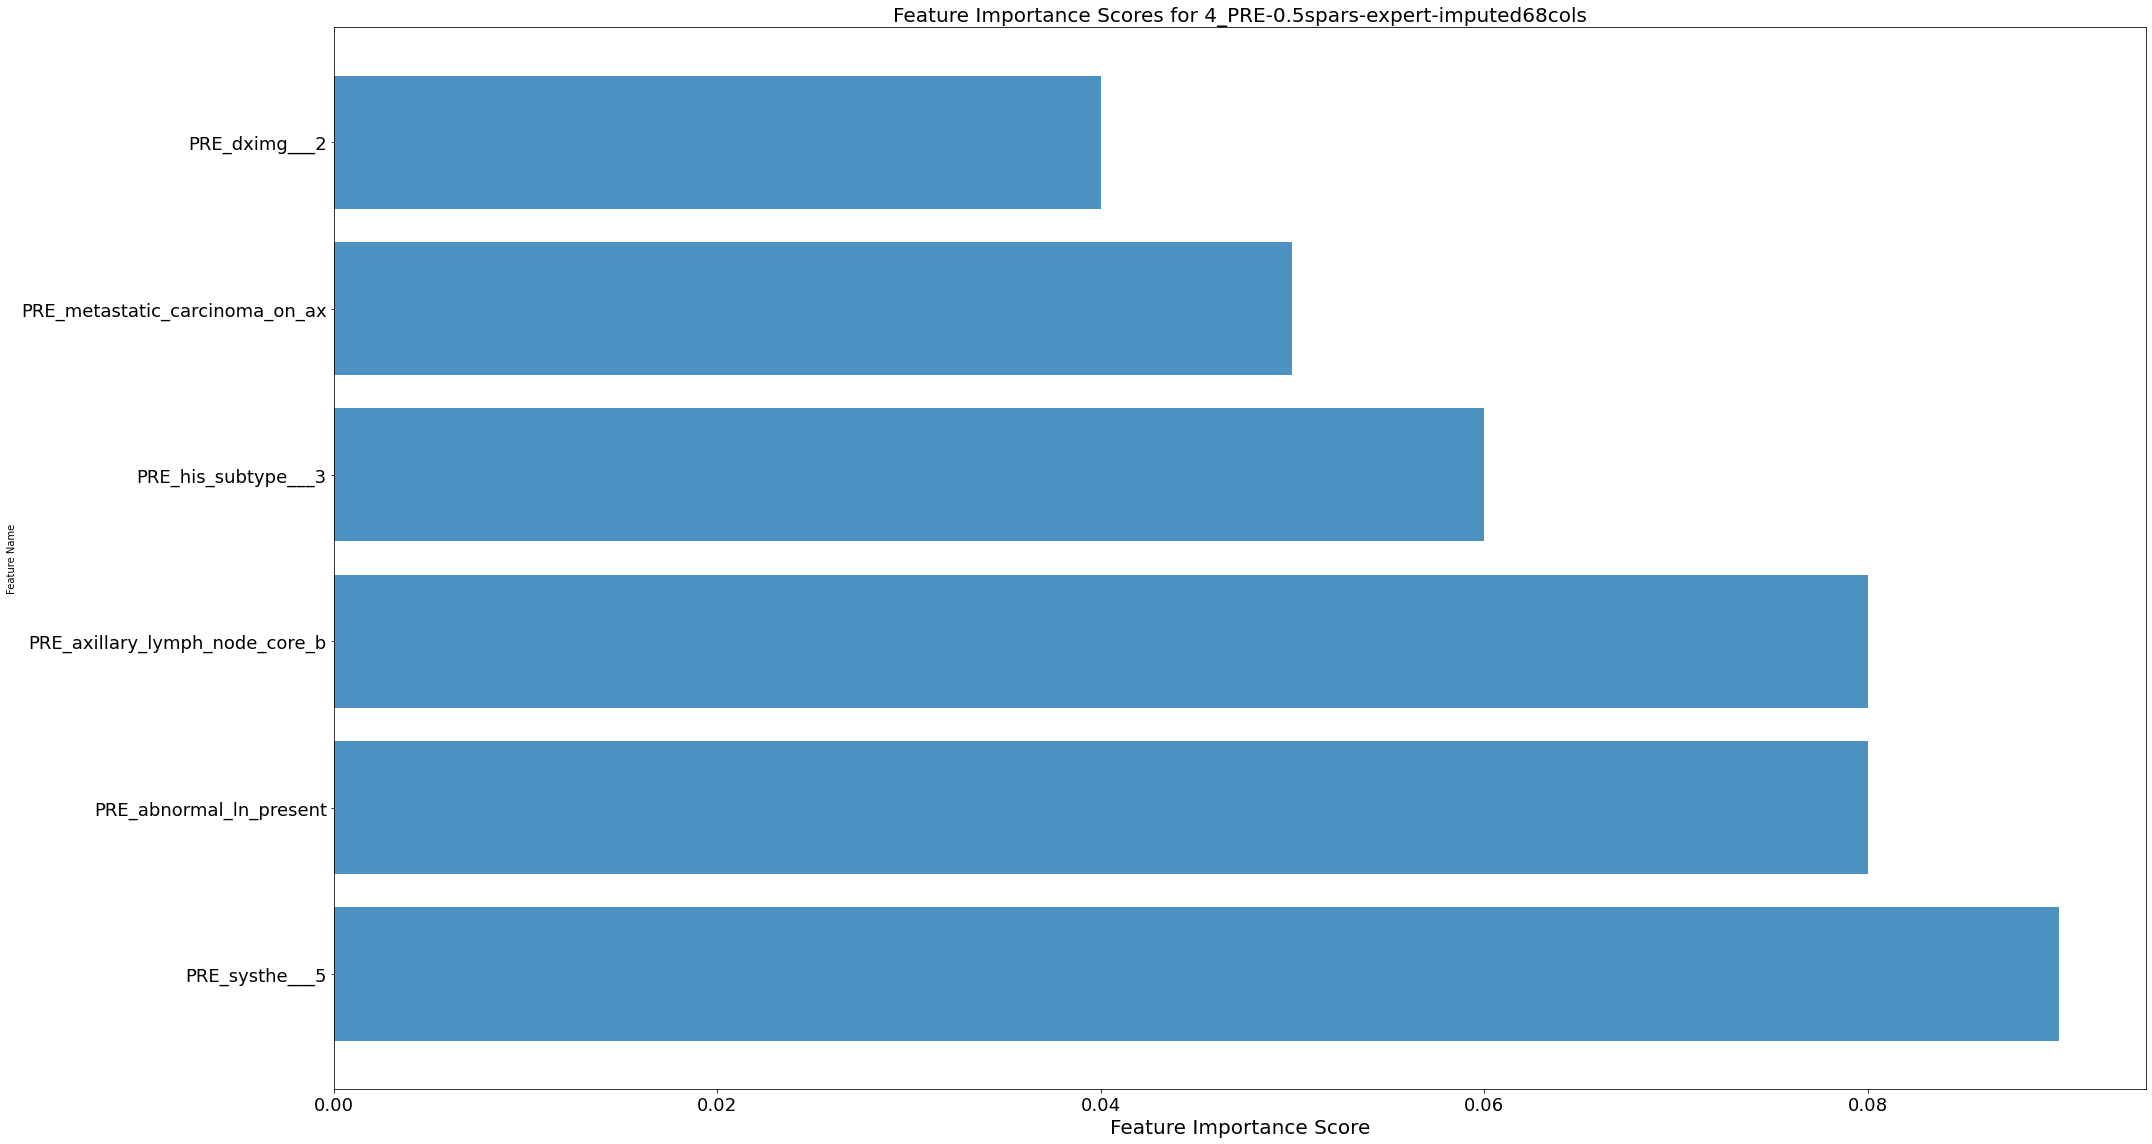

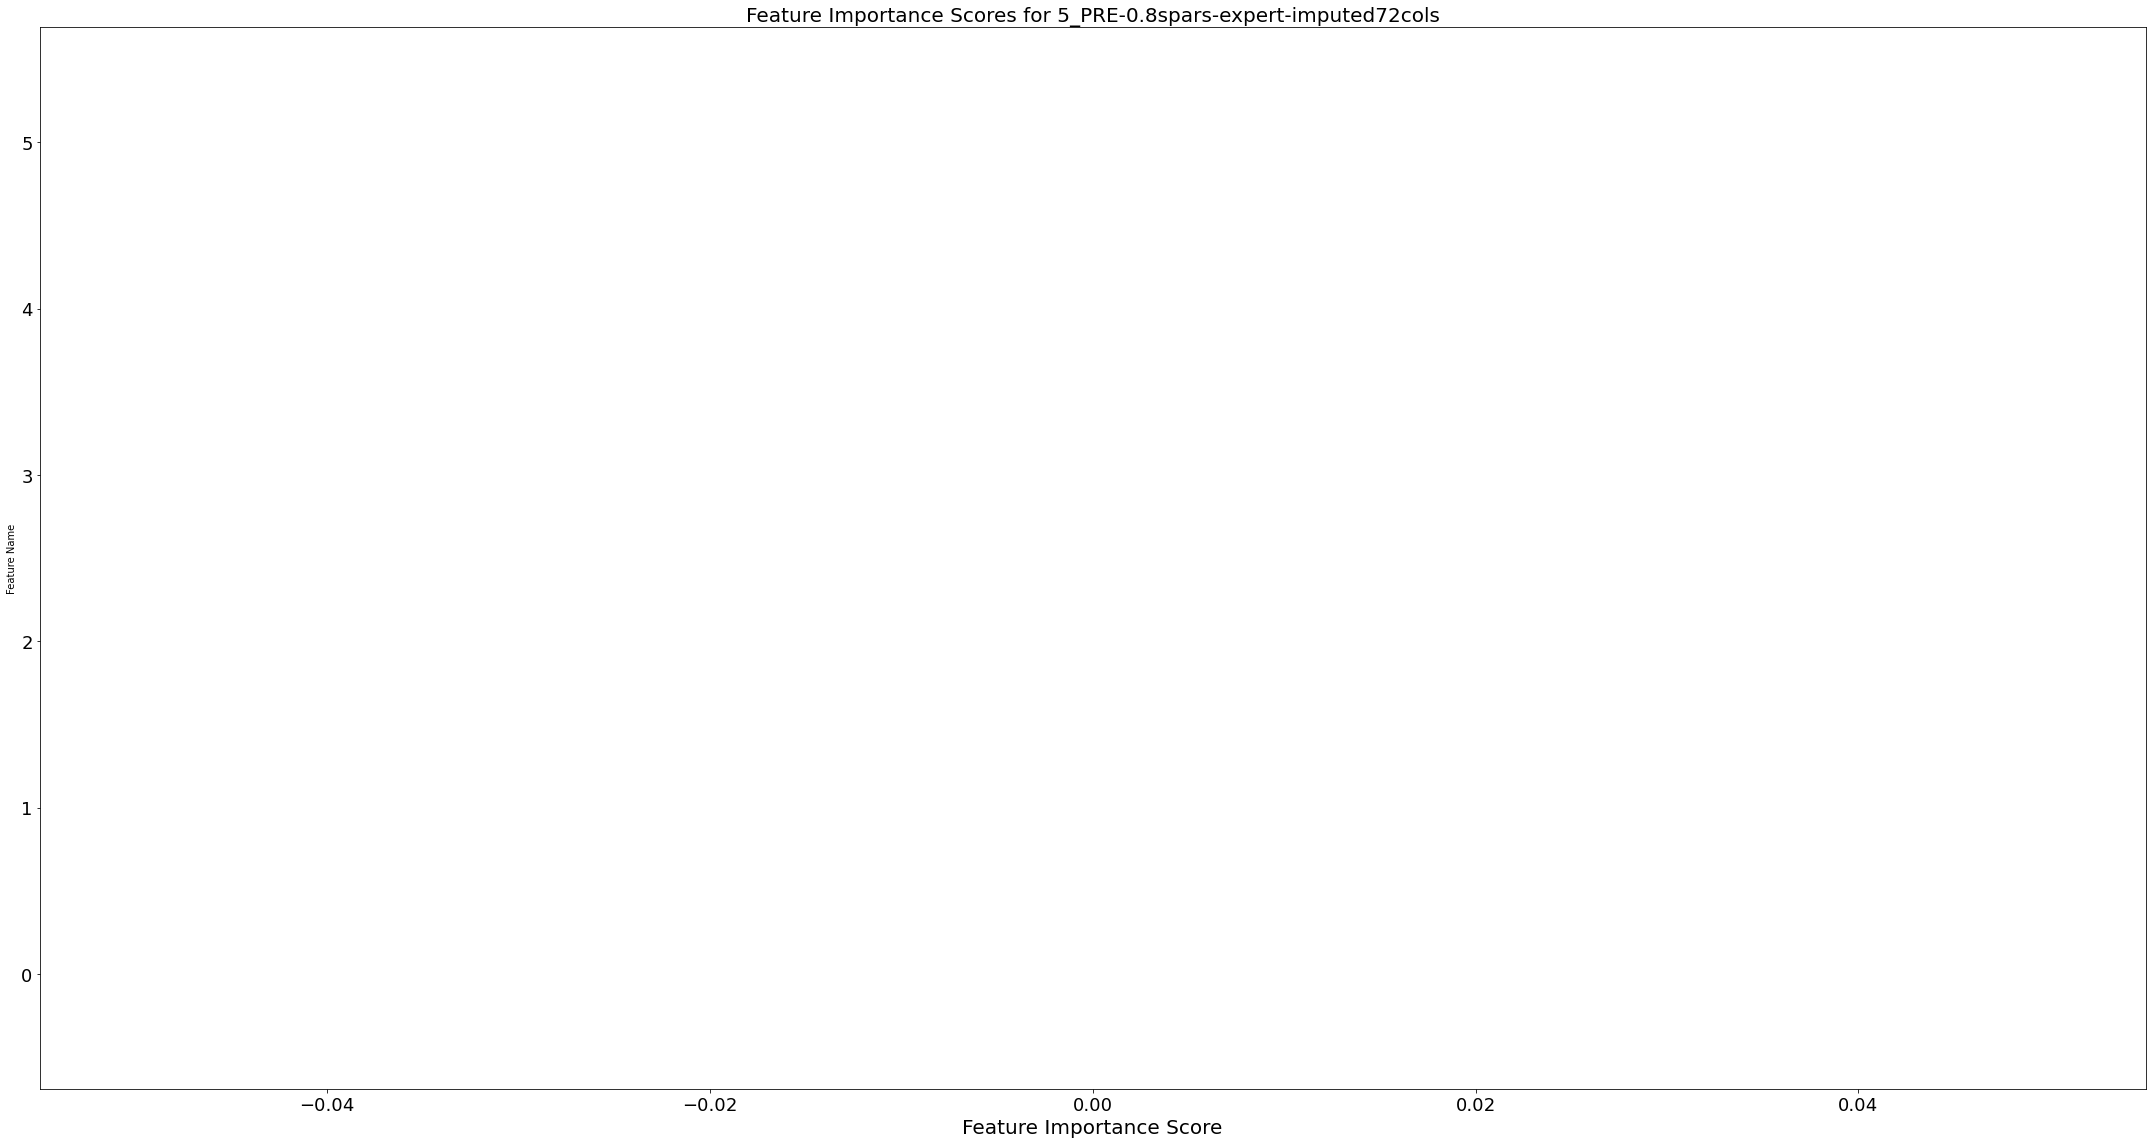

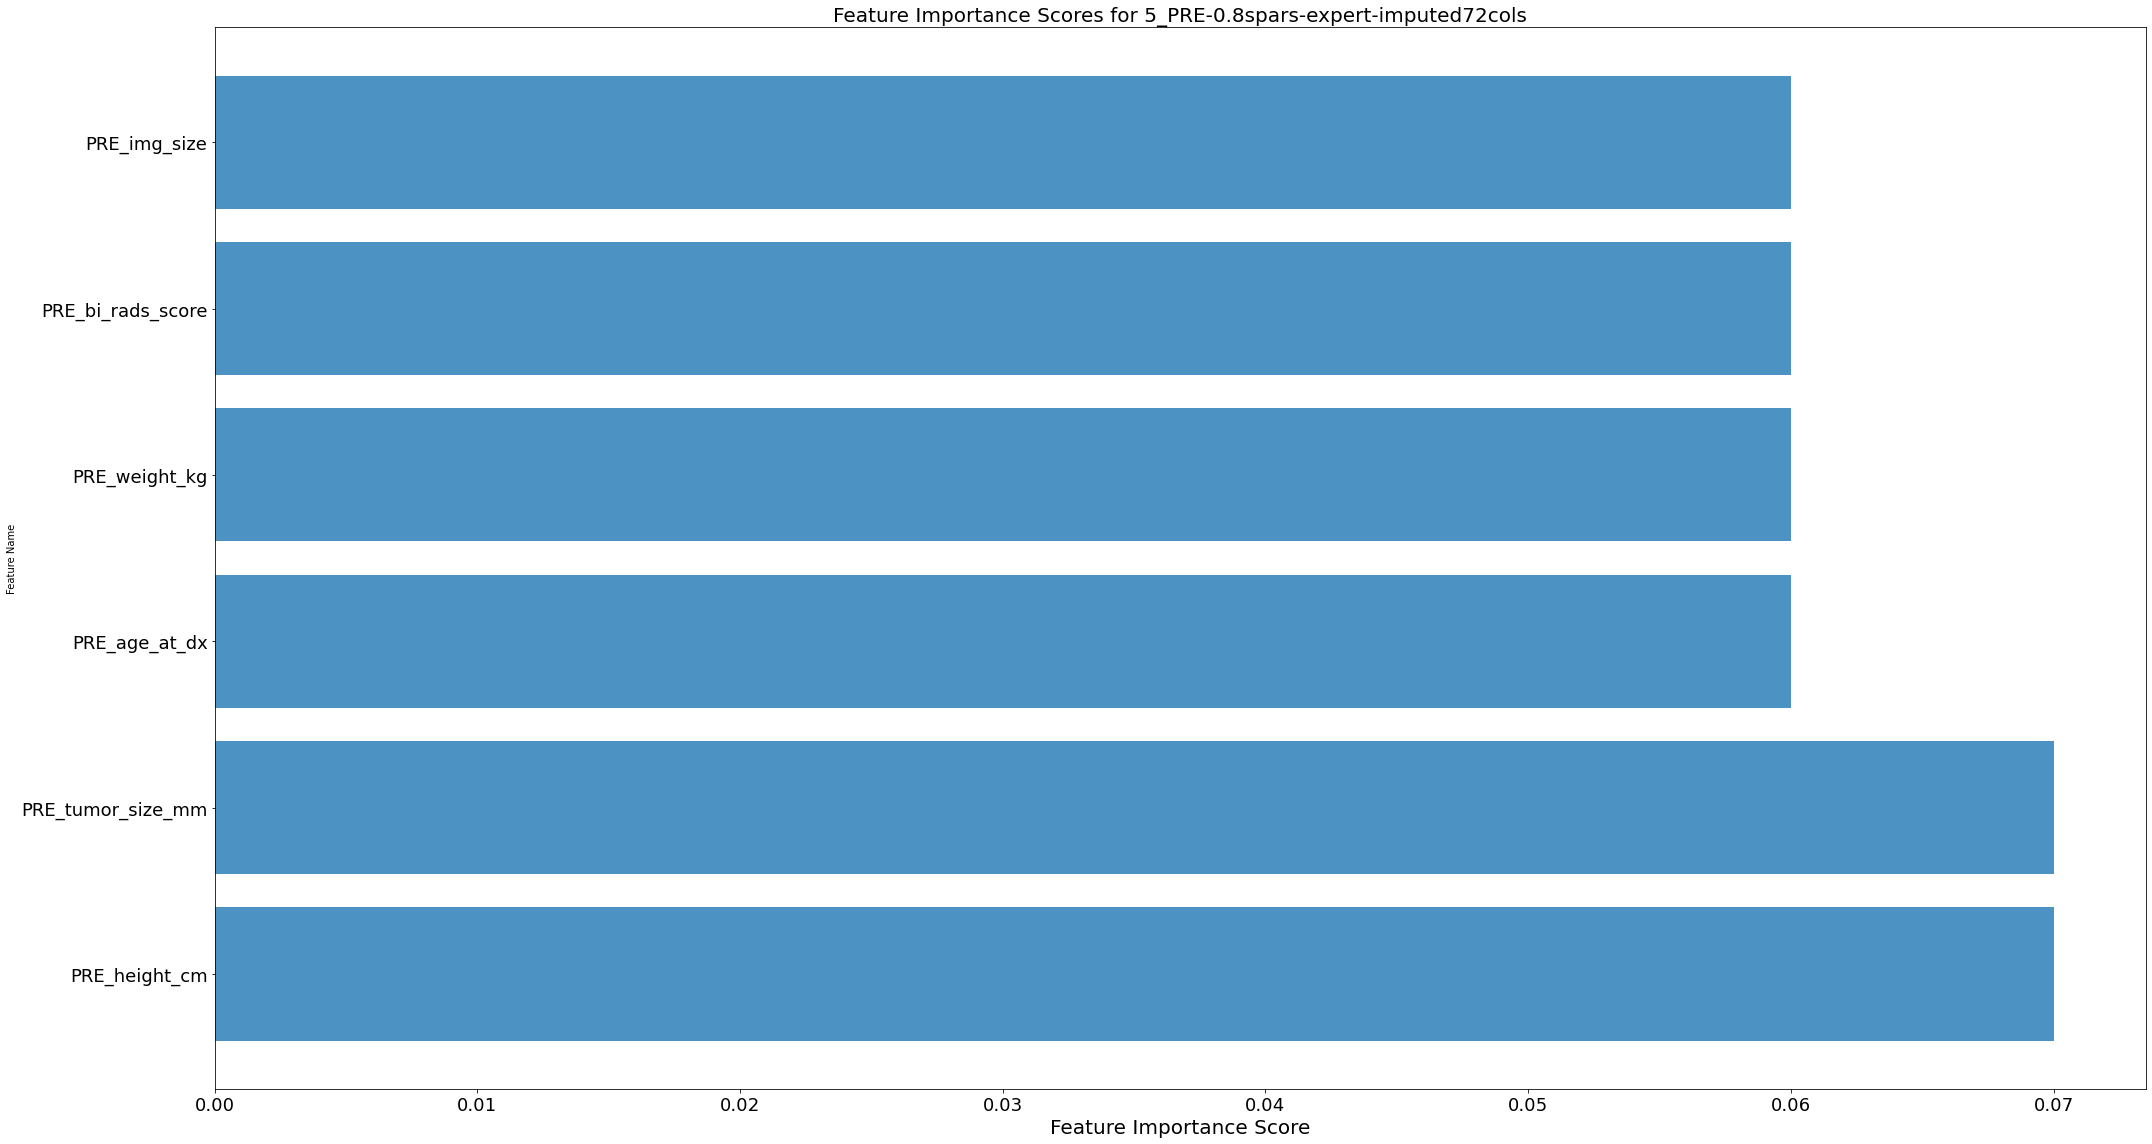

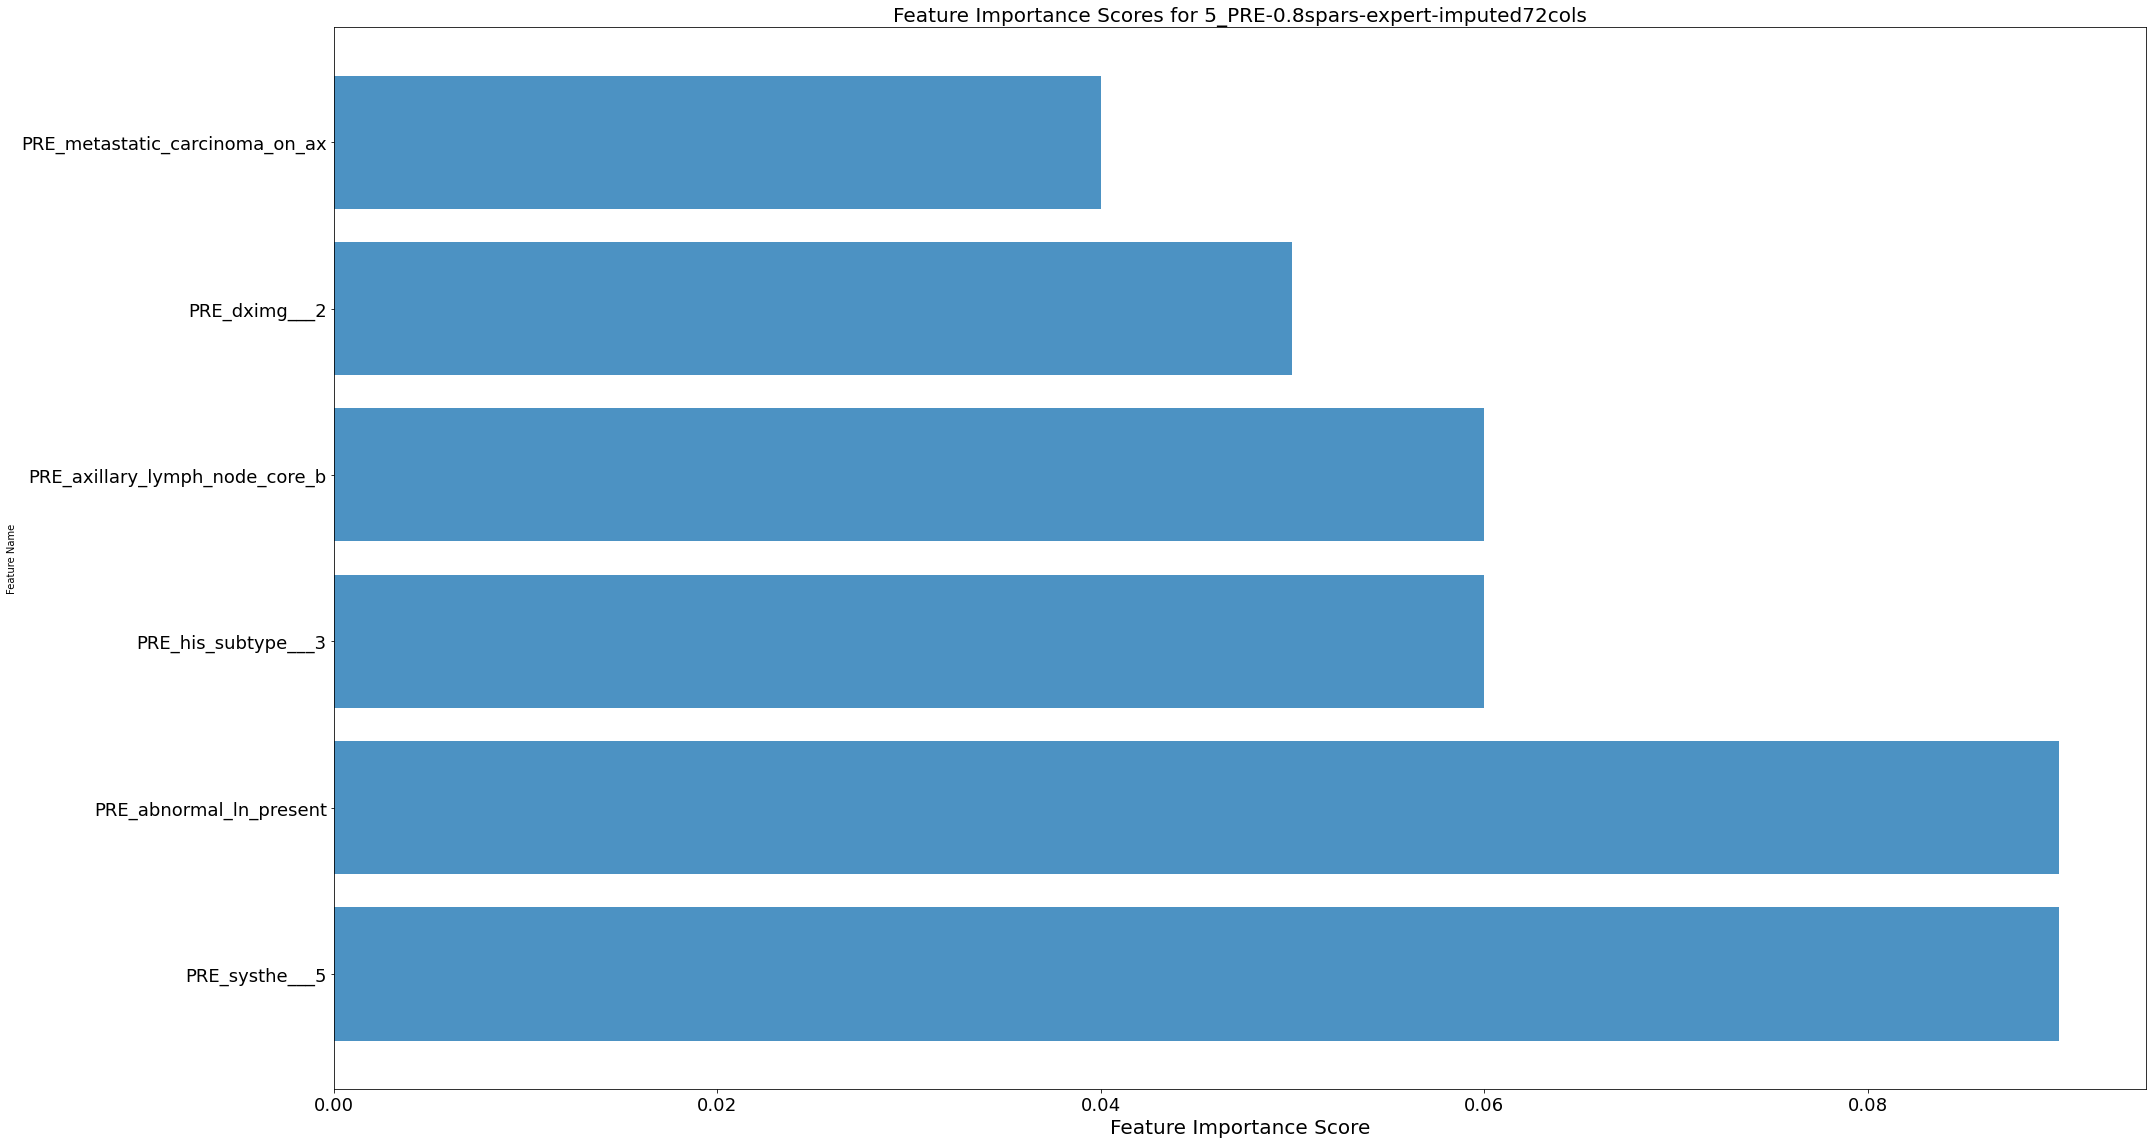

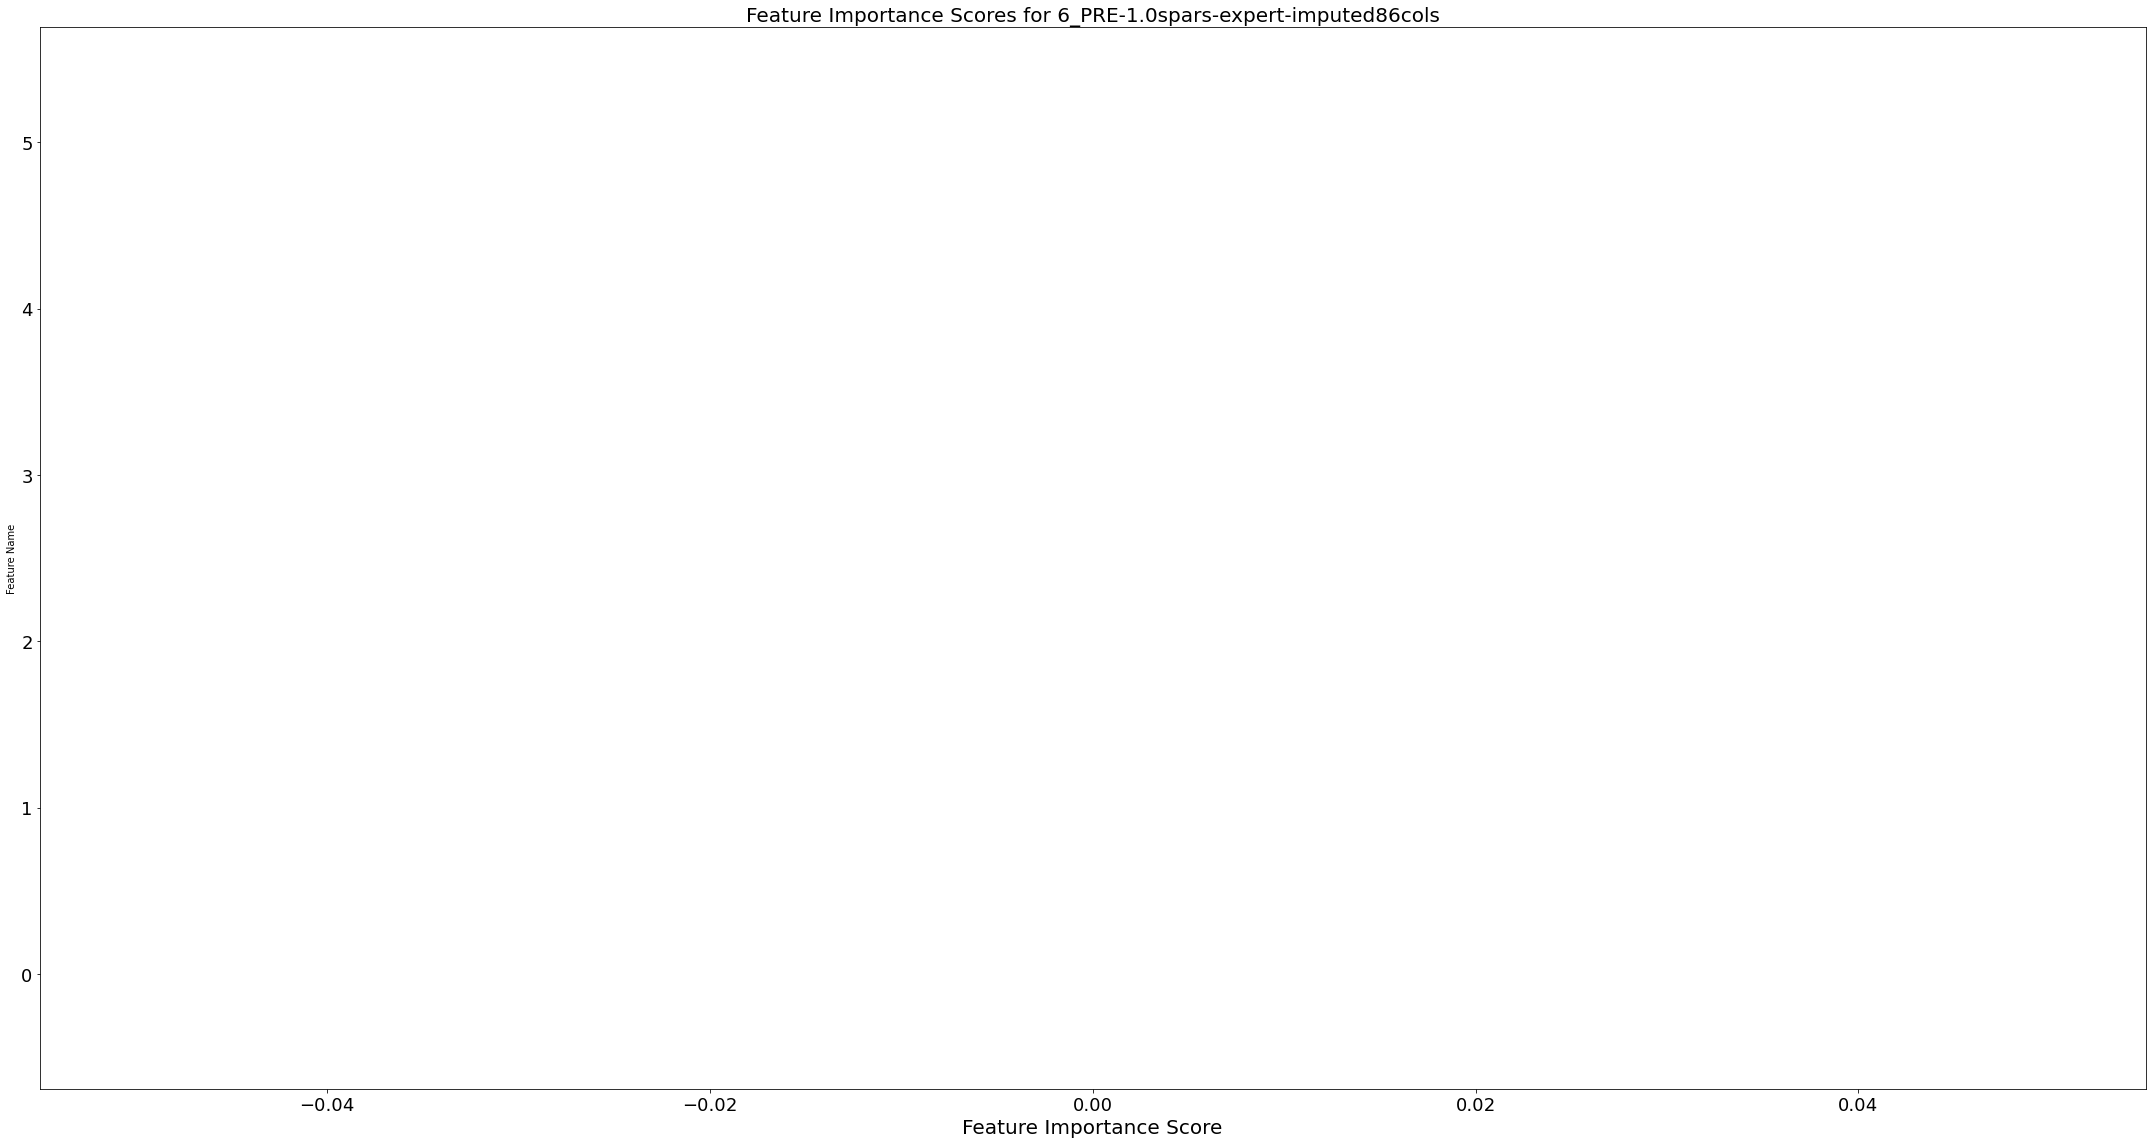

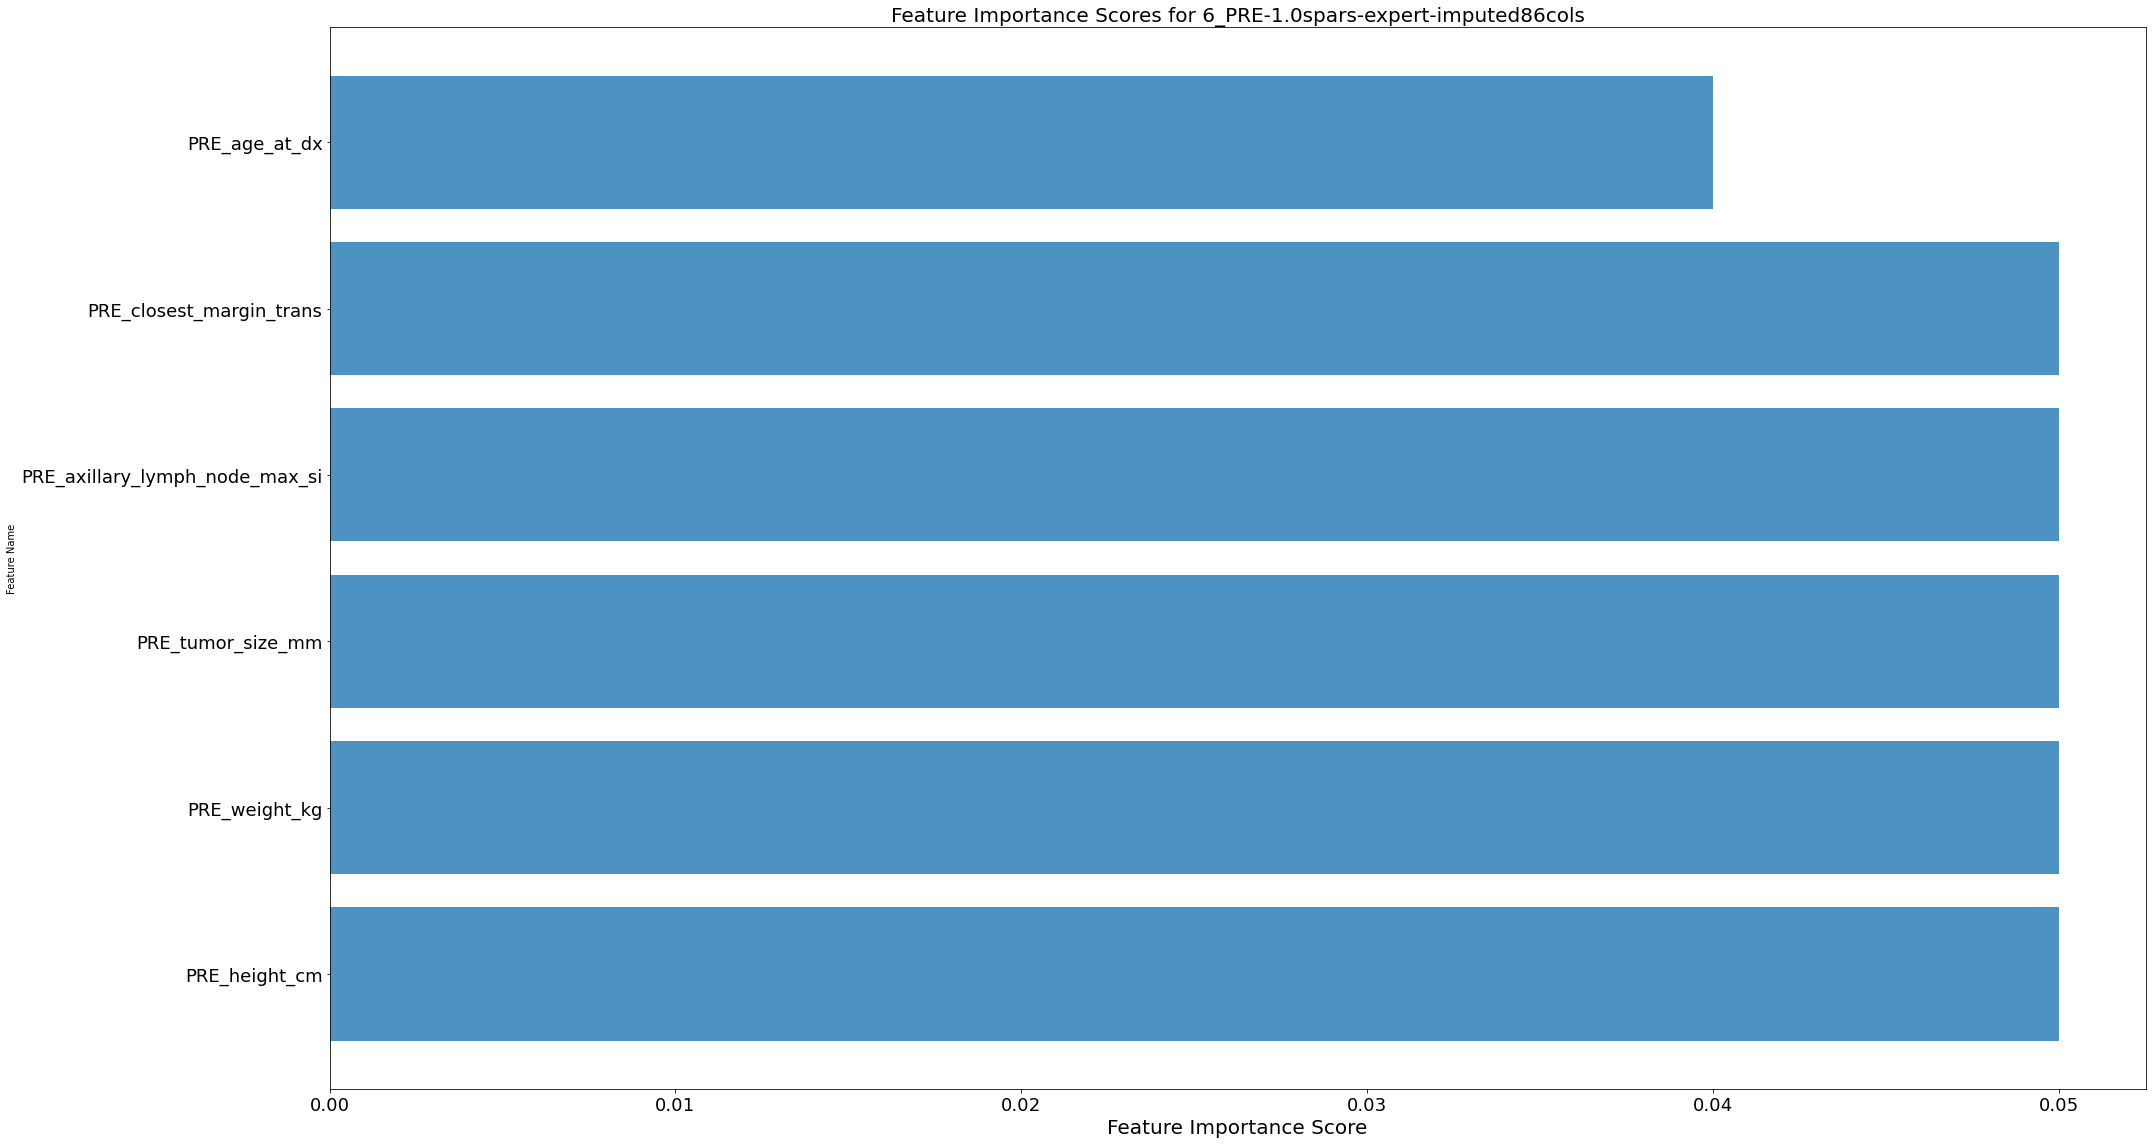

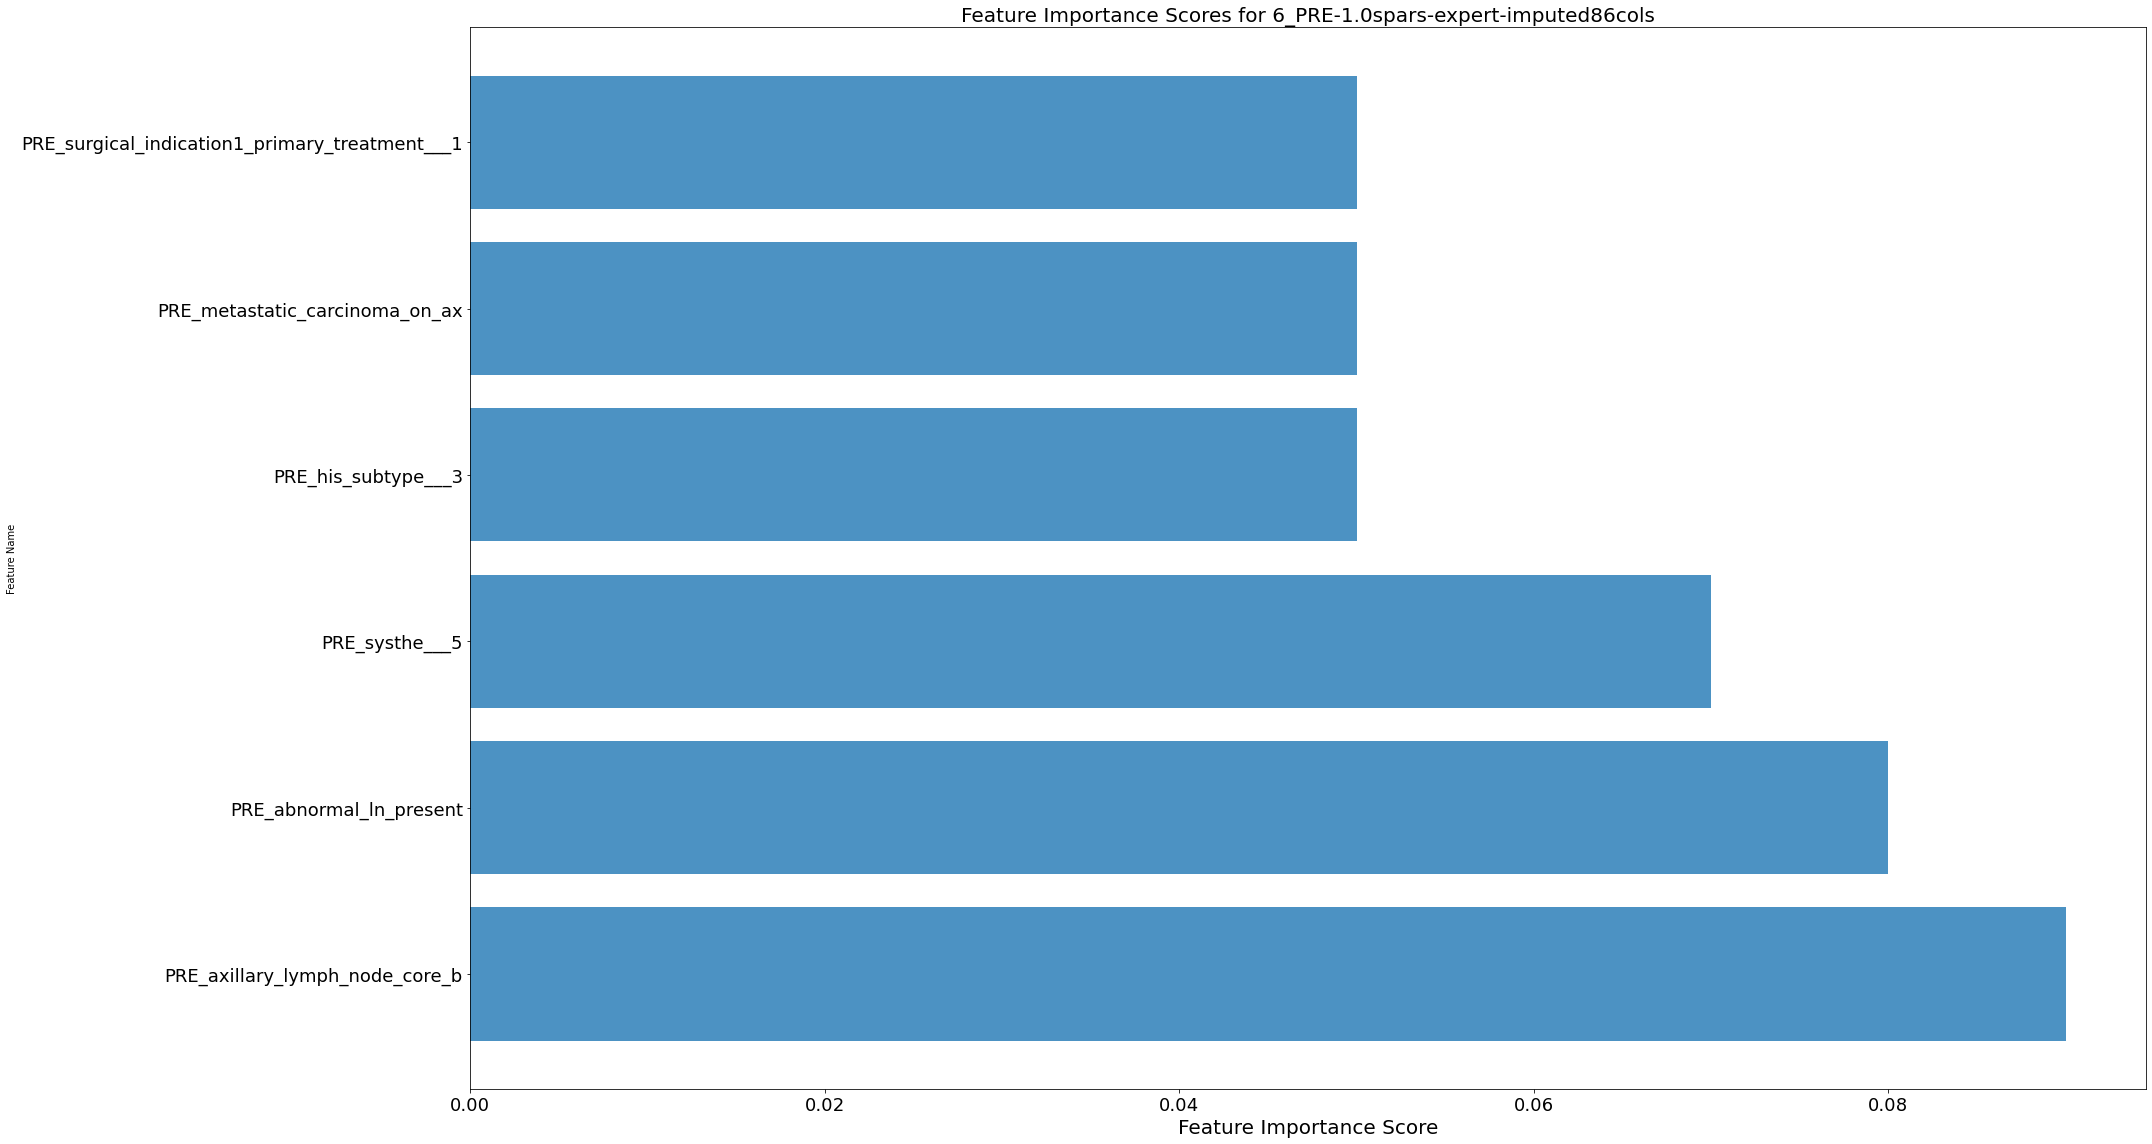

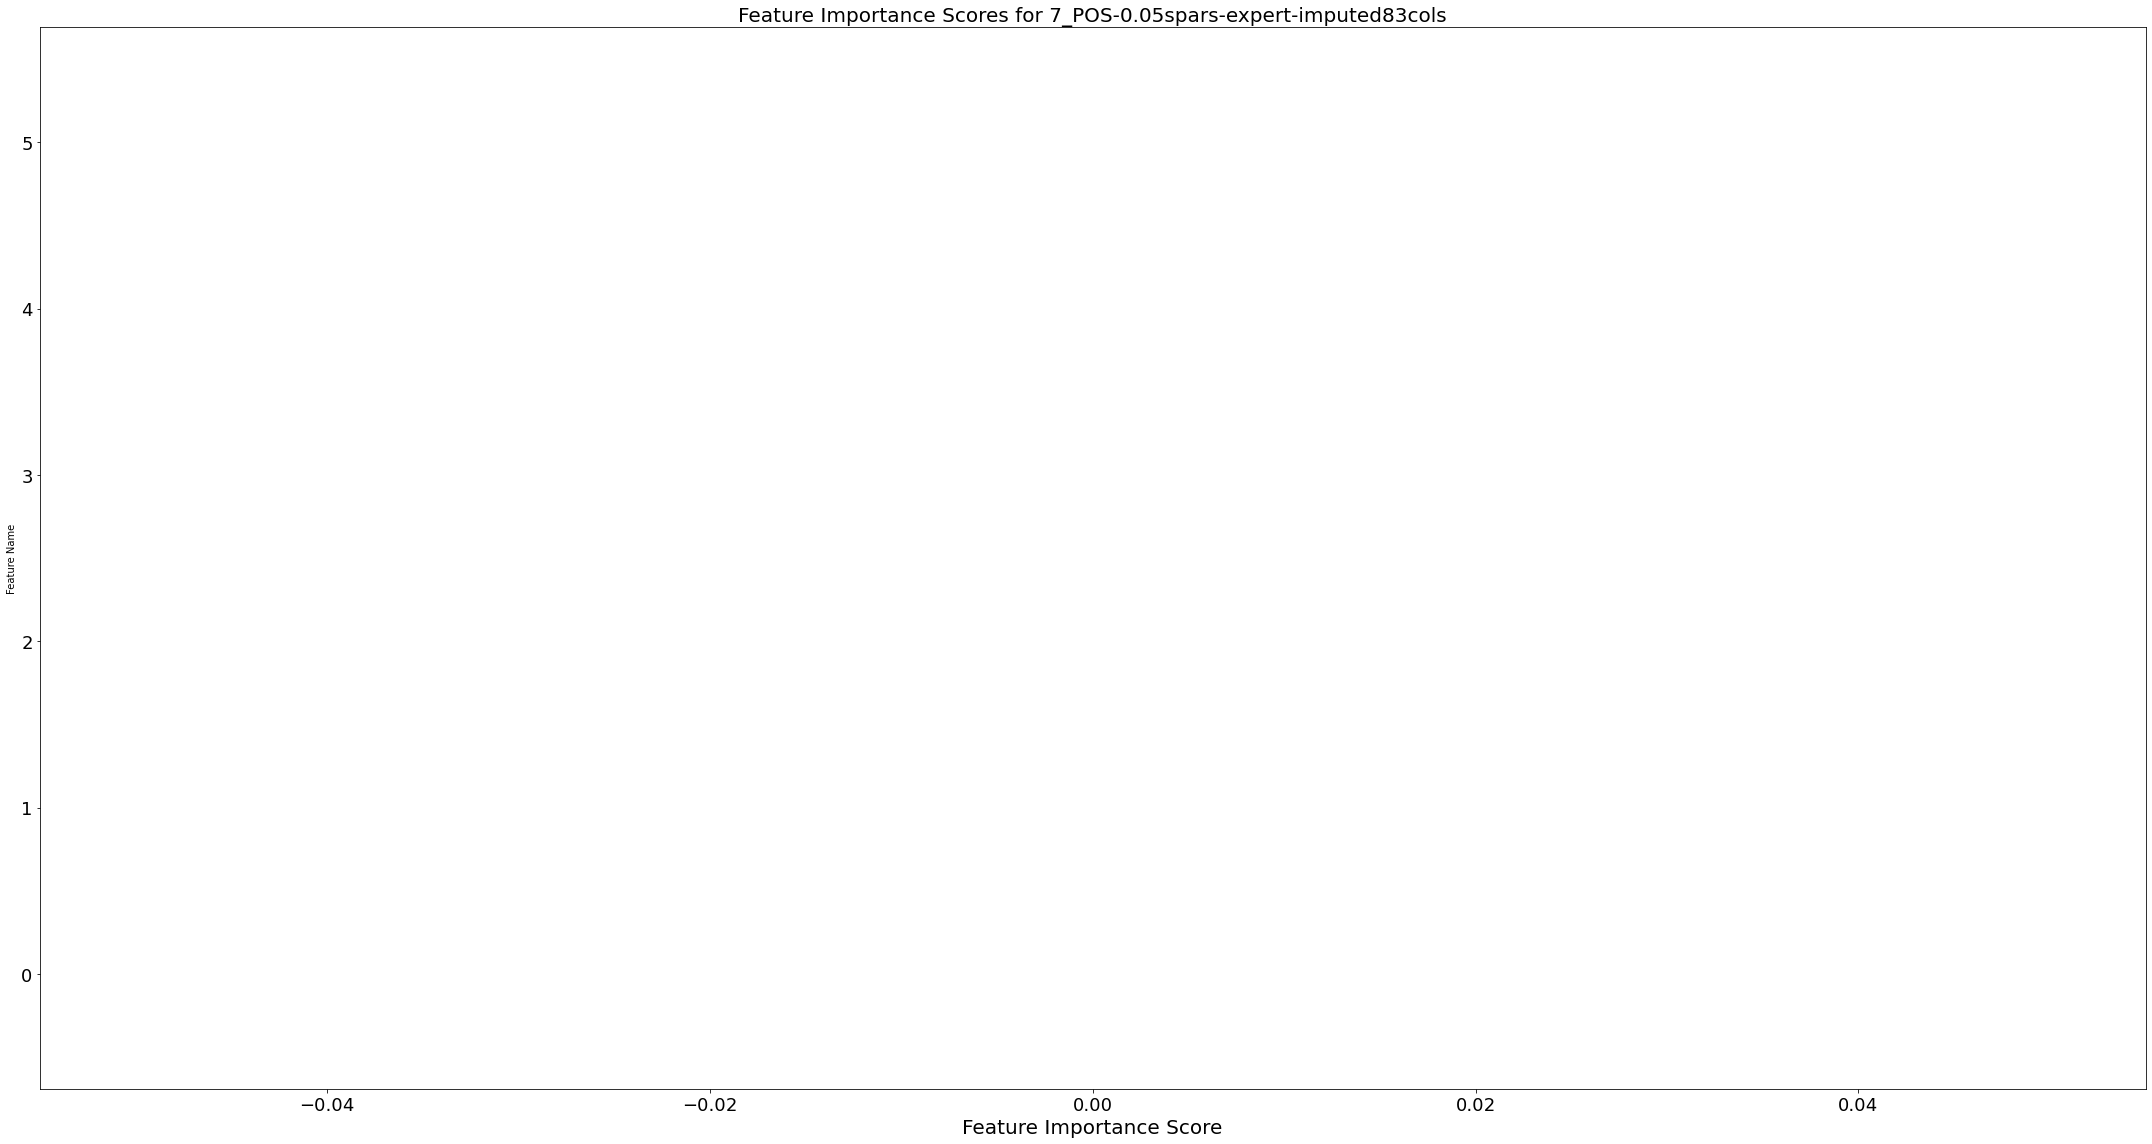

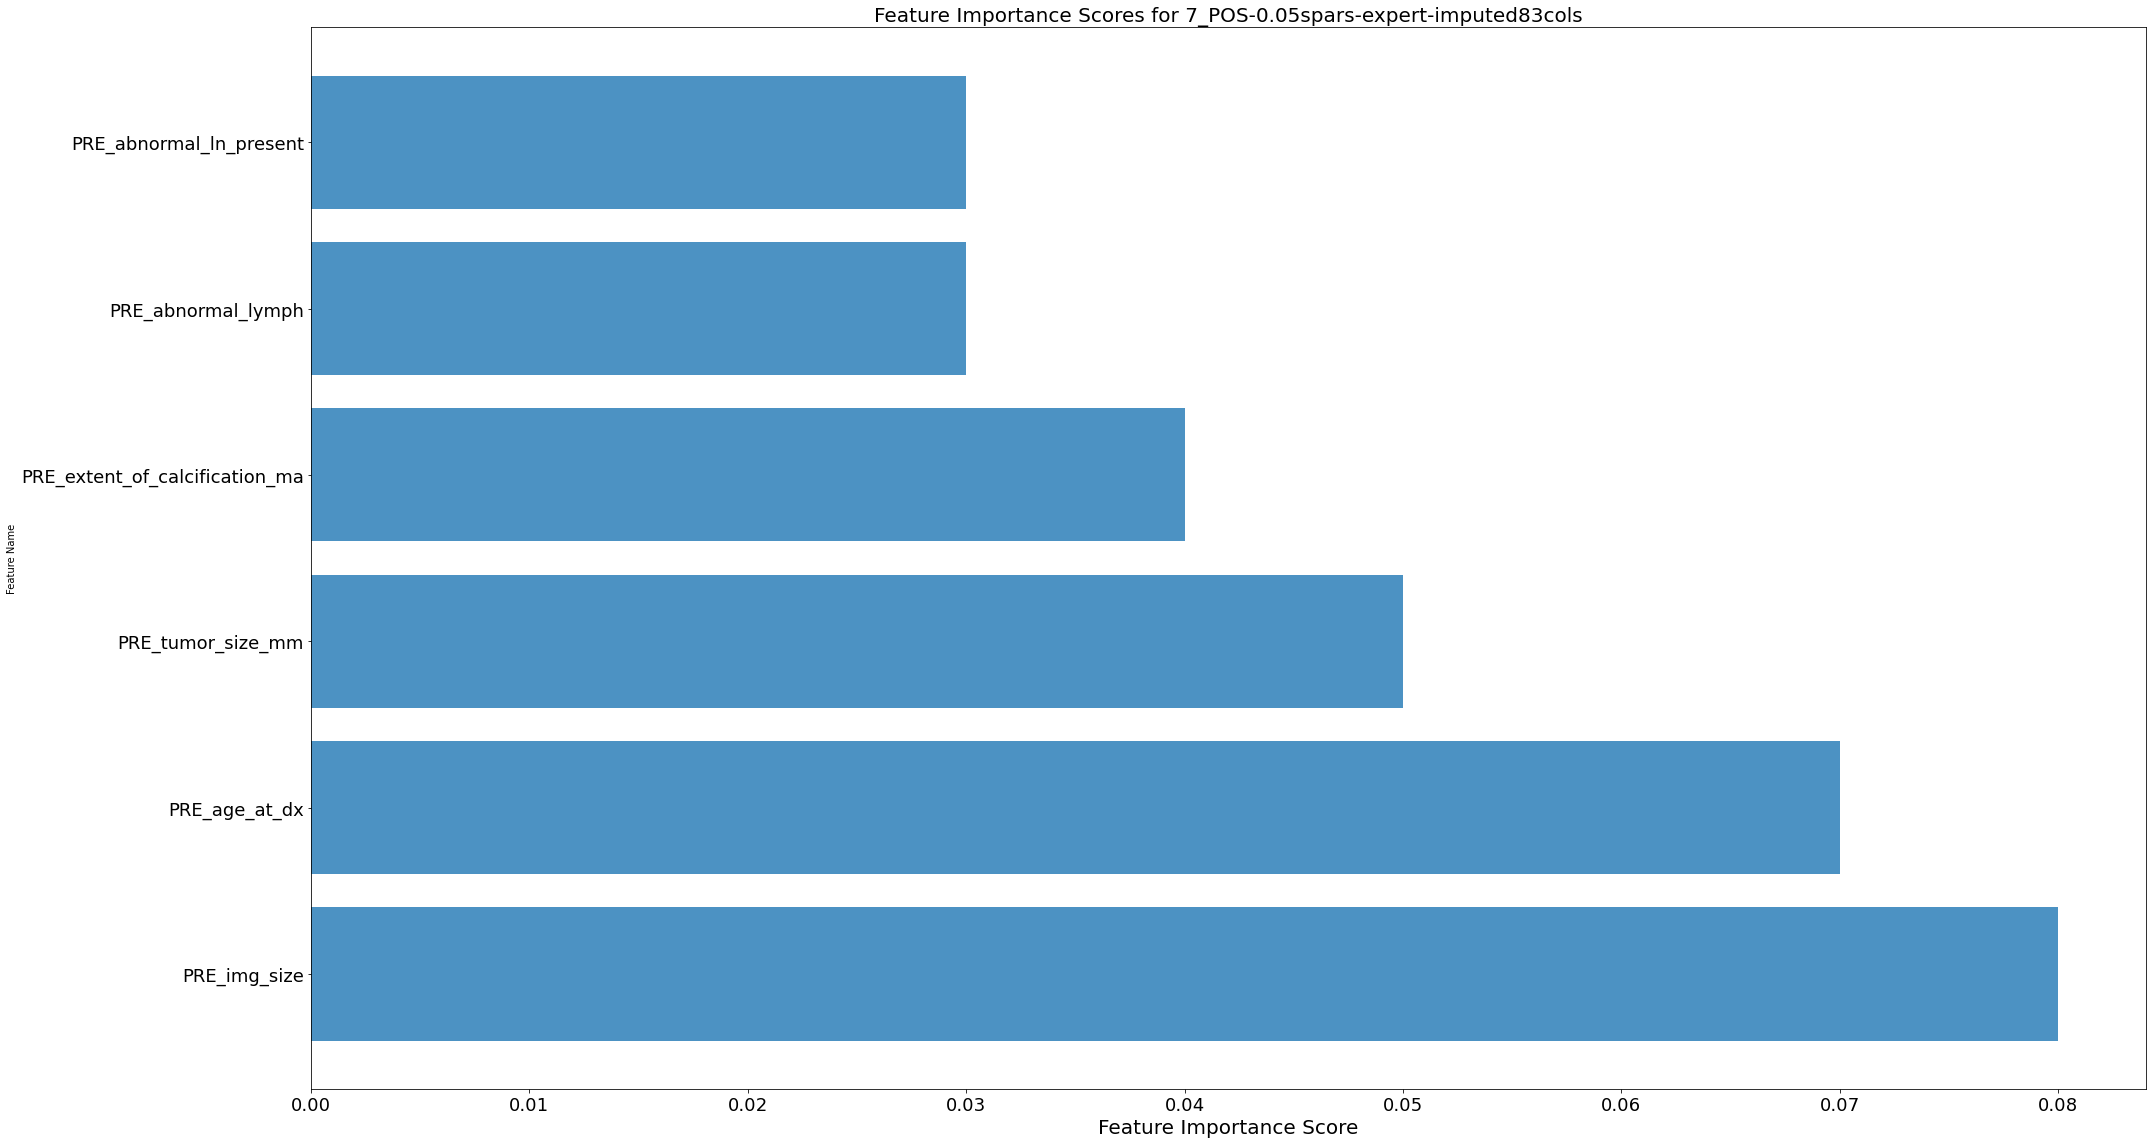

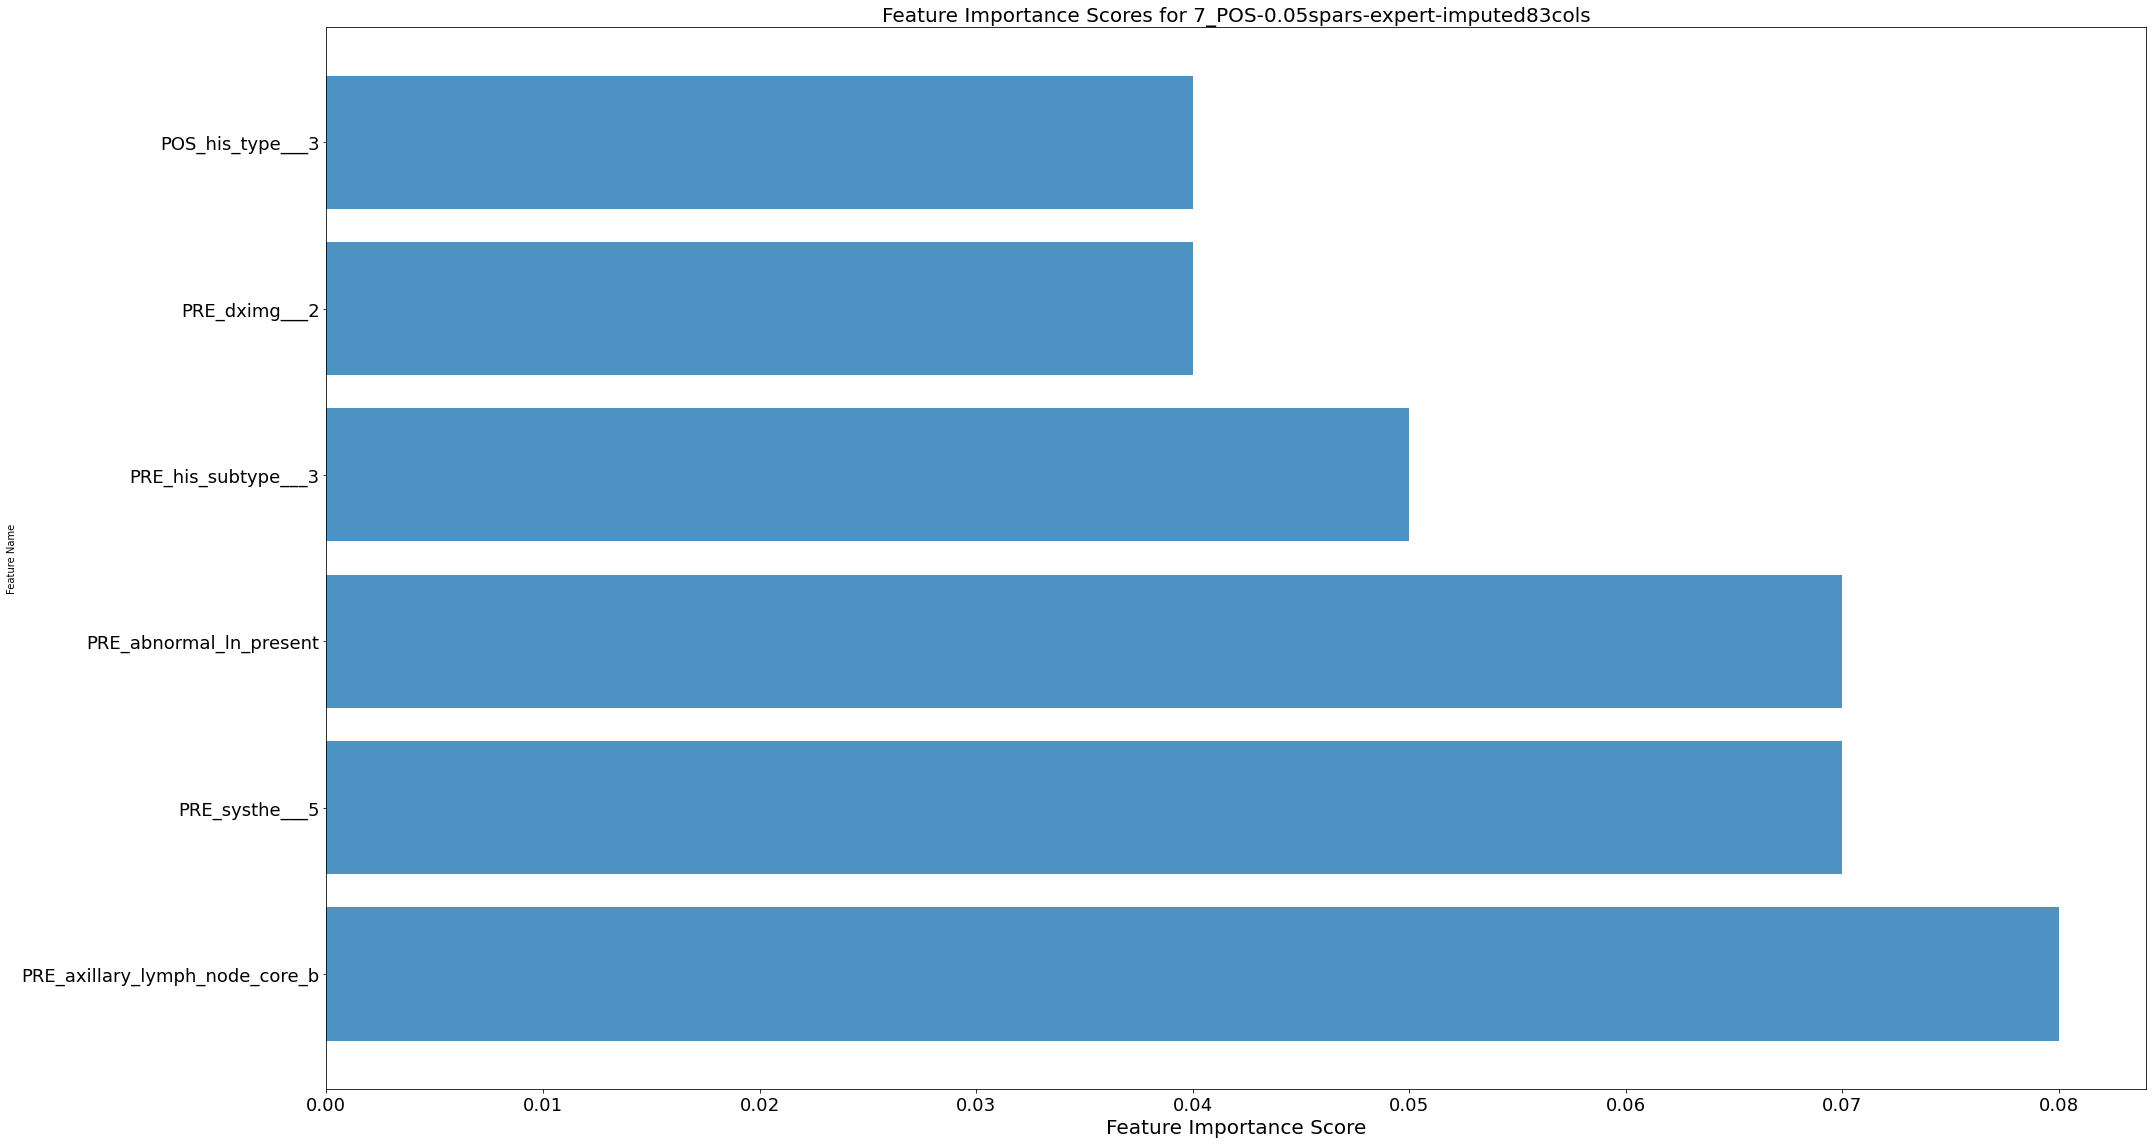

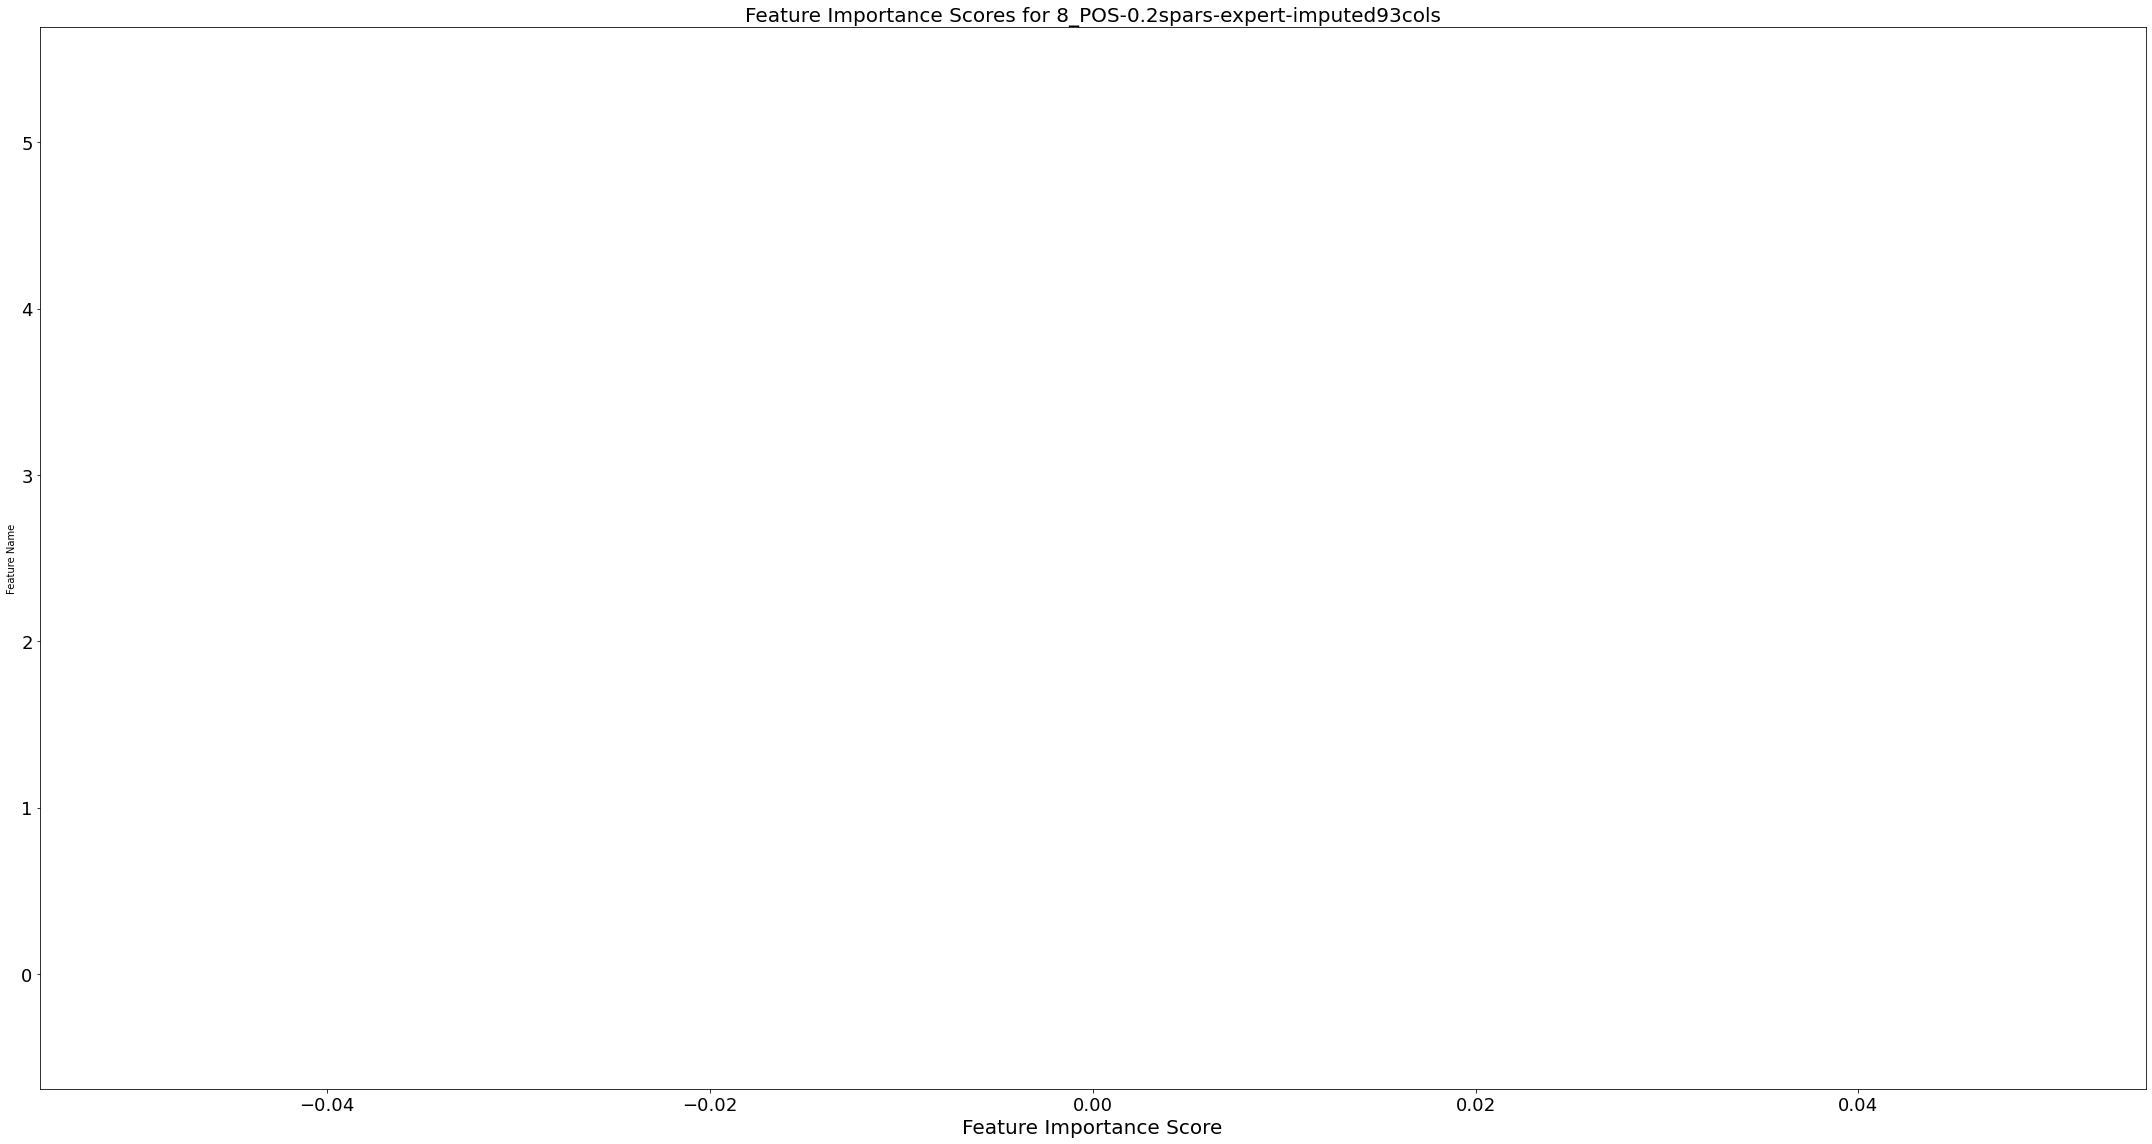

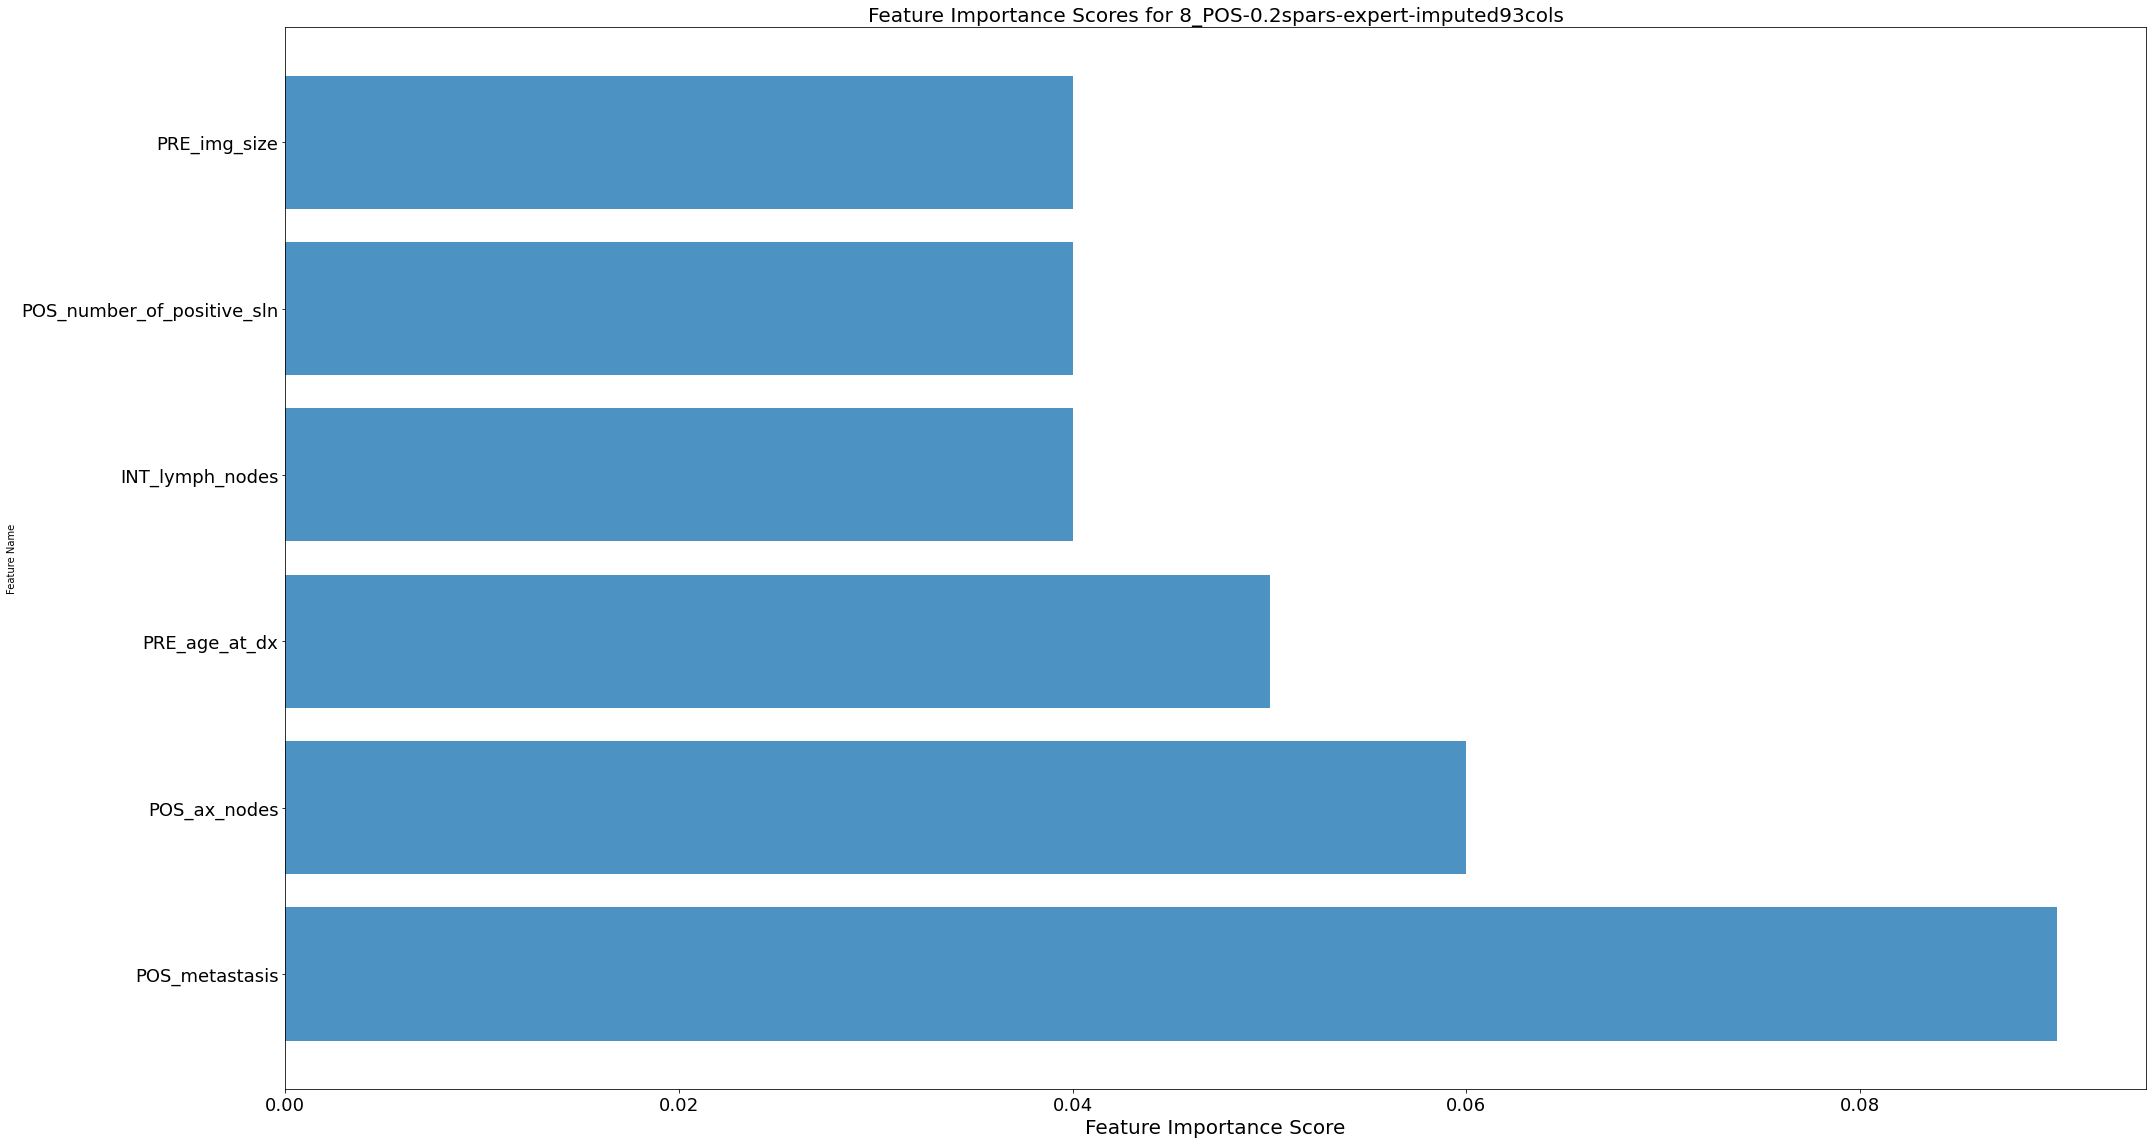

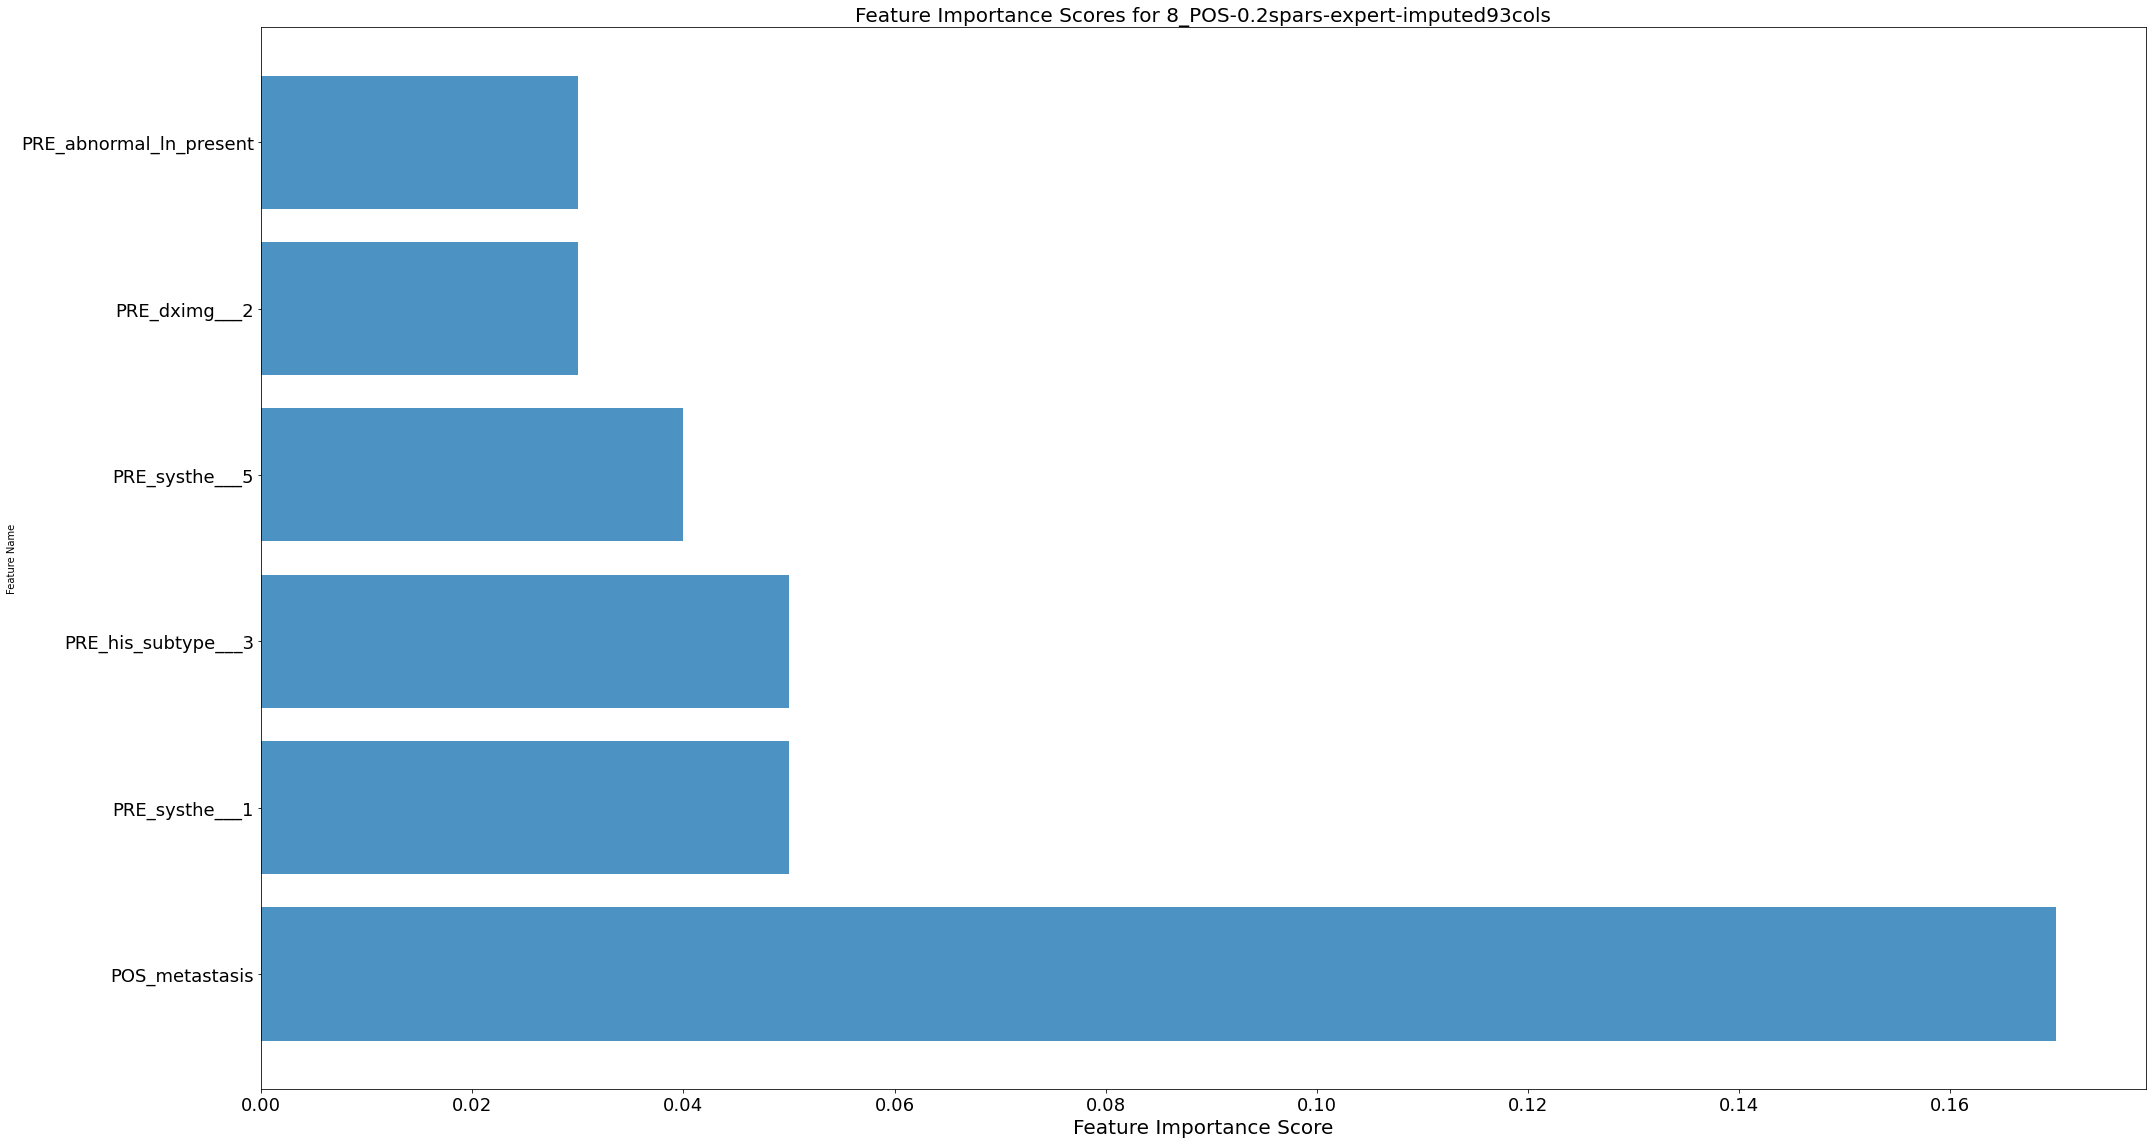

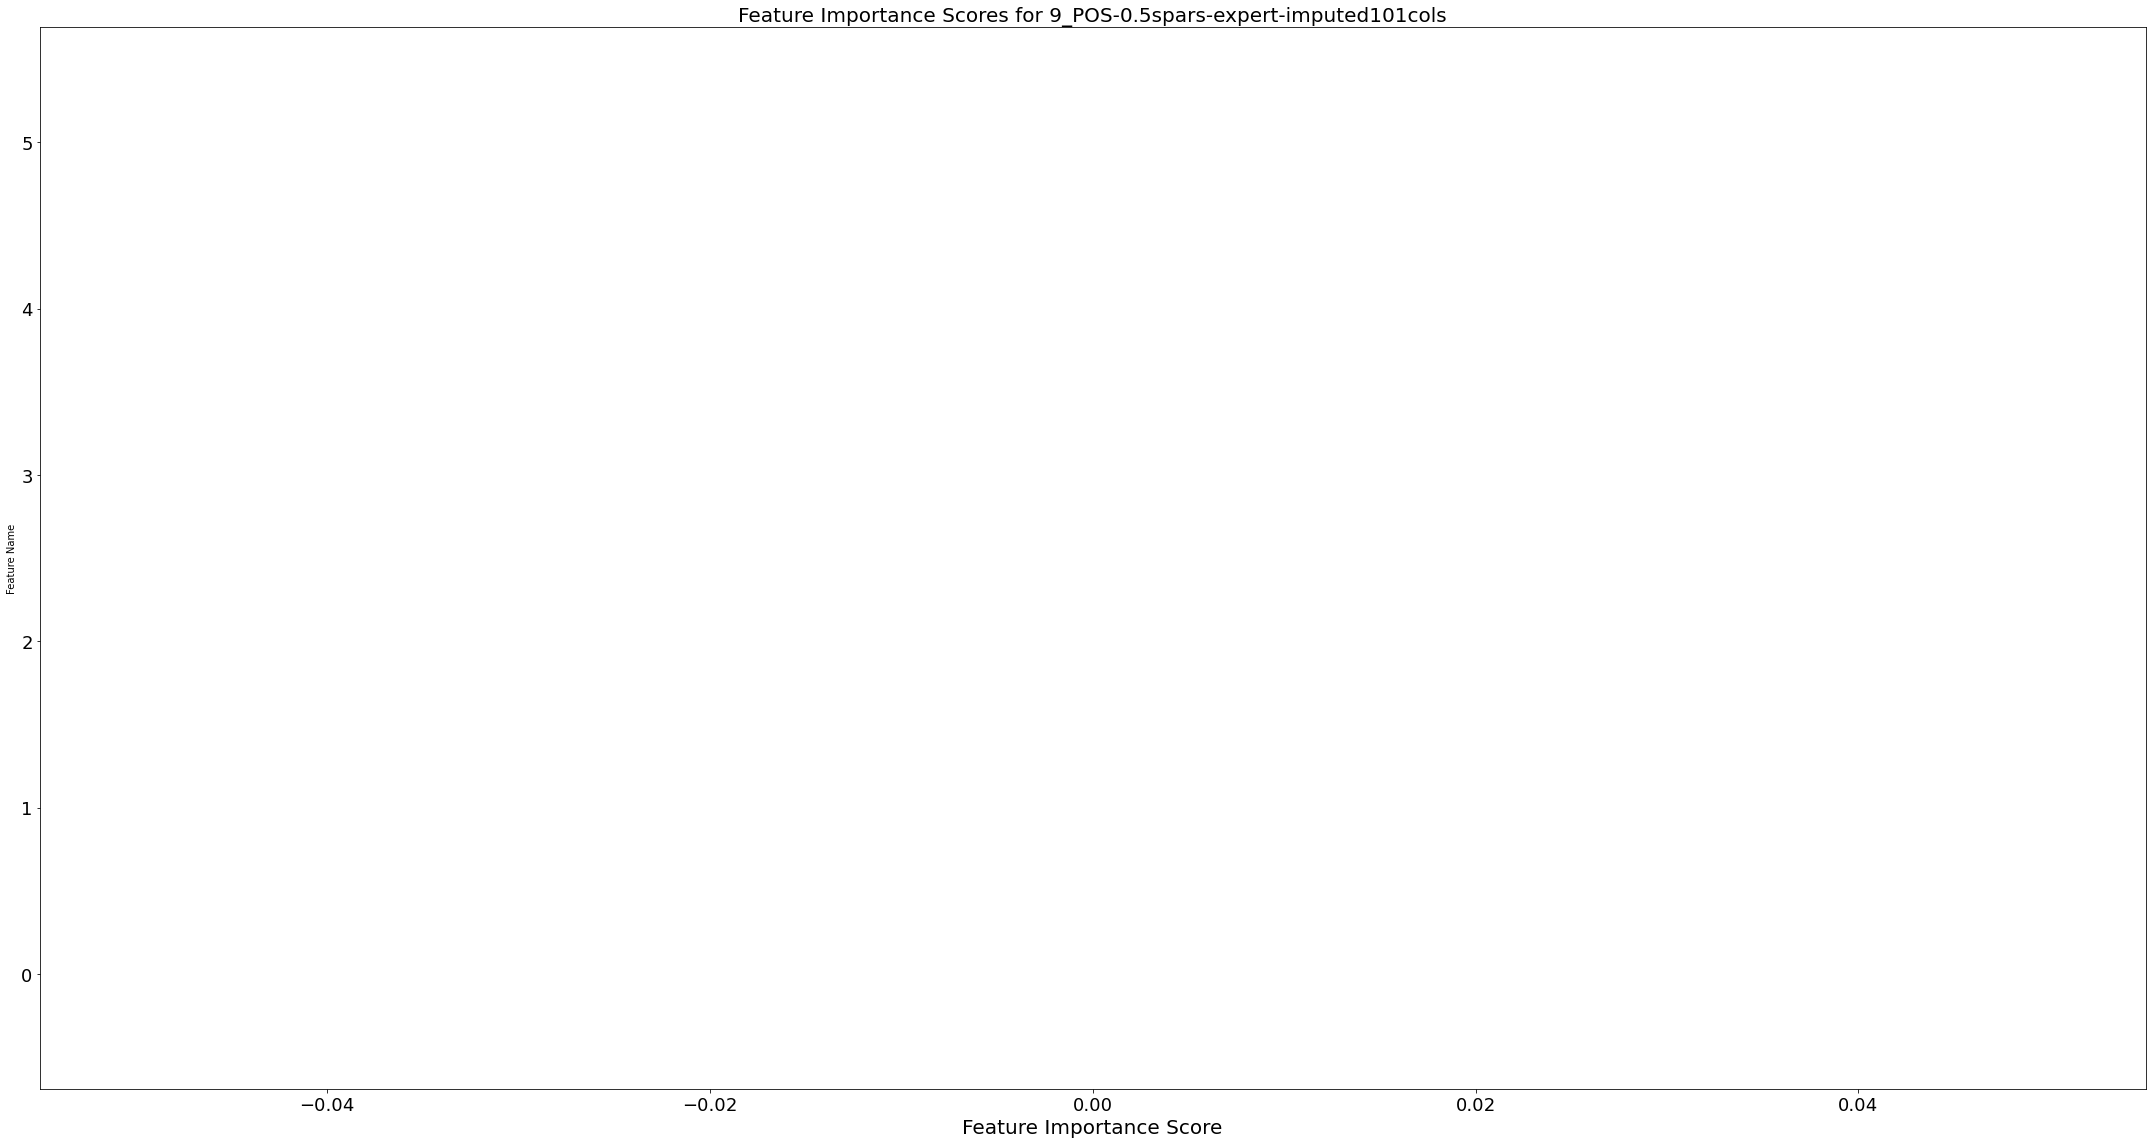

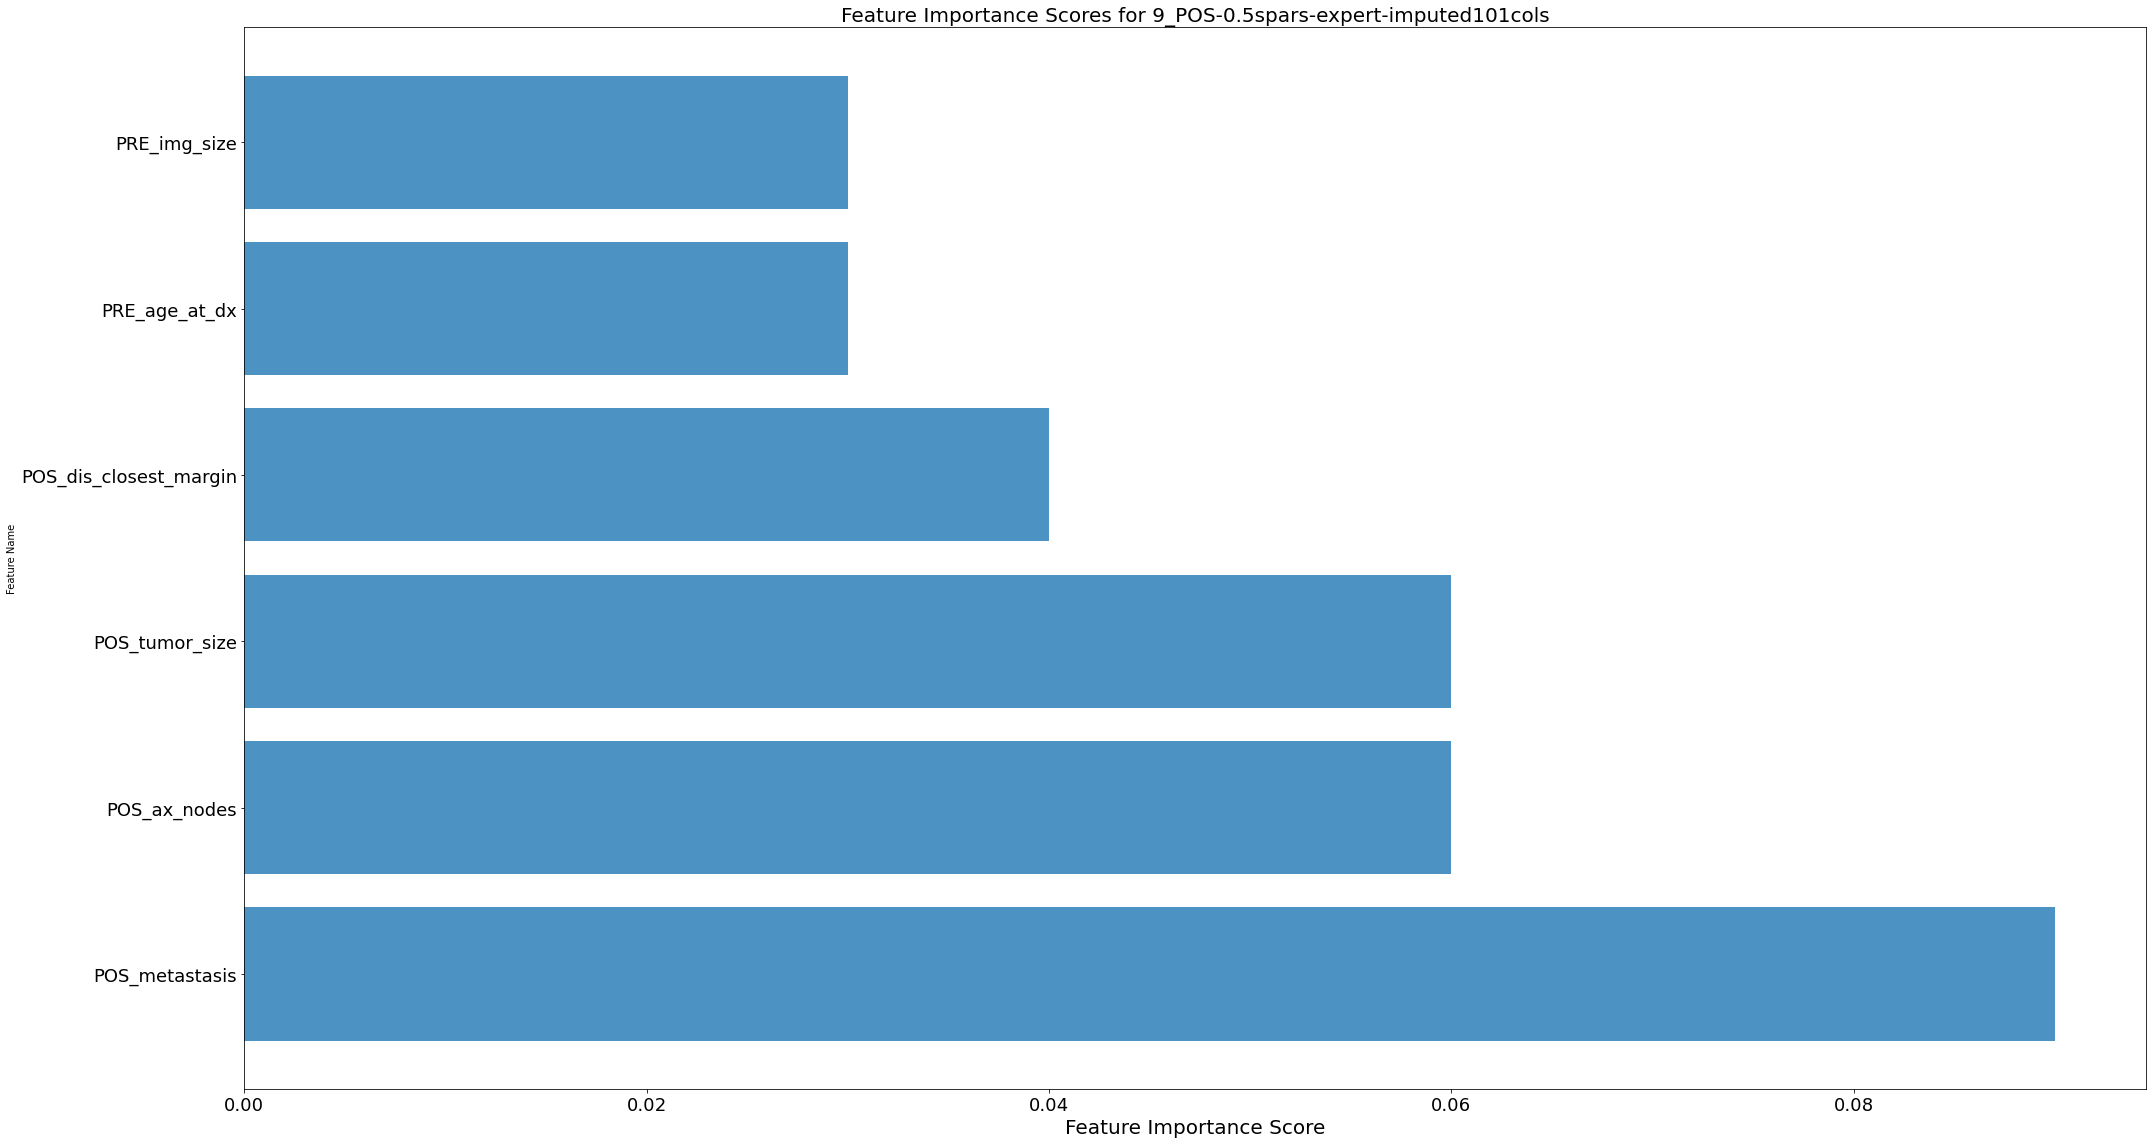

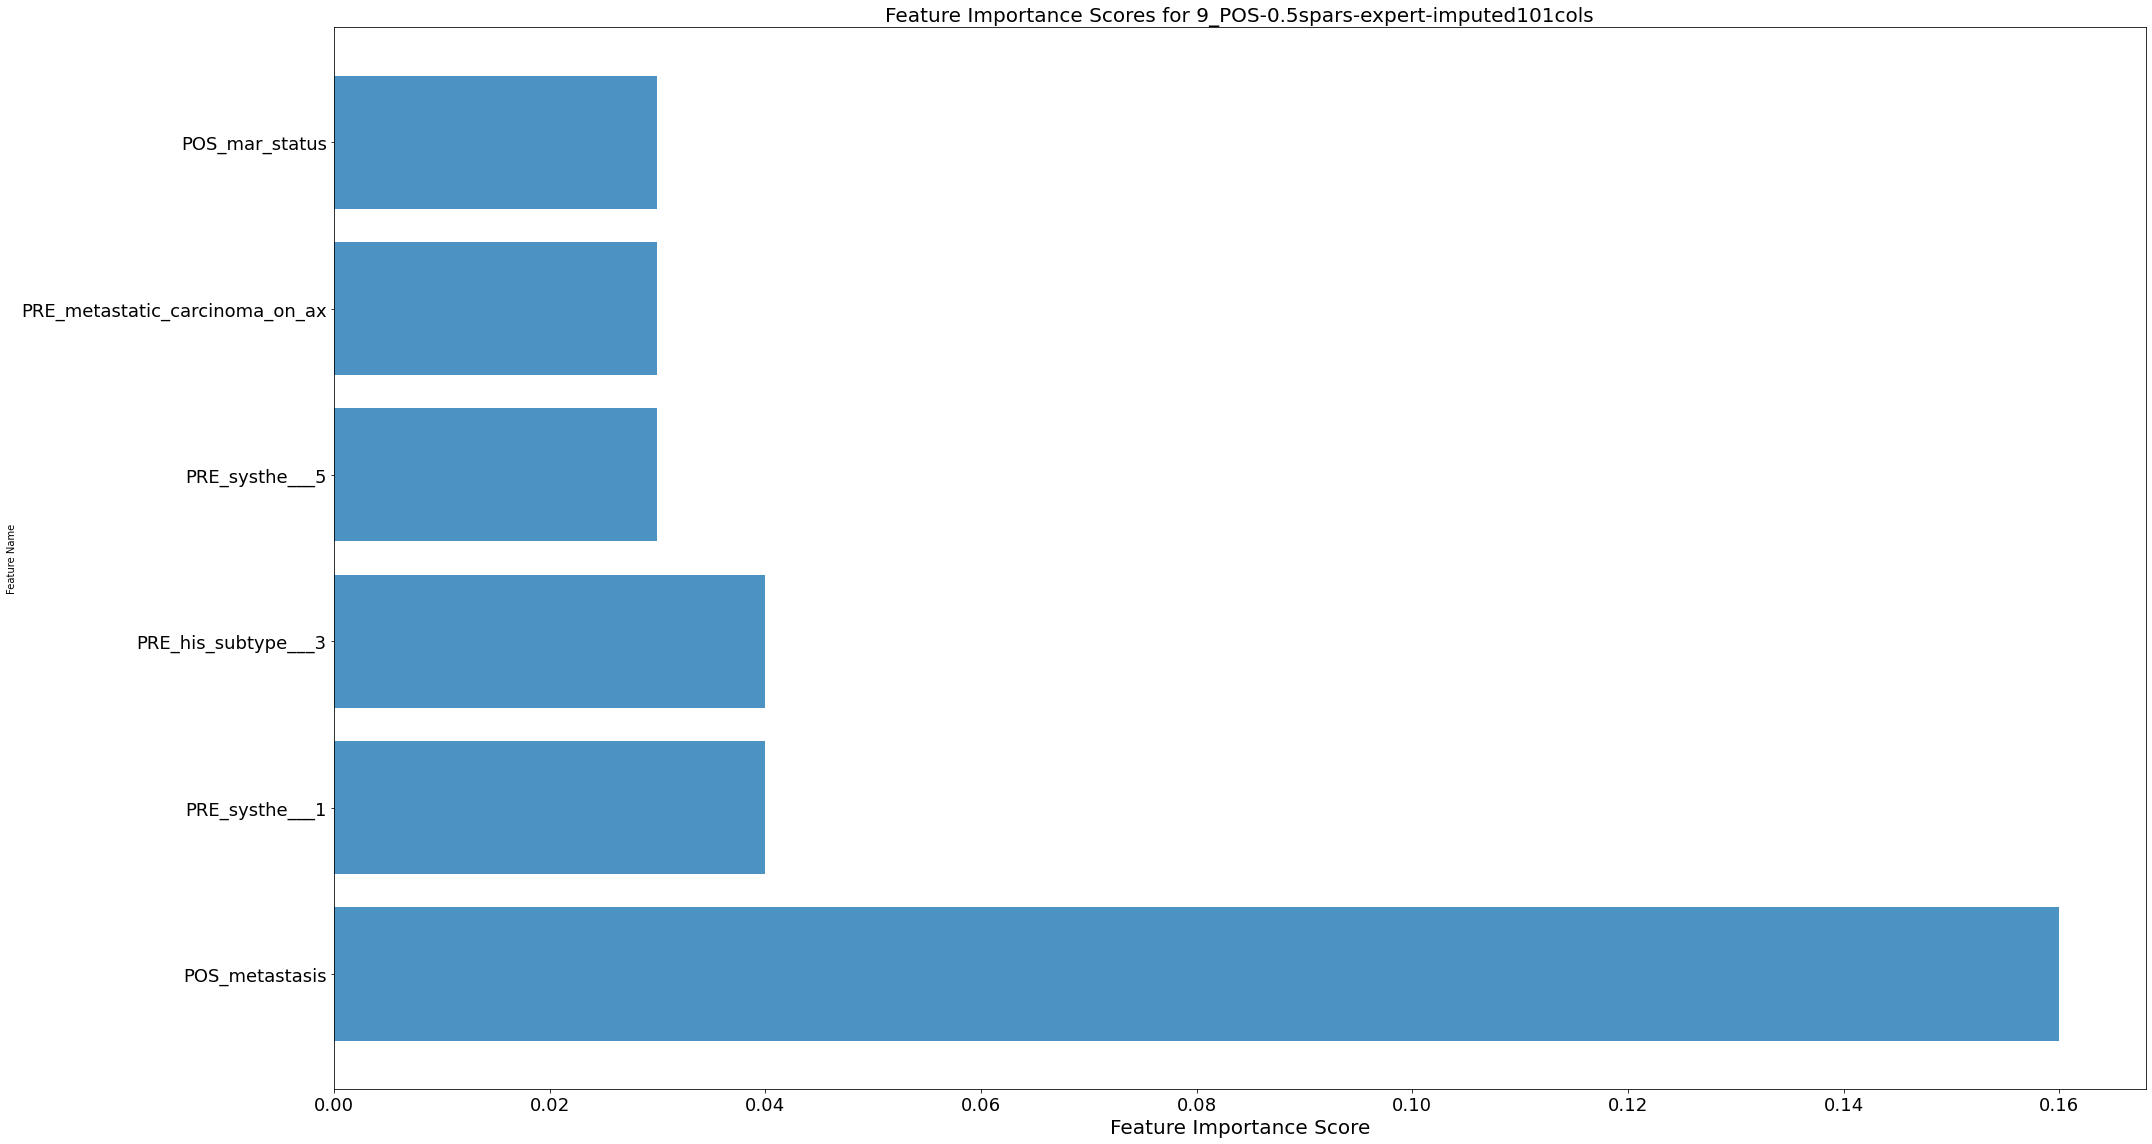

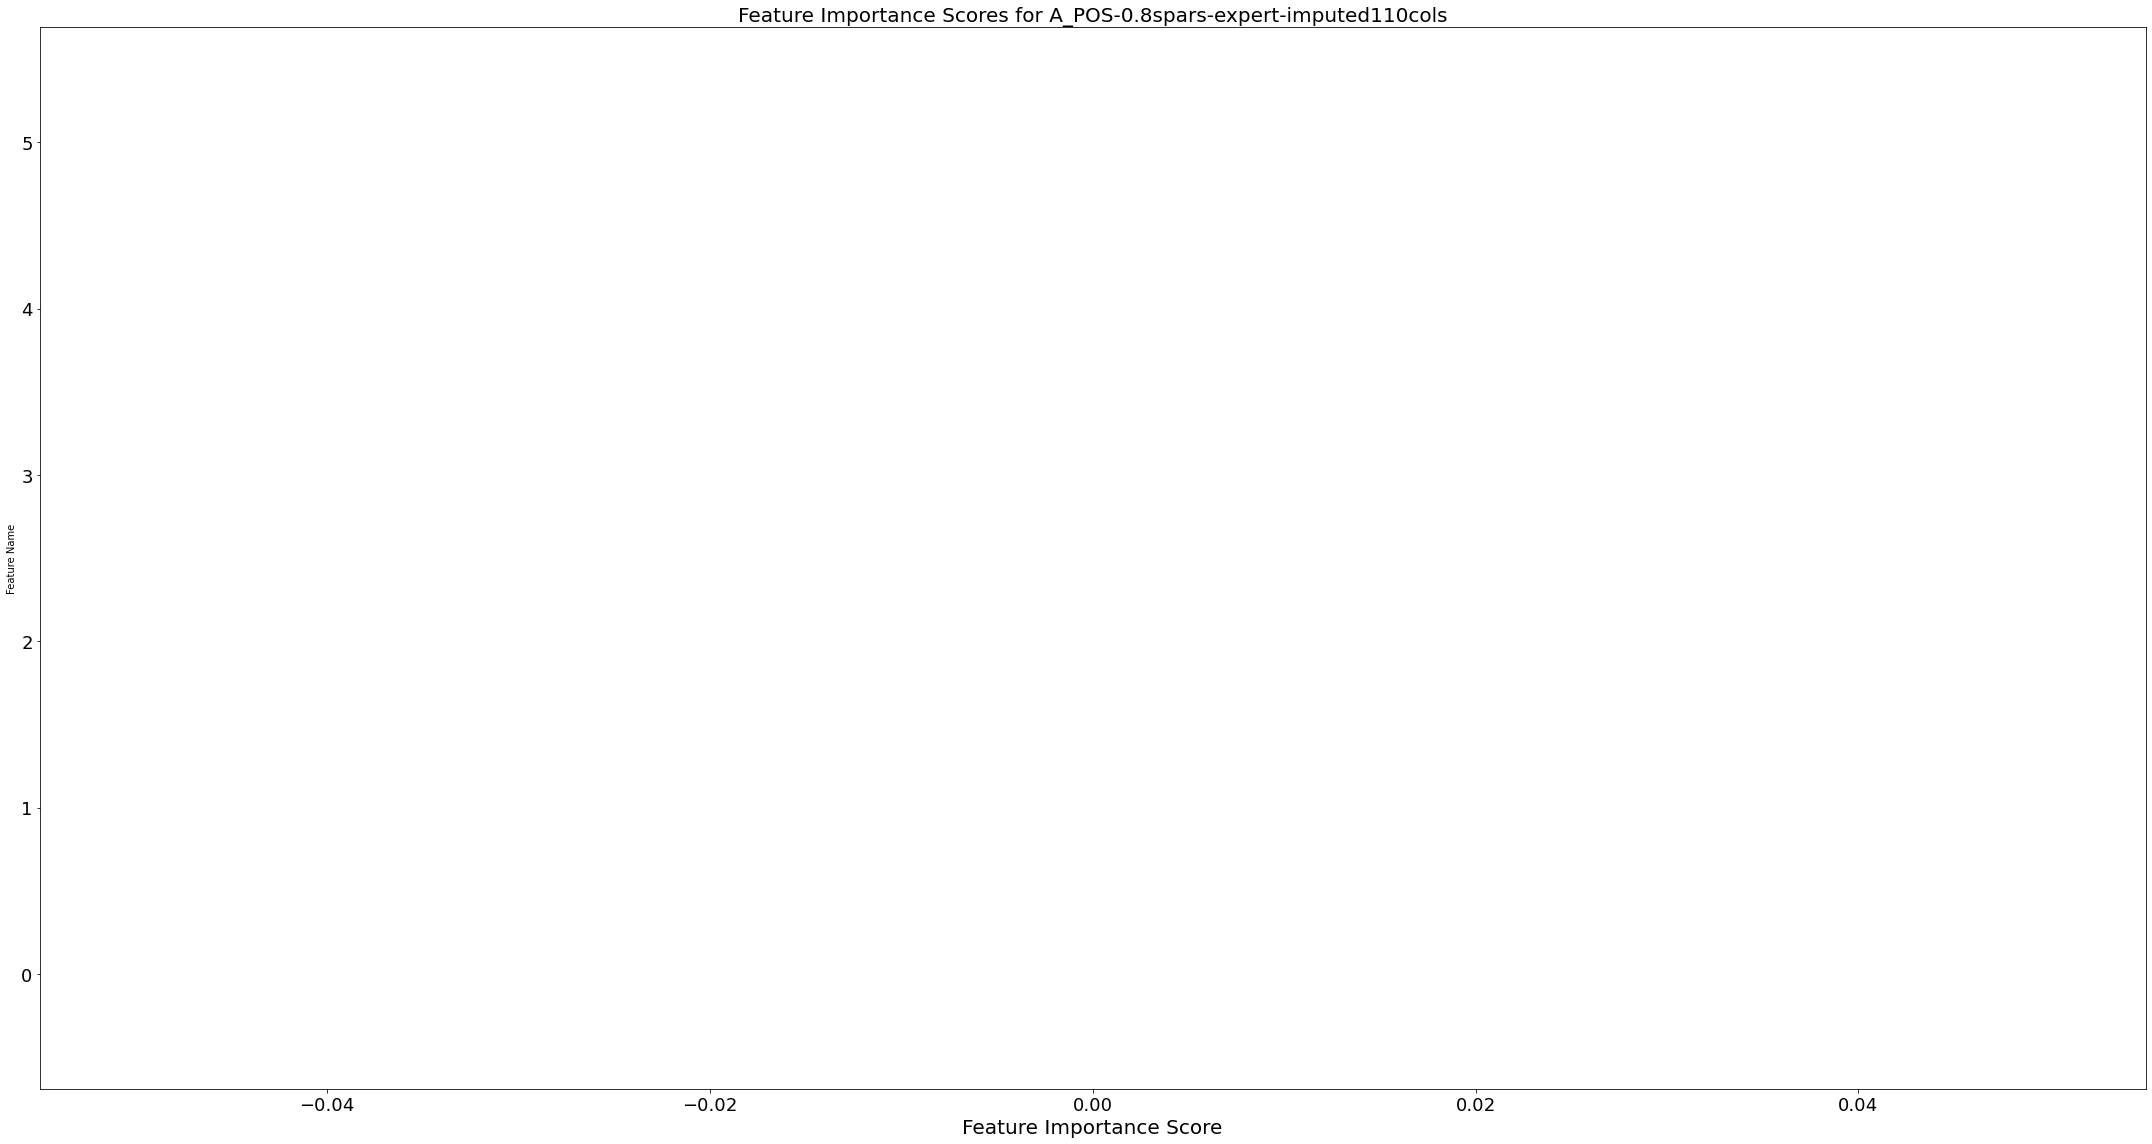

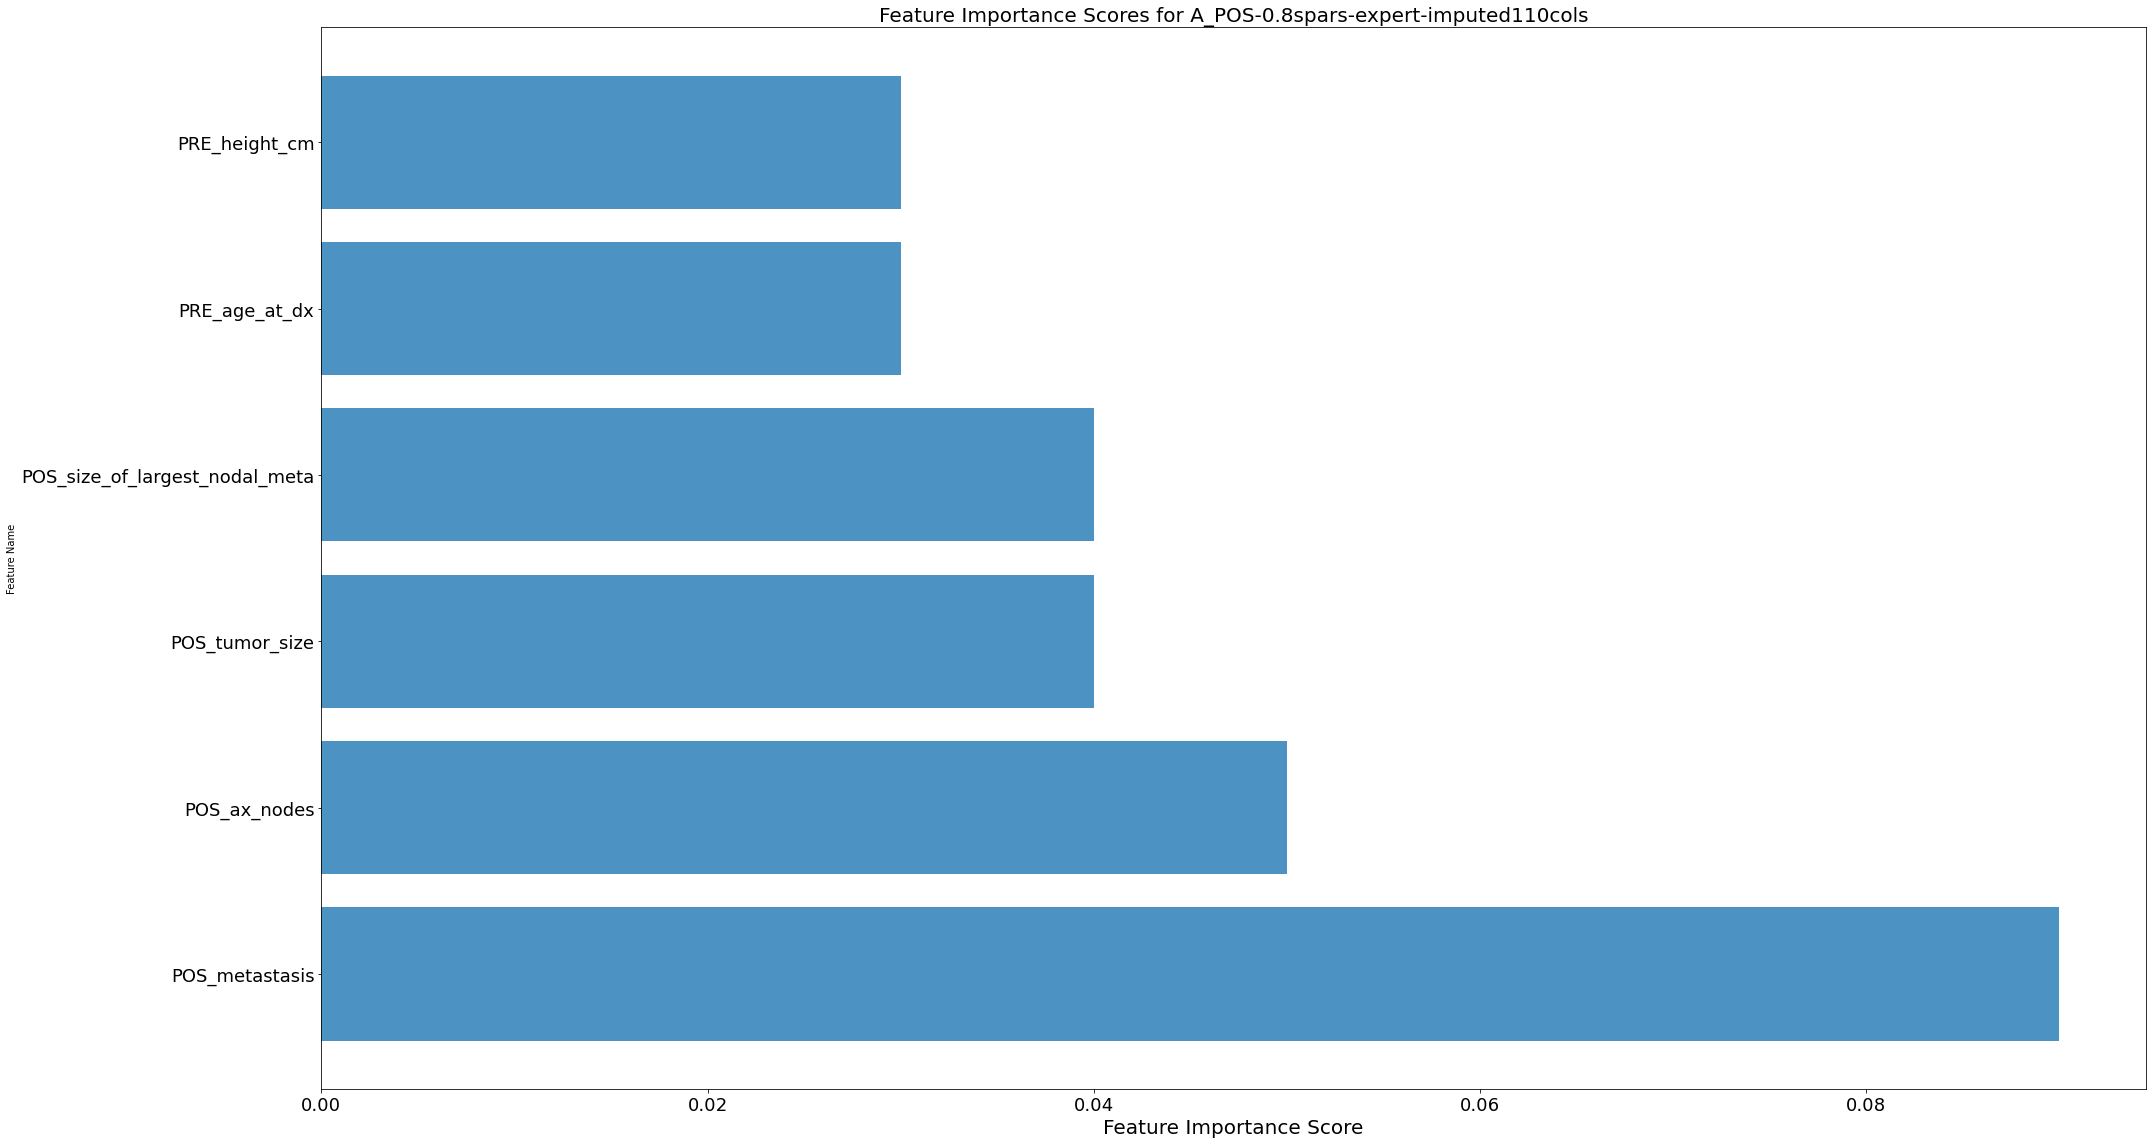

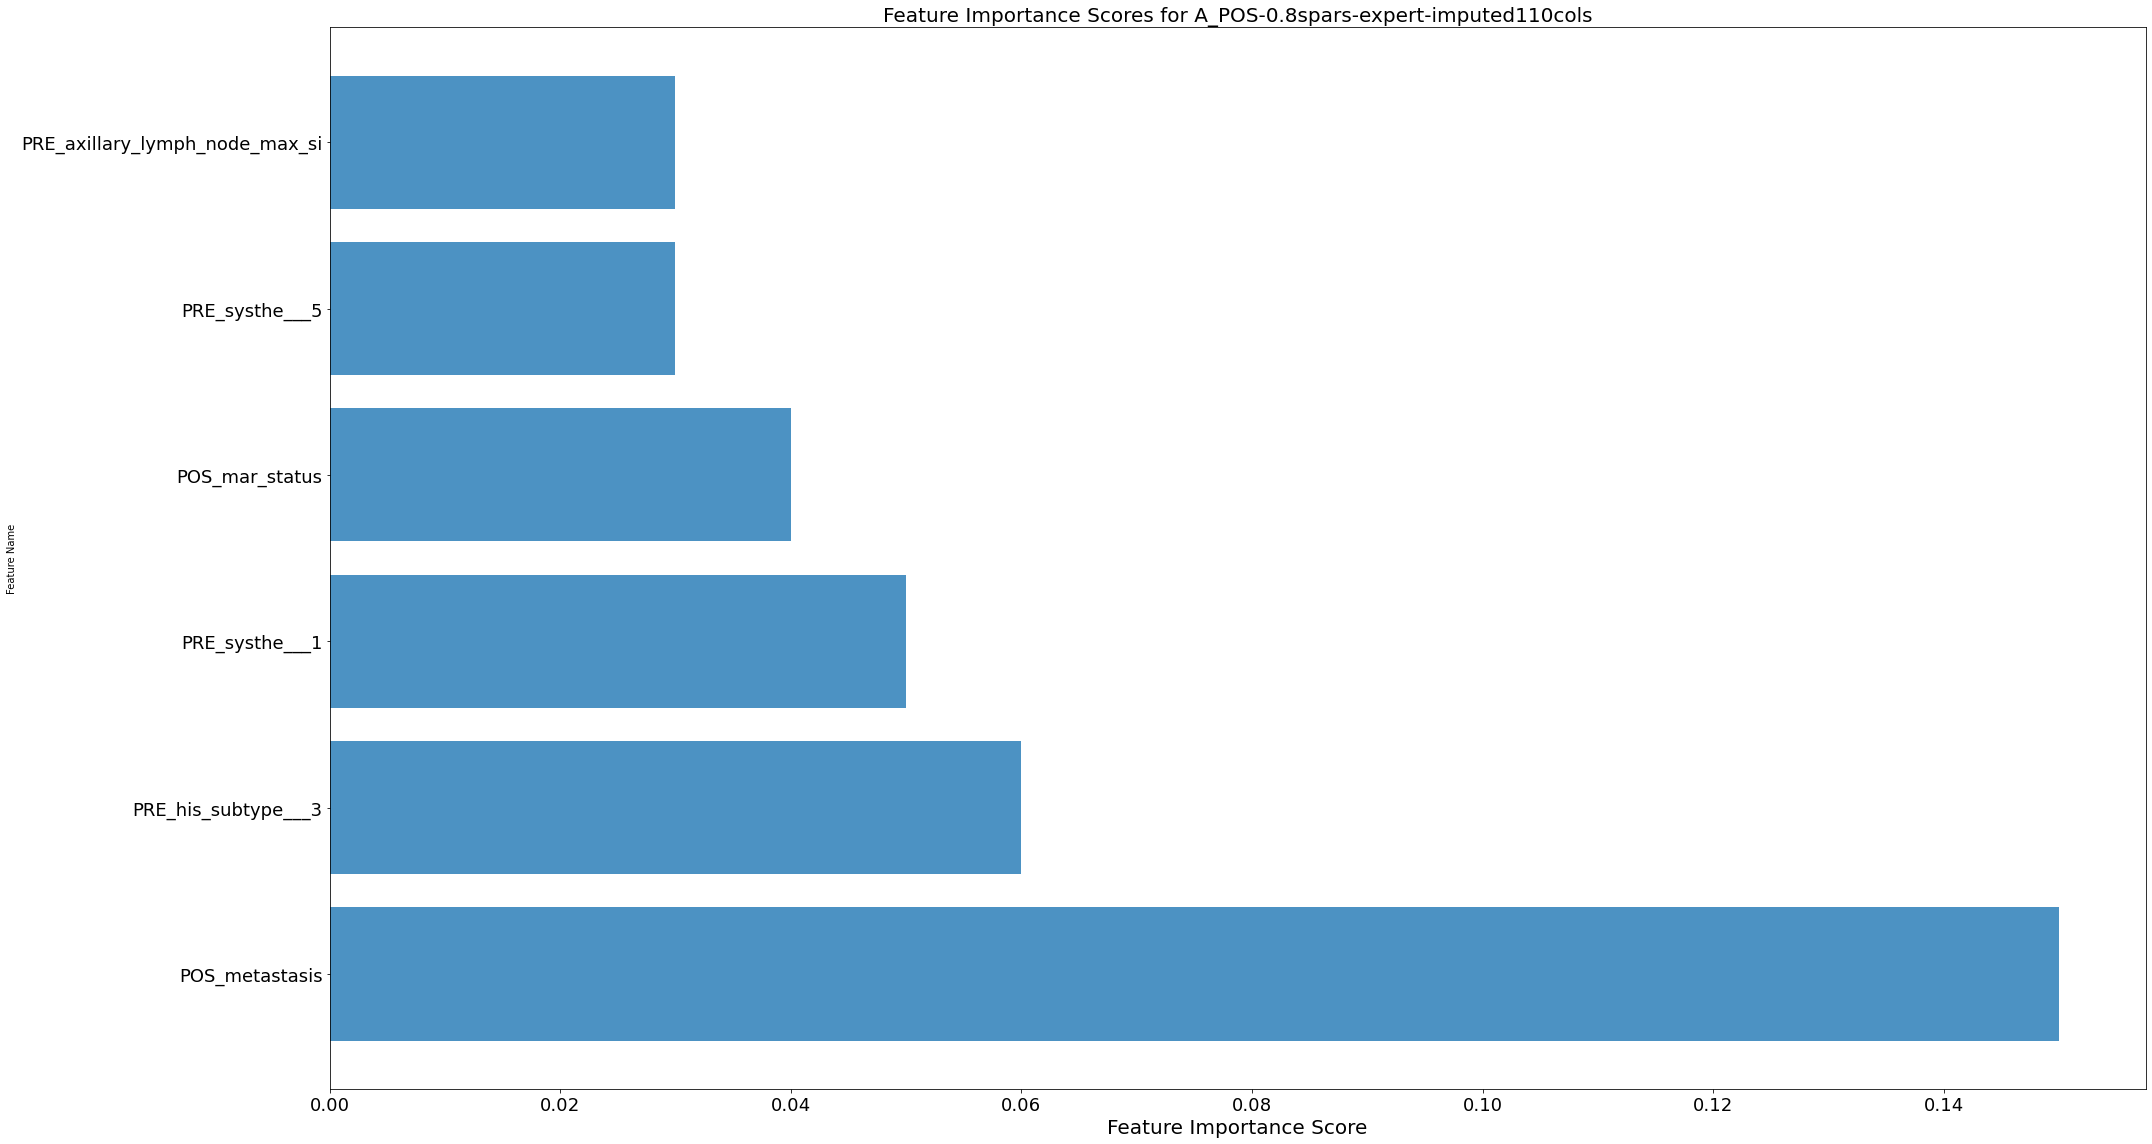

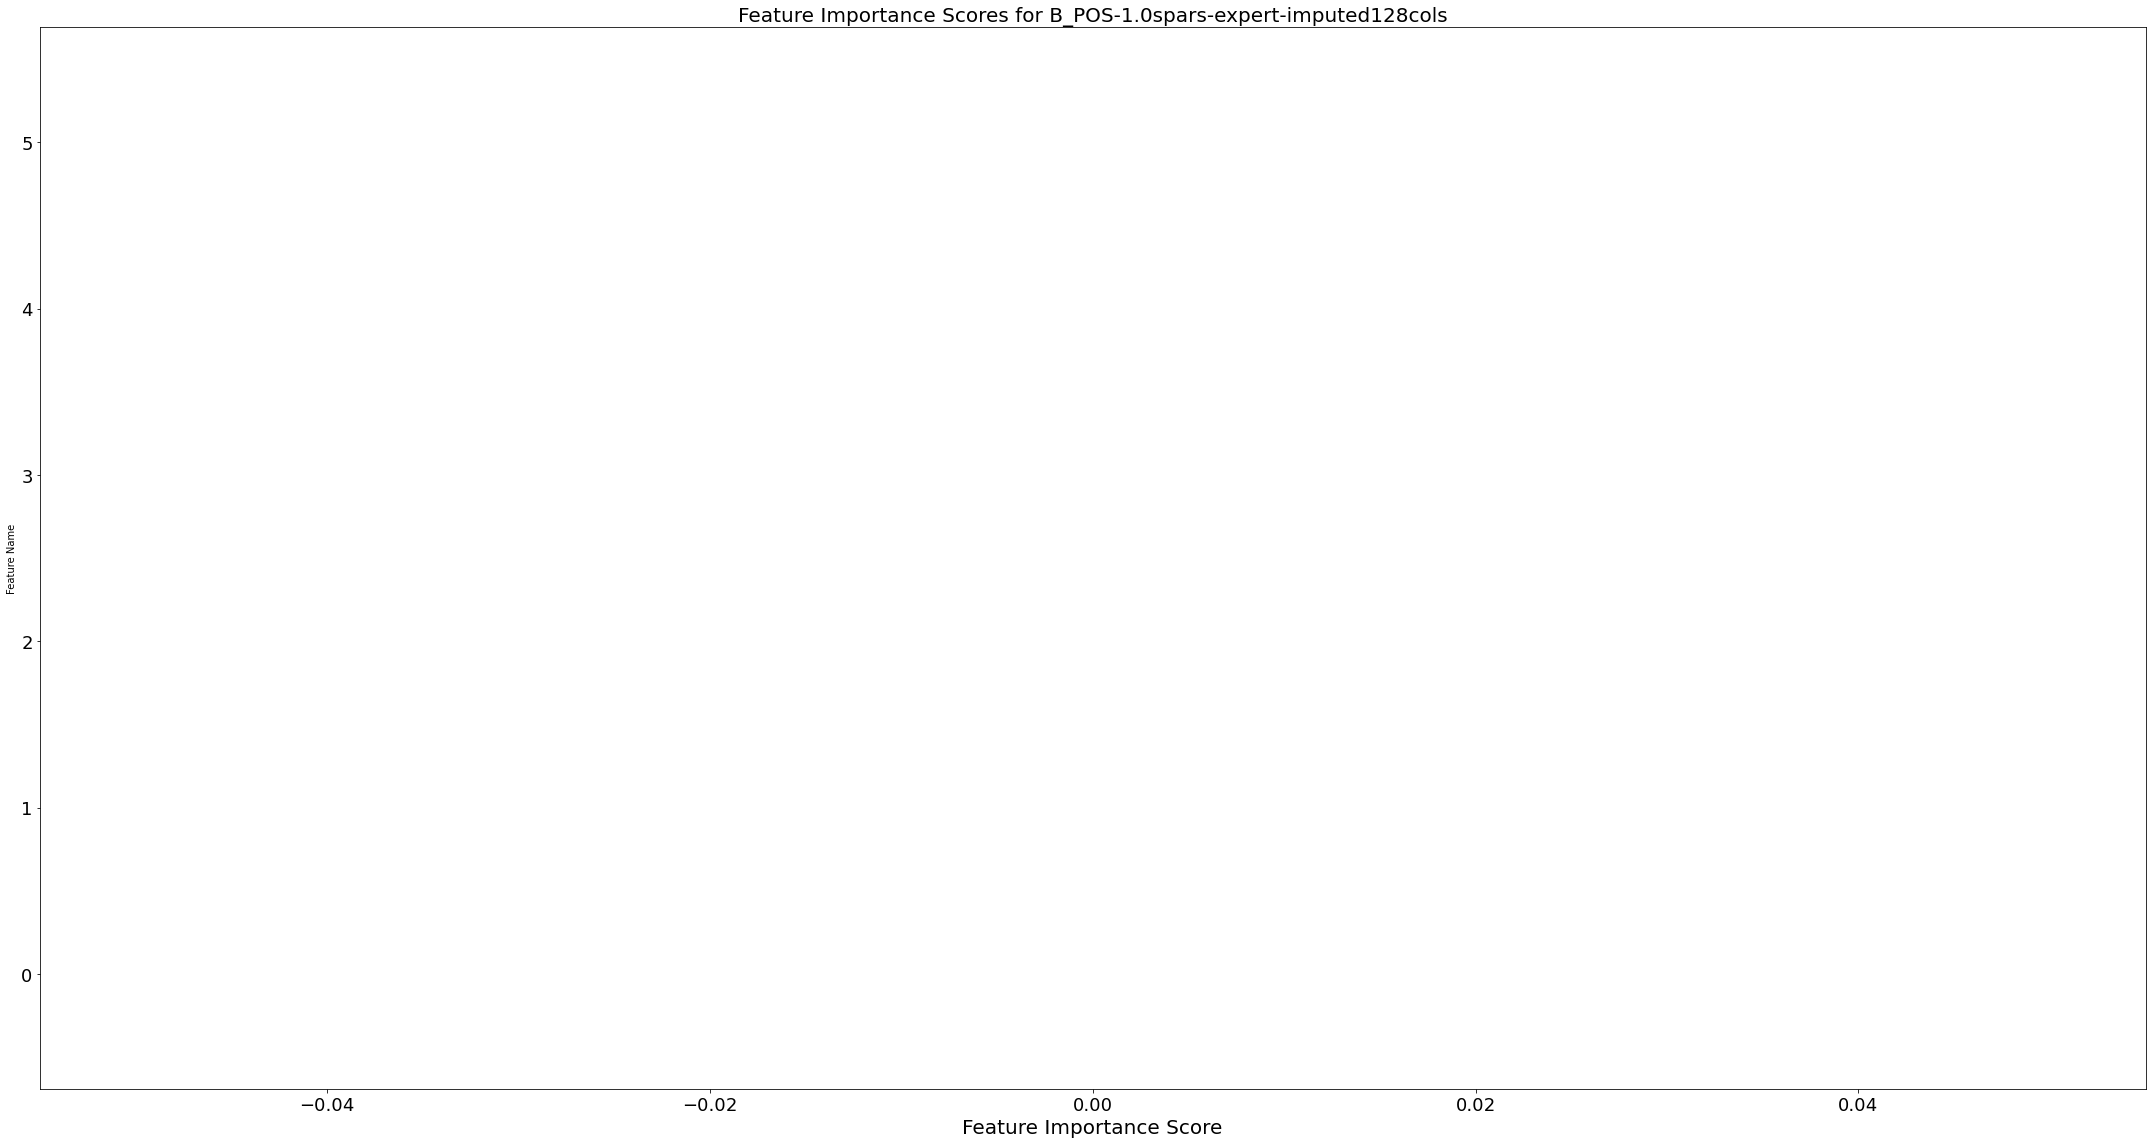

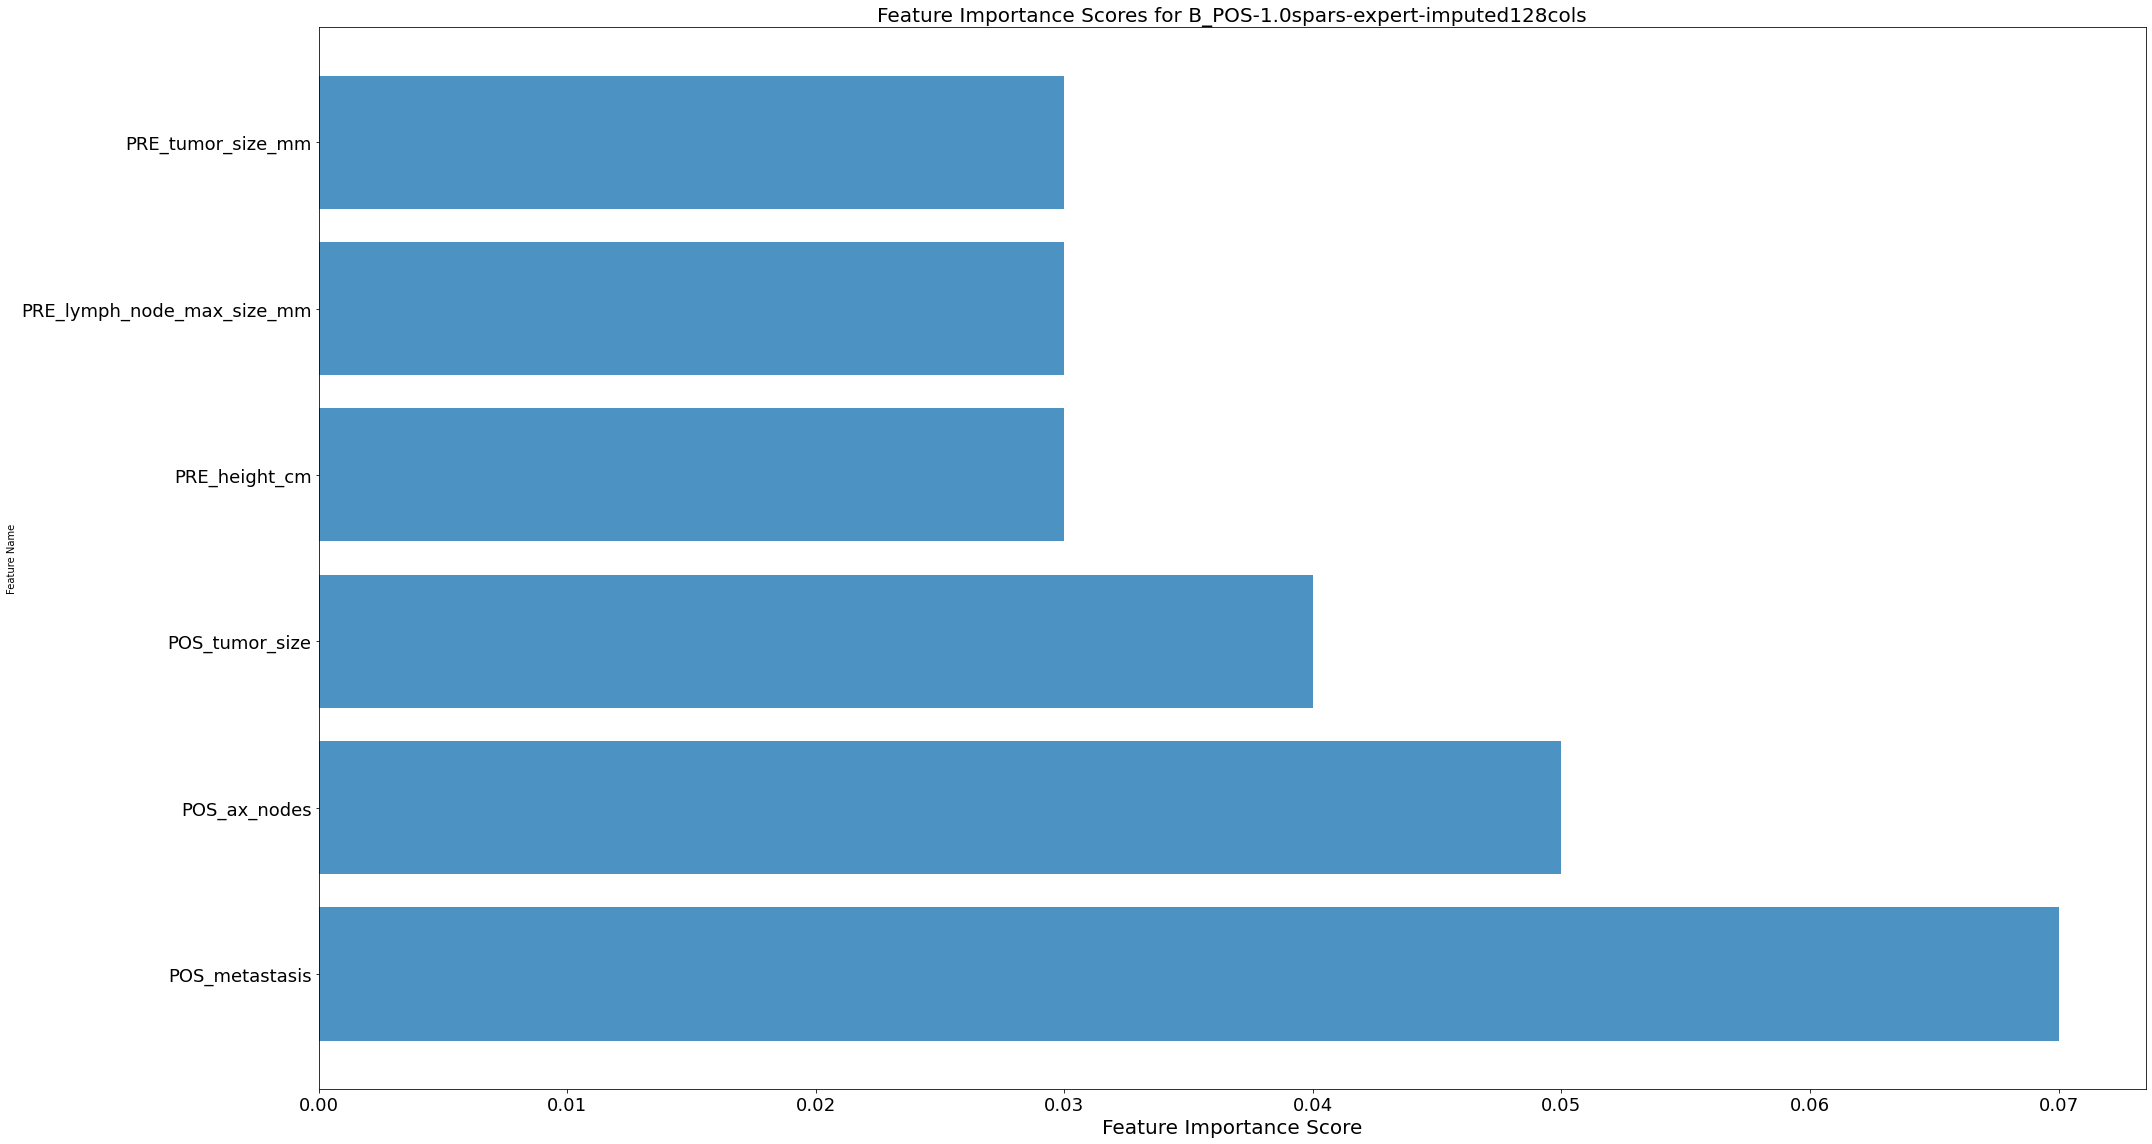

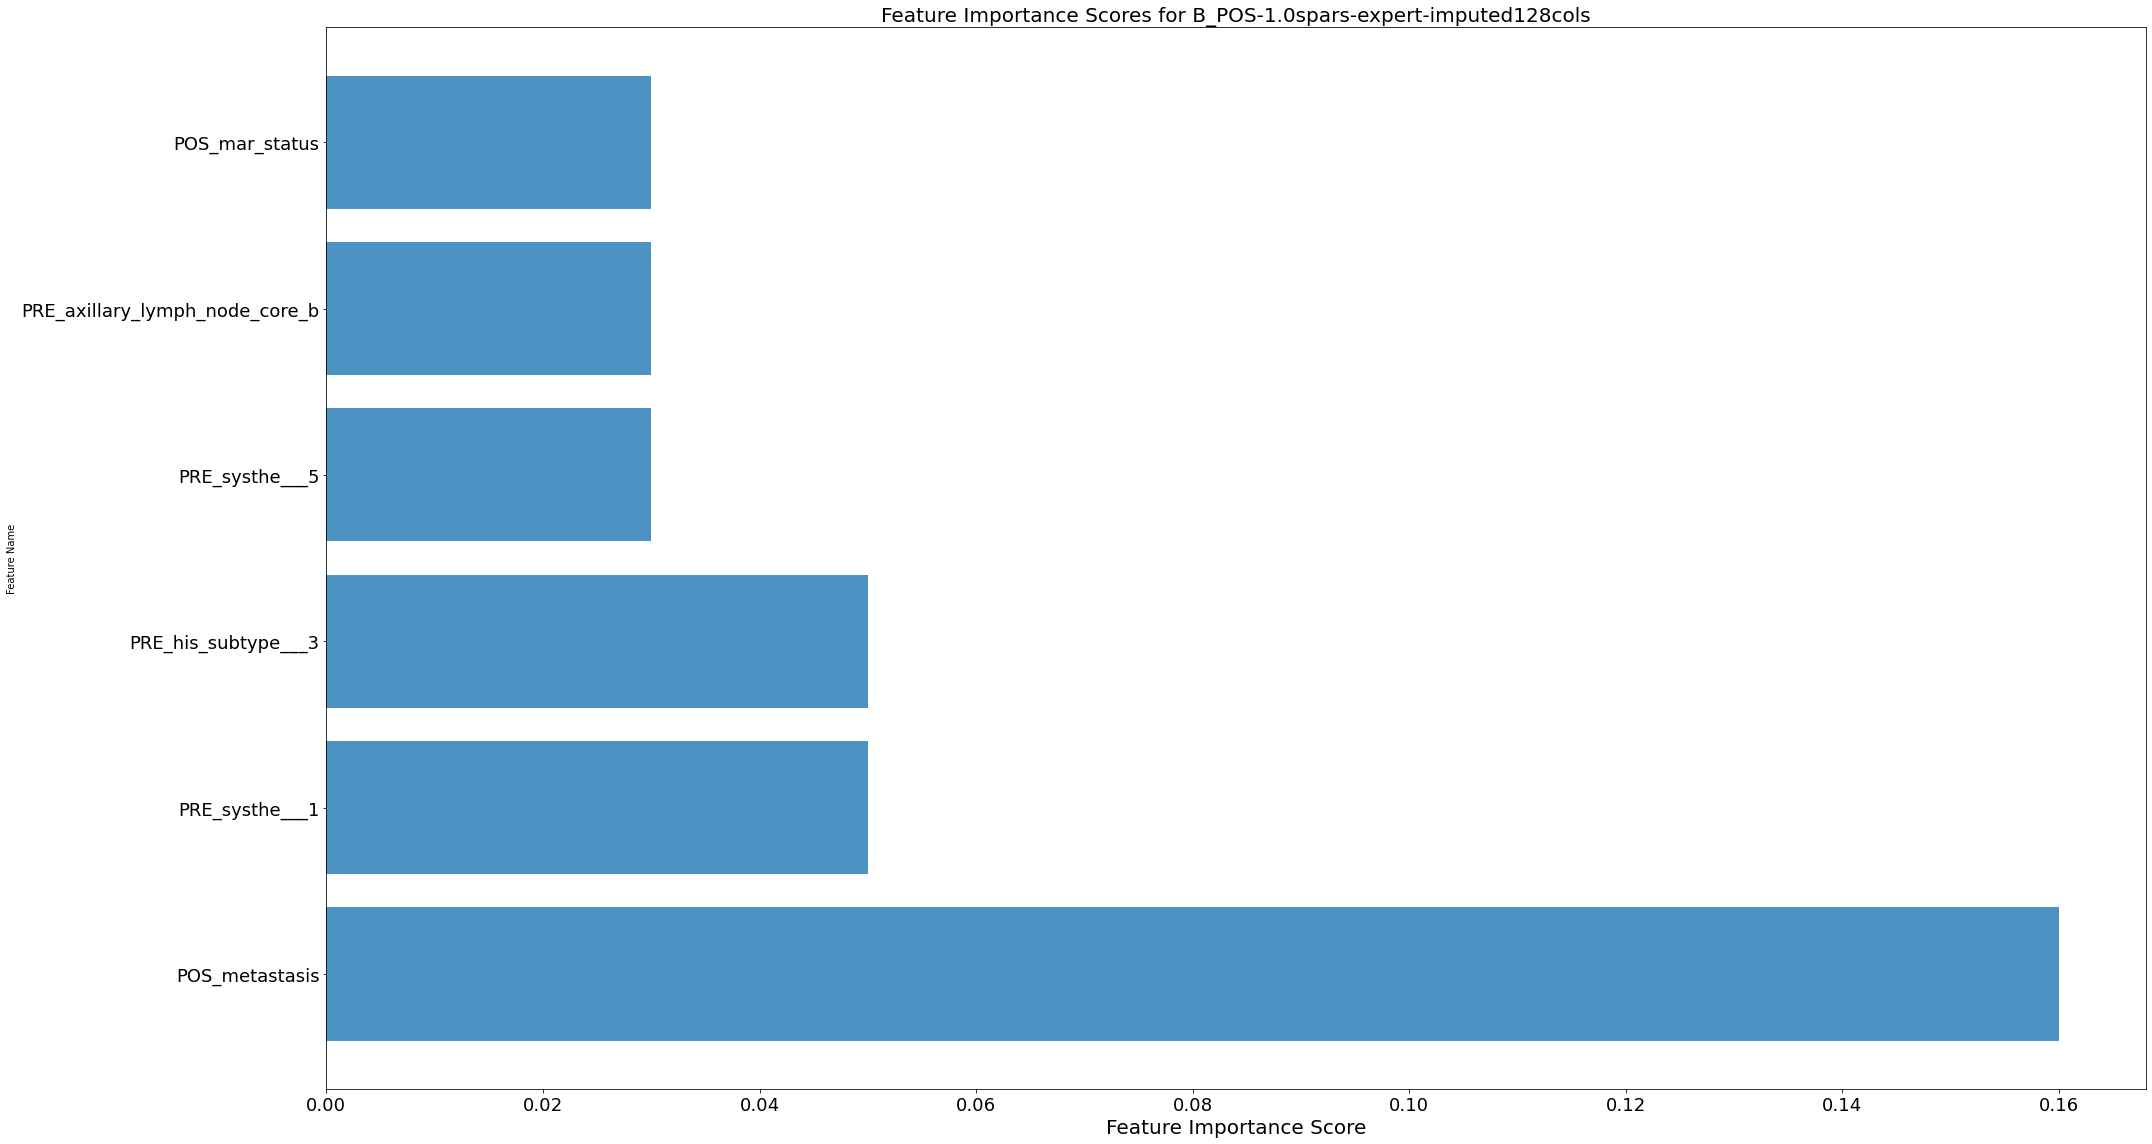

In [14]:
# Plot the most important features and scores for each model
# Create subplots for each DataFrame
for df_name, print_df in plot_dict.items():
    df_name = df_name.replace("/", "").replace(".csv", "")
    # Create a plot for the top 6 important features of each model
    # Y-Axis: Model + Feature Name
    # X-Axis: Feature importance score
    # Create subplots 
    for i, row in print_df.iterrows():
        top_features = [row["Feature_1"], row["Feature_2"], row["Feature_3"], row["Feature_4"], row["Feature_5"], row["Feature_6"]]
        feature_scores = [row["Score_1"], row["Score_2"], row["Score_3"], row["Score_4"], row["Score_5"], row["Score_6"]]
        # Create the plot
        plt.figure(figsize=(30, 16))
        plt.barh(top_features, feature_scores, align="center", alpha=0.7)
        plt.yticks(fontsize=18)
        plt.xticks(fontsize=18)
        plt.xlabel("Feature Importance Score", fontsize=20)
        plt.ylabel("Feature Name")
        plt.title(f"Feature Importance Scores for {df_name}", fontsize=20)
        plt.tight_layout()
        # Save the plot
        plt.savefig(os.path.join(plot_dir, f"{df_name}_{row['Model']}_feature_importance.png"))
